<h1>Predicting the Energy Star Score of Buildings </h1>

In [1]:
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt
import plotly
import warnings
from sklearn.impute import KNNImputer
import numpy as np
import seaborn as sns
from  matplotlib.ticker import PercentFormatter
import matplotlib

warnings.filterwarnings('ignore')
%matplotlib inline

<h2>Read the data sets and check for null<h2>

In [2]:
use_case1=pd.read_csv("C:\\Users\\GS-2224\\Desktop\\jet2\\Usecase1_Dataset.csv")
use_case1.isna().sum()

Order                                                            0
Property Id                                                      0
Property Name                                                    0
Parent Property Id                                               0
Parent Property Name                                             0
BBL - 10 digits                                                 11
NYC Borough, Block and Lot (BBL) self-reported                   0
NYC Building Identification Number (BIN)                         0
Address 1 (self-reported)                                        0
Address 2                                                        0
Postal Code                                                      0
Street Number                                                  124
Street Name                                                    122
Borough                                                        118
DOF Gross Floor Area                                          

<h3>Remove trailing blankspace from 'NTA'<h3>

In [3]:
use_case1['NTA']=use_case1['NTA'].fillna('Not Available')
use_case1['NTA']=use_case1['NTA'].apply(lambda x:x.strip() if type(x)!='str' else 'Not Available')
use_case1['NTA']

0             Turtle Bay-East Midtown
1            Washington Heights South
2            Washington Heights South
3            Washington Heights South
4            Washington Heights South
                     ...             
11741    Brooklyn Heights-Cobble Hill
11742    Brooklyn Heights-Cobble Hill
11743                   Not Available
11744              Park Slope-Gowanus
11745                    Clinton Hill
Name: NTA, Length: 11746, dtype: object

<h2>Converting 'ENERGY STAR RATING' from numeric score to grade (A,B,C,D,N) </h2>
<p>This is as per the information provided in the ppt</p>
<p>This will be used further for plotting and checking distribution</p>

In [4]:
def get_rating(x):
    if x.isnumeric():
        x=int(x)
        if x>85:
            return 'A'
        elif (x>70) & (x<=85):
            return 'B'
        elif (x>55) & (x<=70):
            return 'C'
        elif (x<=55):
            return 'D'
    else: 
        return 'N'
        

use_case1['ENERGY STAR RATING']=use_case1['ENERGY STAR Score'].apply(lambda x:get_rating(x))

label=use_case1['ENERGY STAR RATING']

In [5]:
pd.unique(use_case1['ENERGY STAR RATING'])

array(['N', 'D', 'A', 'B', 'C'], dtype=object)

<h1>Data Preparation and Exploration of Categorical features</h1>
<h2>Step1:Reading and checking for null</h2>

In [6]:
category=use_case1[['Primary Property Type - Self Selected',
                    'Largest Property Use Type',
                    '2nd Largest Property Use Type',
                    '3rd Largest Property Use Type',
                    'Metered Areas (Energy)',
                    'Metered Areas  (Water)',
                    'NTA','Water Required?','DOF Benchmarking Submission Status','ENERGY STAR RATING']]
category.fillna('Not Available',inplace=True)
category.isna().sum()

Primary Property Type - Self Selected    0
Largest Property Use Type                0
2nd Largest Property Use Type            0
3rd Largest Property Use Type            0
Metered Areas (Energy)                   0
Metered Areas  (Water)                   0
NTA                                      0
Water Required?                          0
DOF Benchmarking Submission Status       0
ENERGY STAR RATING                       0
dtype: int64

In [7]:
category.head(3)

Primary Property Type - Self Selected  \
0                                 Office   
1  Hospital (General Medical & Surgical)   
2  Hospital (General Medical & Surgical)   

               Largest Property Use Type 2nd Largest Property Use Type  \
0                                 Office                 Not Available   
1  Hospital (General Medical & Surgical)                 Not Available   
2  Hospital (General Medical & Surgical)                 Not Available   

  3rd Largest Property Use Type Metered Areas (Energy) Metered Areas  (Water)  \
0                 Not Available         Whole Building          Not Available   
1                 Not Available         Whole Building         Whole Building   
2                 Not Available          Not Available          Not Available   

                        NTA Water Required?  \
0   Turtle Bay-East Midtown              No   
1  Washington Heights South              No   
2  Washington Heights South              No   

  DOF Benchmarking Submission Status ENERGY STAR RATING  
0                      In Compliance                  N  
1                      In Compliance                  D  
2                      In Compliance                  N

<h2>Step2: Plotting and checking distributions of categorical features</h2>
<h3>Creating a generic function for plotting</h3>

In [8]:
def plot_cat(col_cat):
    '''This function is used to plot distributions for all categorical variables'''
    result_df=category.groupby(by=[col_cat,'ENERGY STAR RATING'],as_index=False).count().iloc[:,0:3]
    result_df.columns=[col_cat,'ENERGY STAR RATING','count']
    result_df['percent']=(result_df['count']*100)/result_df['count'].sum()
    result_df.sort_values(by='percent',inplace=True,ascending=False)
    wrapper_table = pd.pivot(result_df,columns='ENERGY STAR RATING', index=col_cat, values=['percent'])
    lst=category[col_cat].value_counts().index.tolist()
    lst.reverse()
    
    wrapper_table=wrapper_table.reindex(lst)
    wrapper_table.columns=[x[1] for x in wrapper_table.columns]
    ly=wrapper_table.index.tolist()
    ly.reverse()
    print(ly[0:10])
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1,sharex=False)
    fig.set_size_inches(15, 15)
    ax1.set_facecolor('white')
    ax1.spines['bottom'].set_color('black')
    ax1.spines['left'].set_color('black')

    plt.draw()
    ax1.set_ylabel('Count')
    colrs=['tab:cyan','tab:blue','tab:orange','tab:green','tab:red','violet','tab:purple']

    barp=wrapper_table.plot(kind='barh', stacked=True,ax=ax1,color=colrs)
    ax1.set_ylabel('')
    ax1.set_xlabel('% of Records',size=30)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)


    ax1.set_title(col_cat,size=30)

    lg=plt.legend(title='Energy Rating',prop={'size':10})
    lg.get_title().set_fontsize('15')
    plt.savefig('C:\\Users\\GS-2224\\Desktop\\jet2\\barplots\\' + col_cat.replace(" ", "").replace("?", "") + '.png')


    fig, ax2 = plt.subplots(nrows=1, ncols=1,sharex=False)
    fig.set_size_inches(15, 15)

    ax2.set_facecolor('white')
    ax2.spines['bottom'].set_color('black')
    ax2.spines['left'].set_color('black')

    plt.draw()
    ax2.set_ylabel('Count')
    colrs=['tab:cyan','tab:blue','tab:orange','tab:green','tab:red','violet','tab:purple']

    wrapper_table.plot(kind='barh', stacked=True,ax=ax2,color=colrs)
    ax2.set_ylabel('')
    ax2.set_xlabel('% of Records (Log Scale)',size=30)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ax2.set_title(col_cat + '(Y on log scale)',size=30)
    plt.xscale('log')
    lg=plt.legend(title='Energy Rating',prop={'size':10})
    lg.get_title().set_fontsize('15')    
    plt.savefig('C:\\Users\\GS-2224\\Desktop\\jet2\\barplots\\' + col_cat.replace(" ", "").replace("?", "") + '_log.png')
    

<h3>Creating a generic function for plotting , with image size 15, 40 inches</h3>

In [9]:
def plot_cat_long(col_cat):
    '''This function is used to plot distributions for all categorical variables'''
    result_df=category.groupby(by=[col_cat,'ENERGY STAR RATING'],as_index=False).count().iloc[:,0:3]
    result_df.columns=[col_cat,'ENERGY STAR RATING','count']
    result_df['percent']=(result_df['count']*100)/result_df['count'].sum()
    result_df.sort_values(by='percent',inplace=True,ascending=False)
    wrapper_table = pd.pivot(result_df,columns='ENERGY STAR RATING', index=col_cat, values=['percent'])
    lst=category[col_cat].value_counts().index.tolist()
    lst.reverse()
    
    wrapper_table=wrapper_table.reindex(lst)
    wrapper_table.columns=[x[1] for x in wrapper_table.columns]
    ly=wrapper_table.index.tolist()
    ly.reverse()
    print(ly[0:30])
    
    fig, ax1 = plt.subplots(nrows=1, ncols=1,sharex=False)
    fig.set_size_inches(15, 40)
    ax1.set_facecolor('white')
    ax1.spines['bottom'].set_color('black')
    ax1.spines['left'].set_color('black')

    plt.draw()
    ax1.set_ylabel('Count')
    colrs=['tab:cyan','tab:blue','tab:orange','tab:green','tab:red','violet','tab:purple']

    barp=wrapper_table.plot(kind='barh', stacked=True,ax=ax1,color=colrs)
    ax1.set_ylabel('')
    ax1.set_xlabel('% of Records',size=30)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)


    ax1.set_title(col_cat,size=30)

    lg=plt.legend(title='Energy Rating',prop={'size':10})
    lg.get_title().set_fontsize('15')
    plt.savefig('C:\\Users\\GS-2224\\Desktop\\jet2\\barplots\\' + col_cat.replace(" ", "").replace("?", "") + '.png')


    fig, ax2 = plt.subplots(nrows=1, ncols=1,sharex=False)
    fig.set_size_inches(15, 40)

    ax2.set_facecolor('white')
    ax2.spines['bottom'].set_color('black')
    ax2.spines['left'].set_color('black')

    plt.draw()
    ax2.set_ylabel('Count')
    colrs=['tab:cyan','tab:blue','tab:orange','tab:green','tab:red','violet','tab:purple']

    wrapper_table.plot(kind='barh', stacked=True,ax=ax2,color=colrs)
    ax2.set_ylabel('')
    ax2.set_xlabel('% of Records (Log Scale)',size=30)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ax2.set_title(col_cat + '(Y on log scale)',size=30)
    plt.xscale('log')
    lg=plt.legend(title='Energy Rating',prop={'size':10})
    lg.get_title().set_fontsize('15')    
    plt.savefig('C:\\Users\\GS-2224\\Desktop\\jet2\\barplots\\' + col_cat.replace(" ", "").replace("?", "") + '_log.png')
    

<h2>Plotting Distributions for Various Categorical Features</h2>

<h3> 1] For 'Primary Property Type - Self Selected' </h3>

['Multifamily Housing', 'Office', 'Hotel', 'Other', 'Non-Refrigerated Warehouse', 'Residence Hall/Dormitory', 'College/University', 'Senior Care Community', 'Self-Storage Facility', 'Retail Store']


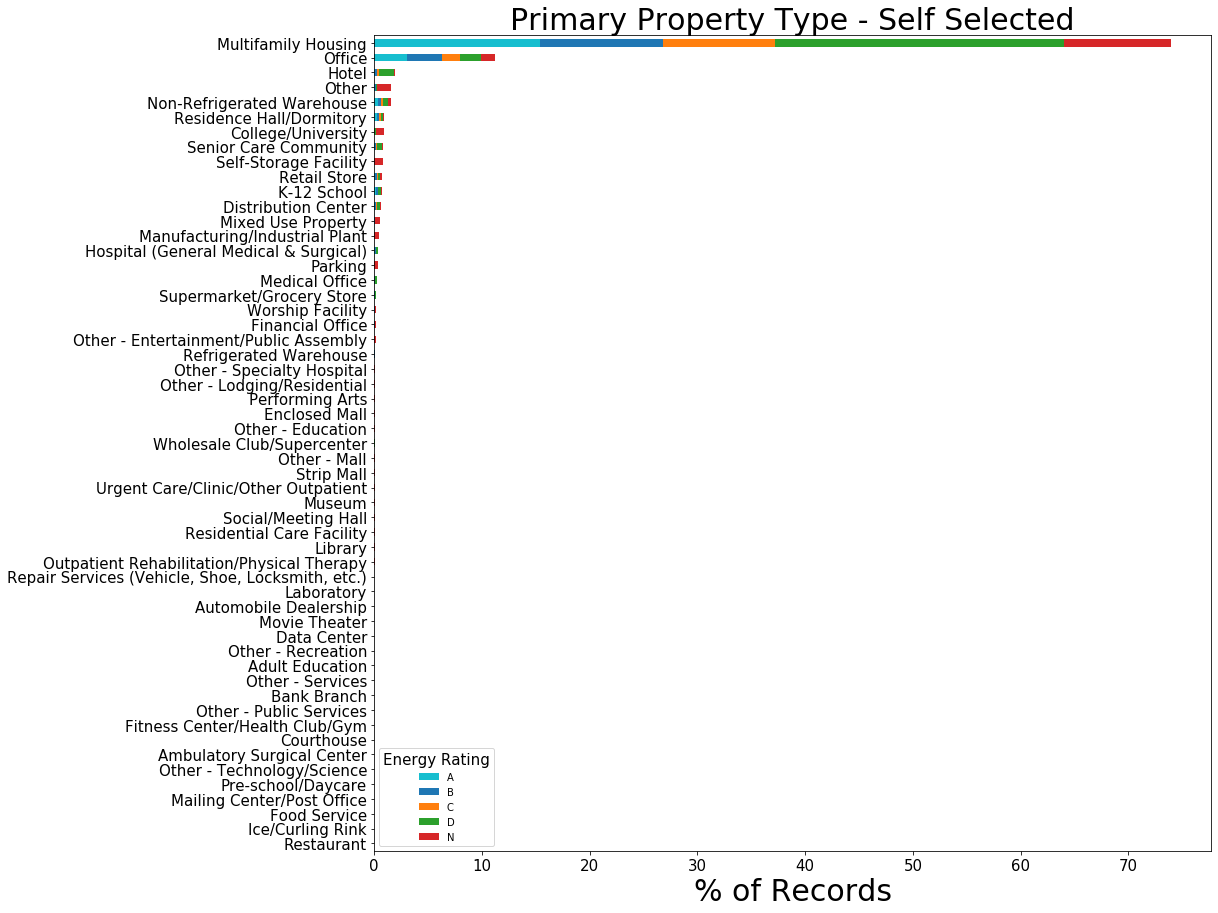

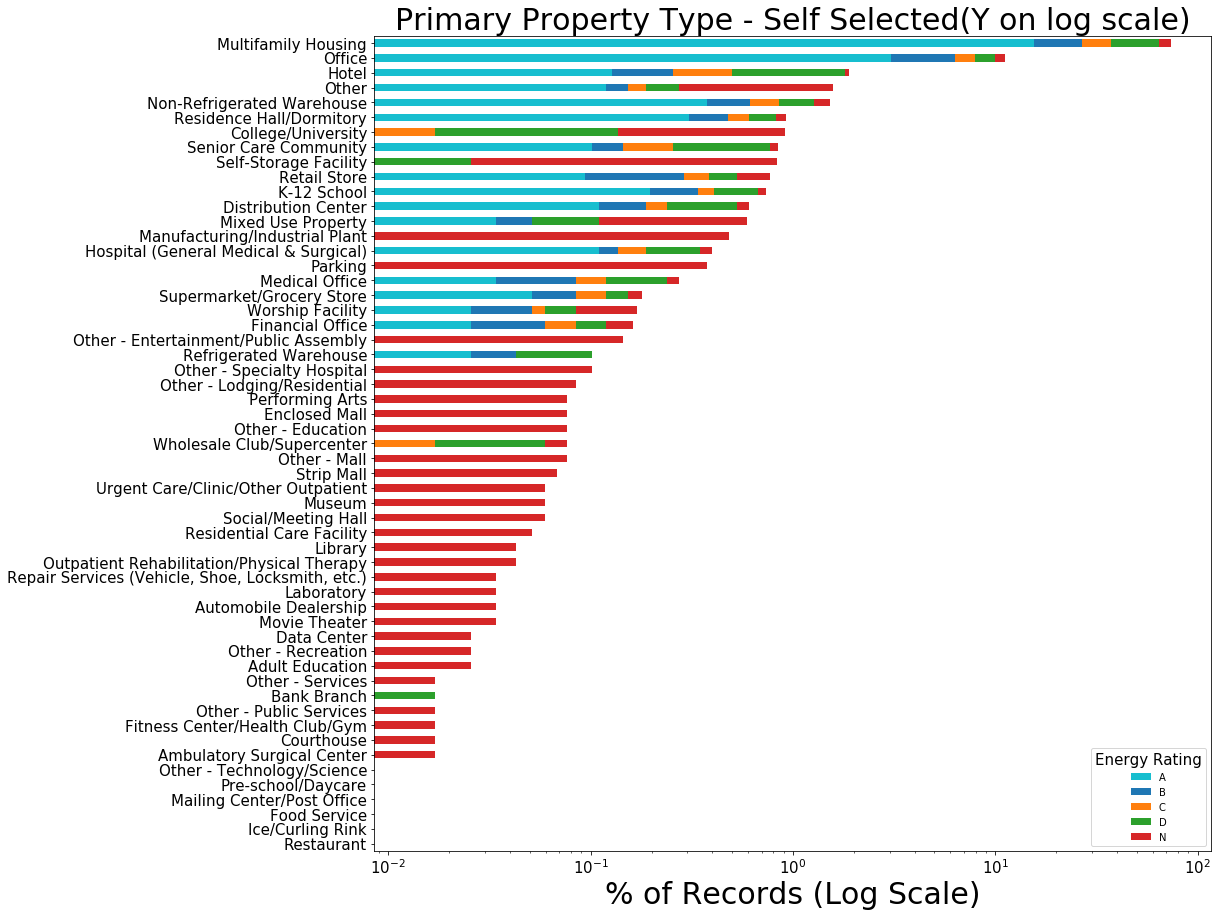

In [10]:
plot_cat('Primary Property Type - Self Selected')
category['Primary Property Type - Self Selected']=category['Primary Property Type - Self Selected'].apply(lambda x:x if x in ['Multifamily Housing', 'Office', 'Hotel', 'Other', 'Non-Refrigerated Warehouse', 'Residence Hall/Dormitory', 'College/University', 'Senior Care Community', 'Self-Storage Facility', 'Retail Store'] else 'Other')

<p>its evident from the above plot that only 'Multifamily Housing', 'Office', 'Hotel', 'Other', 'Non-Refrigerated Warehouse', 'Residence Hall/Dormitory', 'College/University', 'Senior Care Community', 'Self-Storage Facility', 'Retail Store' values have more records so we will move all other values into a necategory 'others' </p><br>
<p>Plots after restructuring</p>

['Multifamily Housing', 'Office', 'Other', 'Hotel', 'Non-Refrigerated Warehouse', 'Residence Hall/Dormitory', 'College/University', 'Senior Care Community', 'Self-Storage Facility', 'Retail Store']


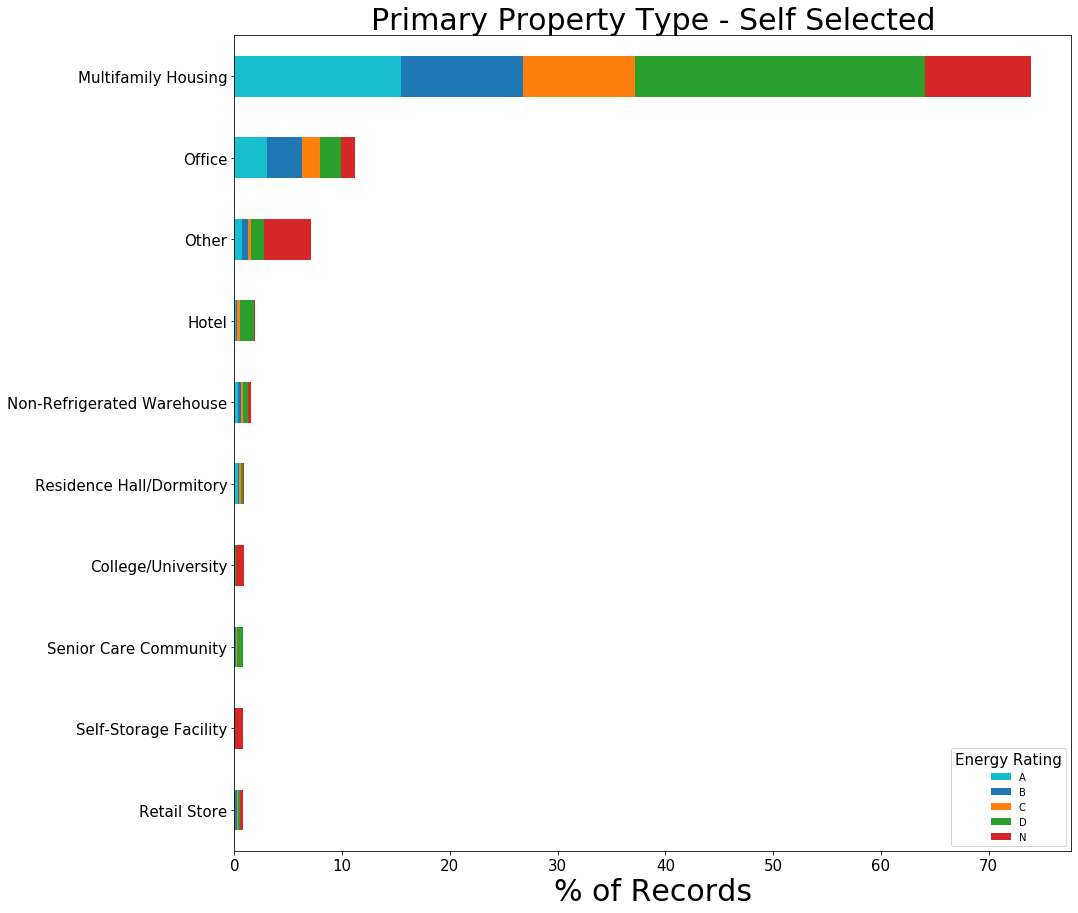

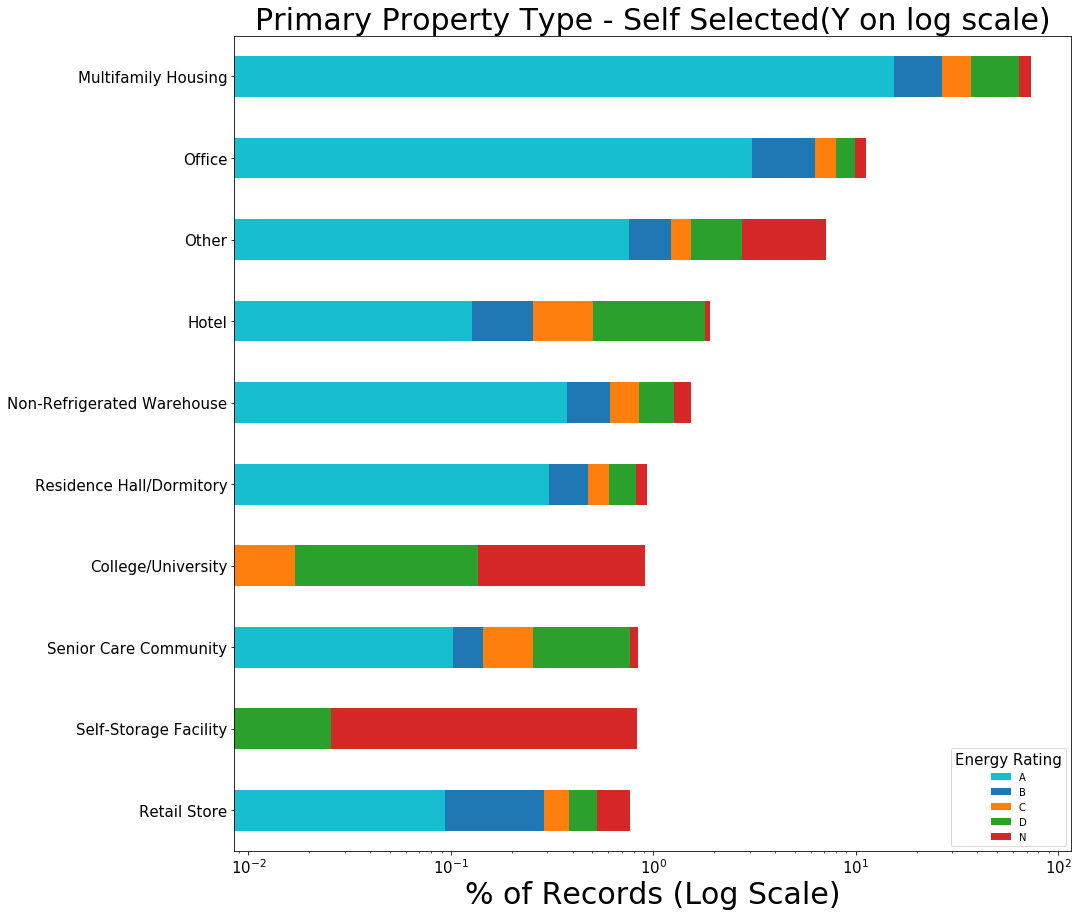

In [11]:
plot_cat('Primary Property Type - Self Selected')

<h3> 2] For 'Largest Property Use Type' </h3>

['Multifamily Housing', 'Office', 'Hotel', 'Non-Refrigerated Warehouse', 'Other', 'Residence Hall/Dormitory', 'K-12 School', 'Senior Care Community', 'Self-Storage Facility', 'Retail Store']


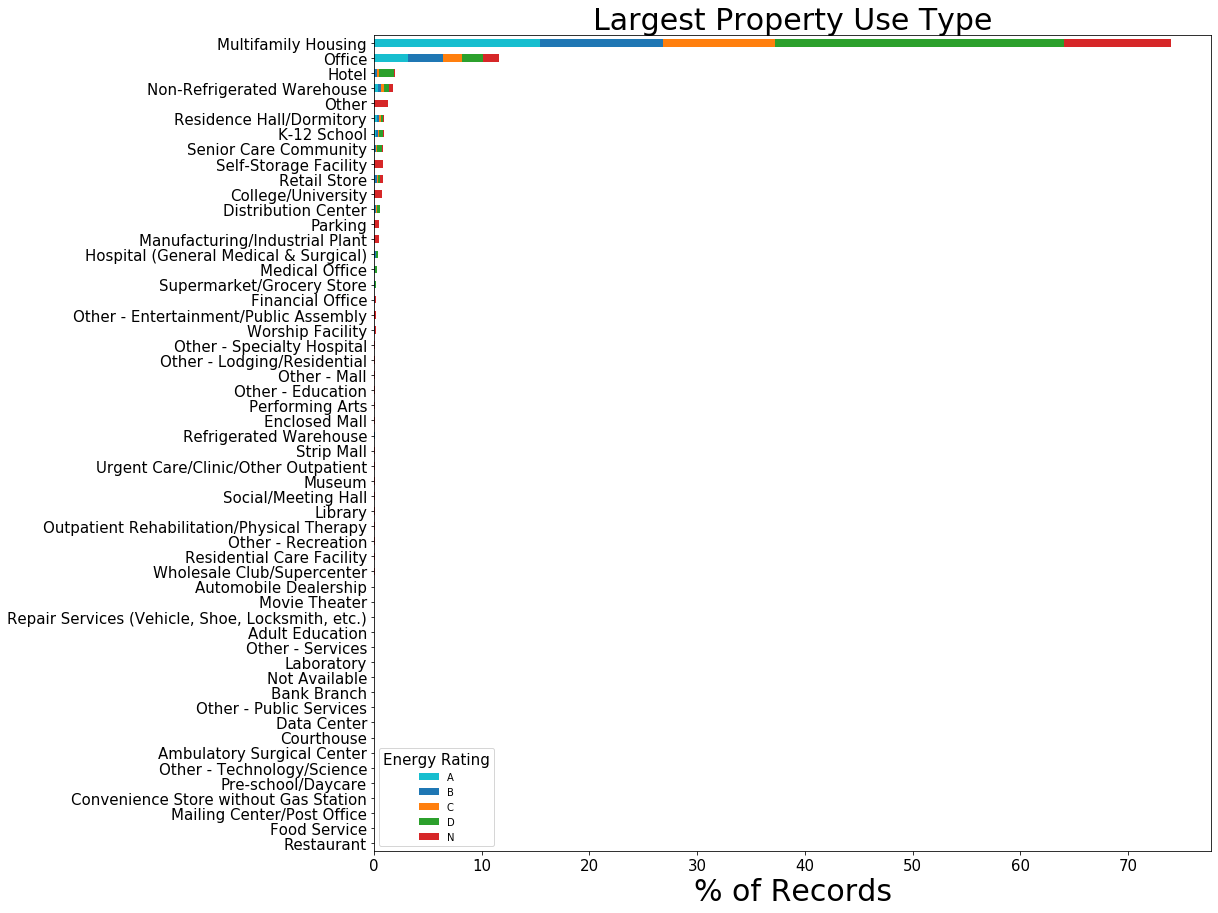

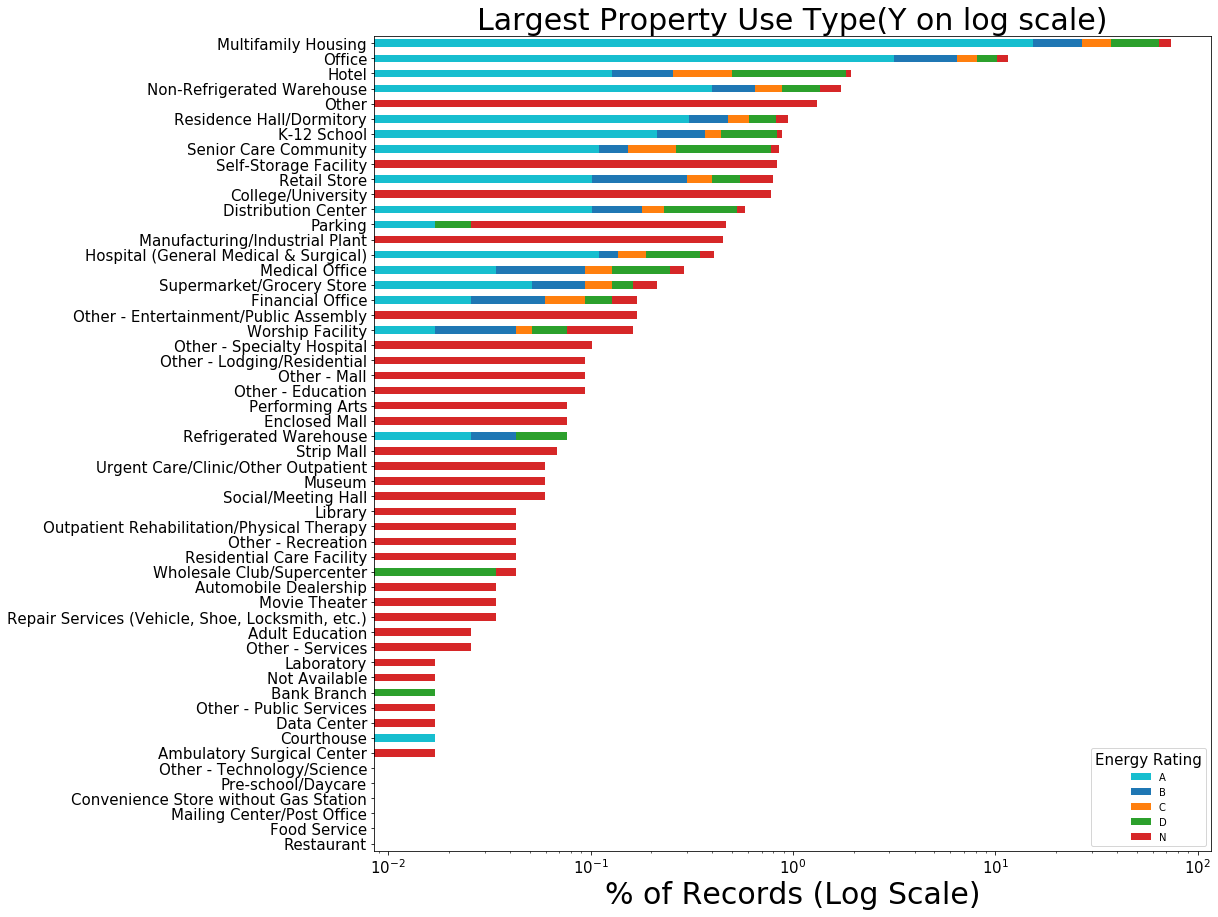

In [12]:
plot_cat('Largest Property Use Type')
category['Largest Property Use Type']=category['Largest Property Use Type'].apply(lambda x:x if x in ['Multifamily Housing', 'Office', 'Hotel', 'Non-Refrigerated Warehouse', 'Other', 'Residence Hall/Dormitory', 'K-12 School', 'Senior Care Community', 'Self-Storage Facility', 'Retail Store'] else 'Other')

<p>It is evident from the above plot that only 'Multifamily Housing', 'Office', 'Hotel', 'Non-Refrigerated Warehouse', 'Other', 'Residence Hall/Dormitory', 'K-12 School', 'Senior Care Community', 'Self-Storage Facility', 'Retail Store' values have more records so we will move all other values into a necategory 'others' </p><br>
<p>Plots after restructuring</p>

['Multifamily Housing', 'Office', 'Other', 'Hotel', 'Non-Refrigerated Warehouse', 'Residence Hall/Dormitory', 'K-12 School', 'Senior Care Community', 'Self-Storage Facility', 'Retail Store']


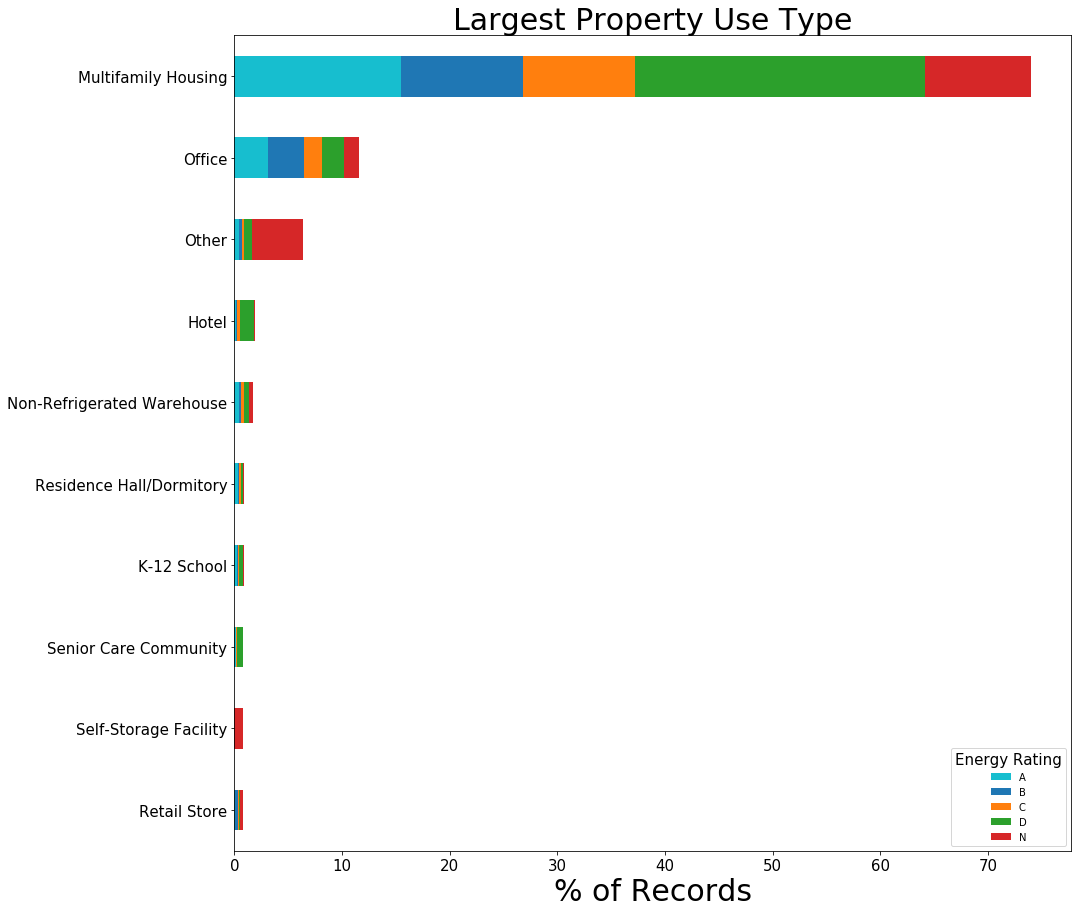

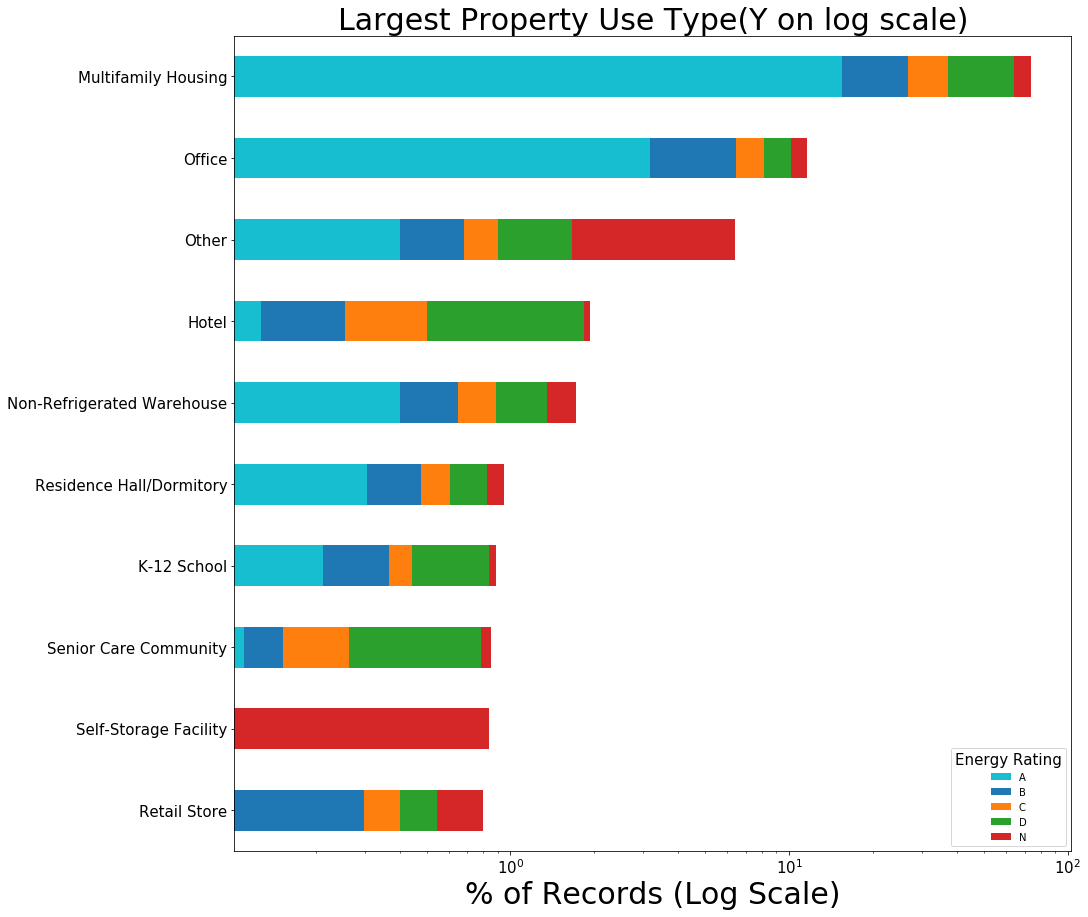

In [13]:
plot_cat('Largest Property Use Type')

<h3> 3] For '2nd Largest Property Use Type' </h3>

['Not Available', 'Retail Store', 'Parking', 'Other', 'Office', 'Medical Office', 'Restaurant', 'Financial Office', 'Supermarket/Grocery Store', 'Urgent Care/Clinic/Other Outpatient']


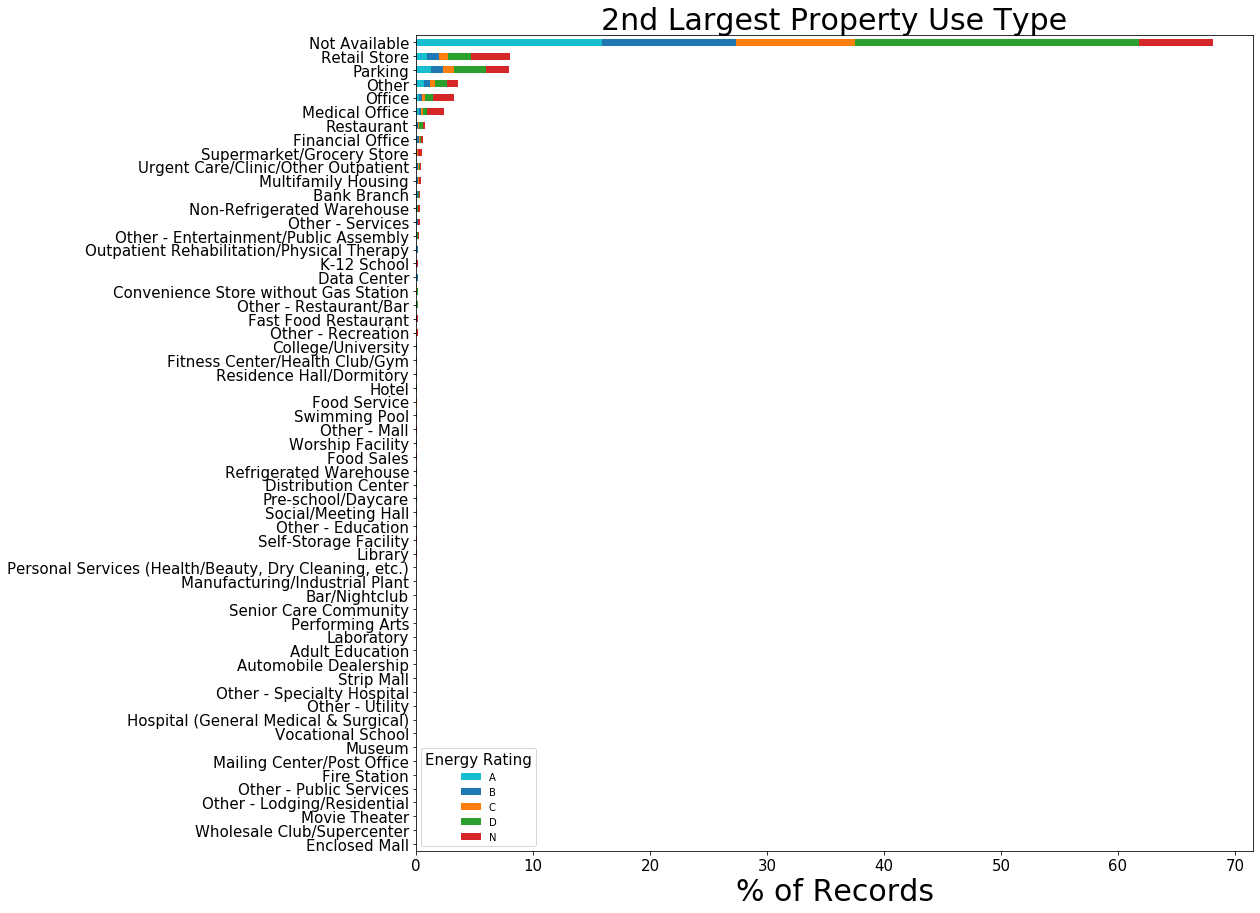

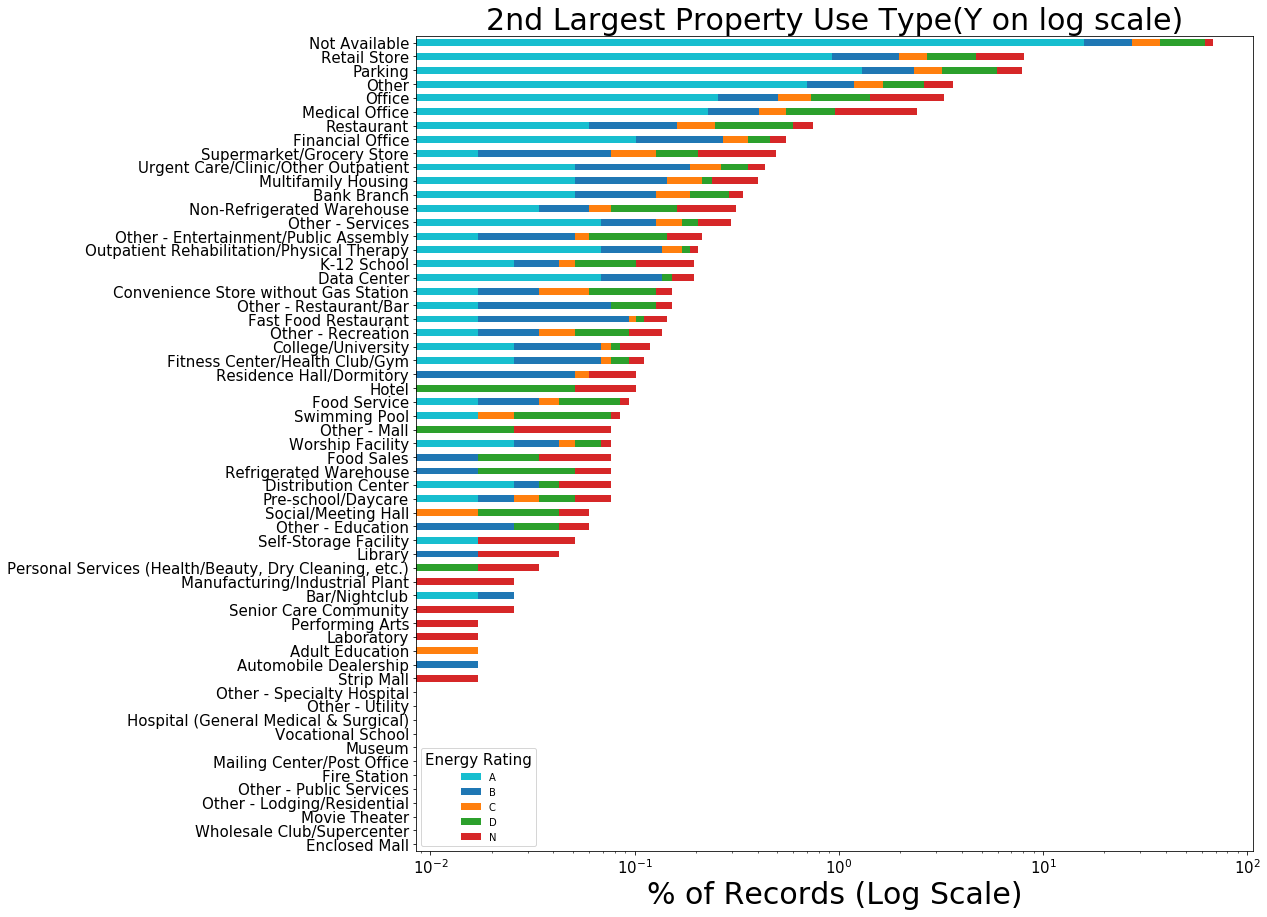

In [14]:
plot_cat('2nd Largest Property Use Type')
category['2nd Largest Property Use Type']=category['2nd Largest Property Use Type'].apply(lambda x:x if x in ['Not Available', 'Retail Store', 'Parking', 'Other', 'Office', 'Medical Office'] else 'Other')

<p>It is evident from the above plot that only 'Not Available', 'Retail Store', 'Parking', 'Other', 'Office', 'Medical Office' values have more records so we will move all other values into a necategory 'others' </p><br>
<p>Plots after restructuring</p>

['Not Available', 'Other', 'Retail Store', 'Parking', 'Office', 'Medical Office']


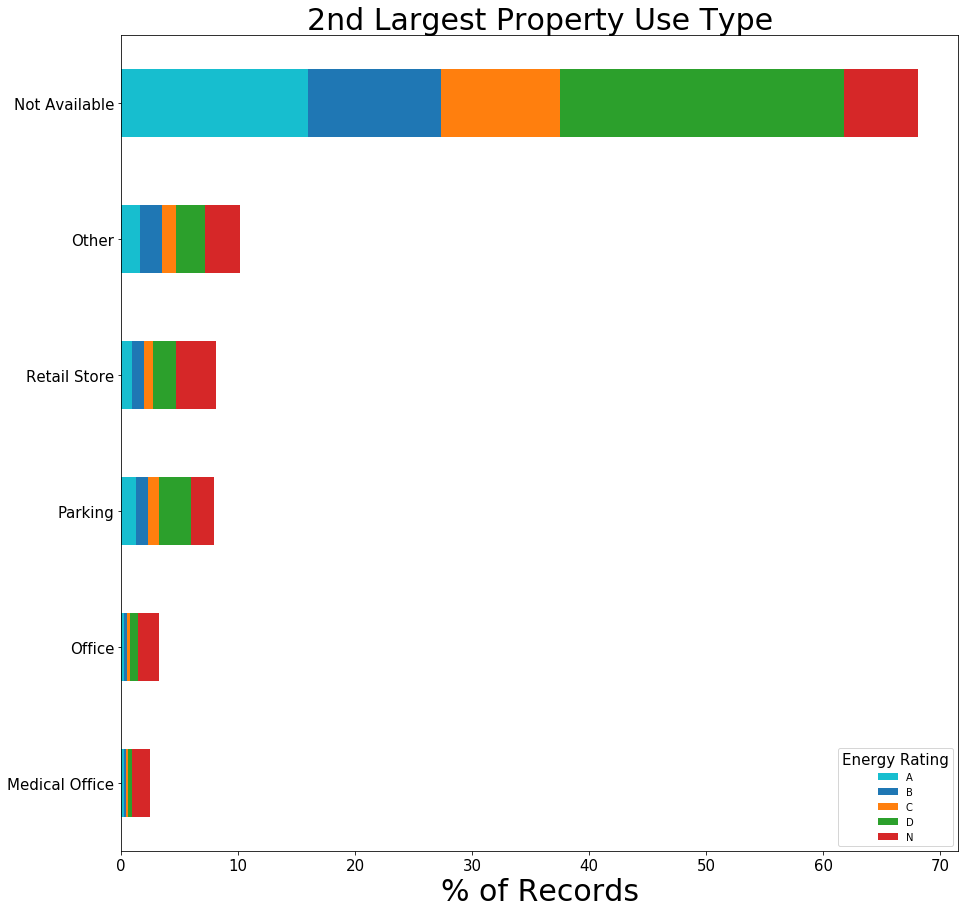

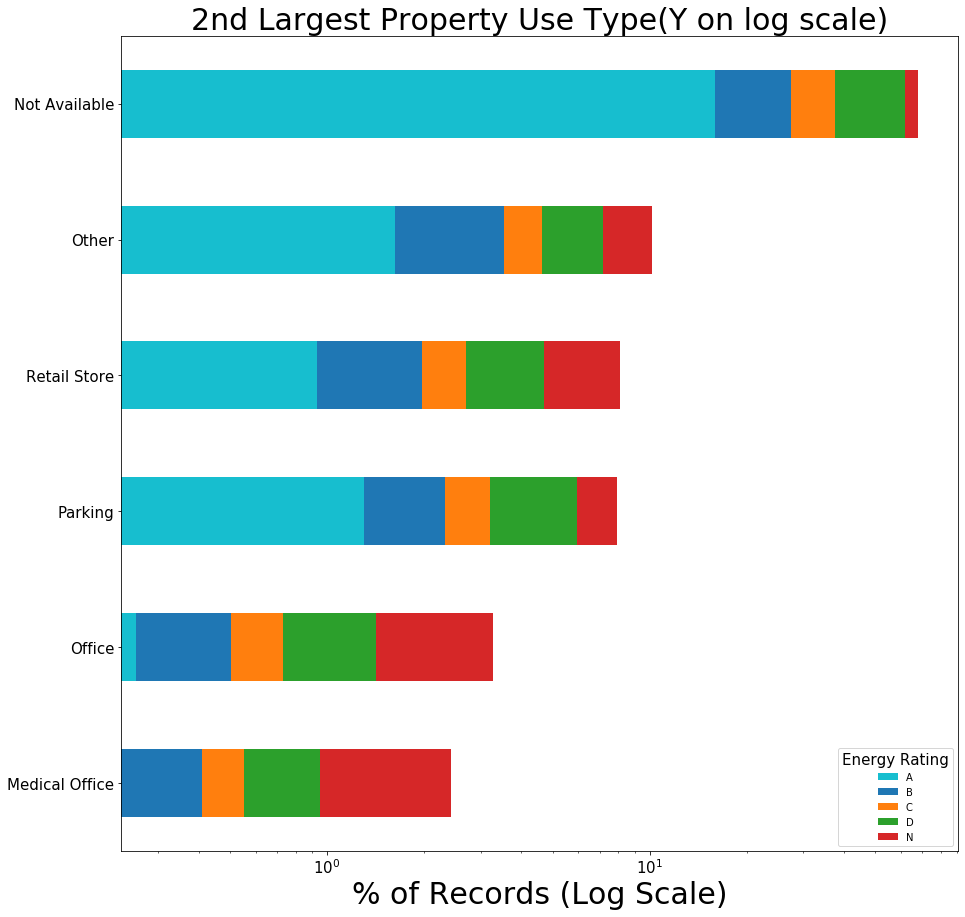

In [15]:
plot_cat('2nd Largest Property Use Type')

<h3> 4] For '3rd Largest Property Use Type' </h3>

['Not Available', 'Retail Store', 'Other', 'Parking', 'Office', 'Medical Office', 'Restaurant', 'Supermarket/Grocery Store', 'Financial Office', 'Bank Branch']


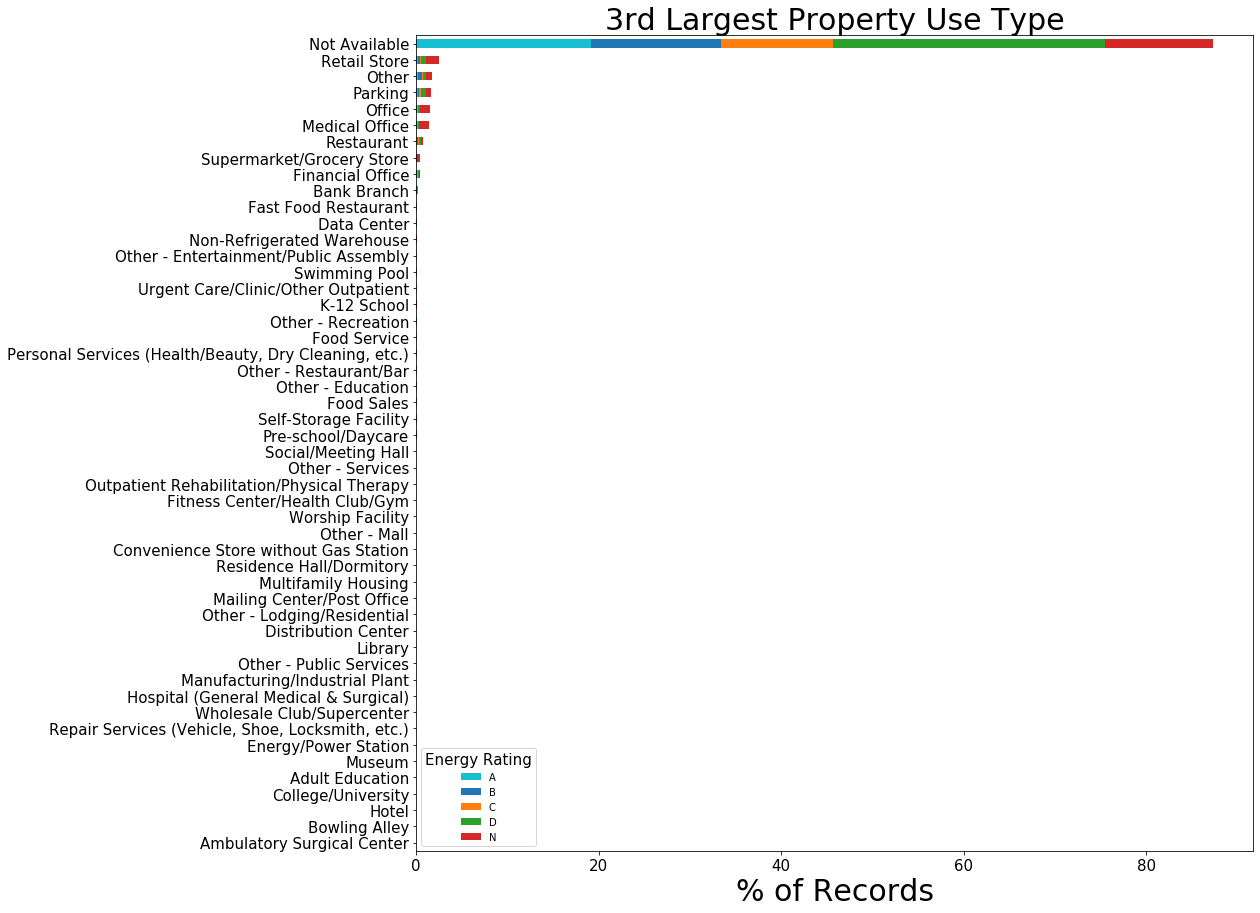

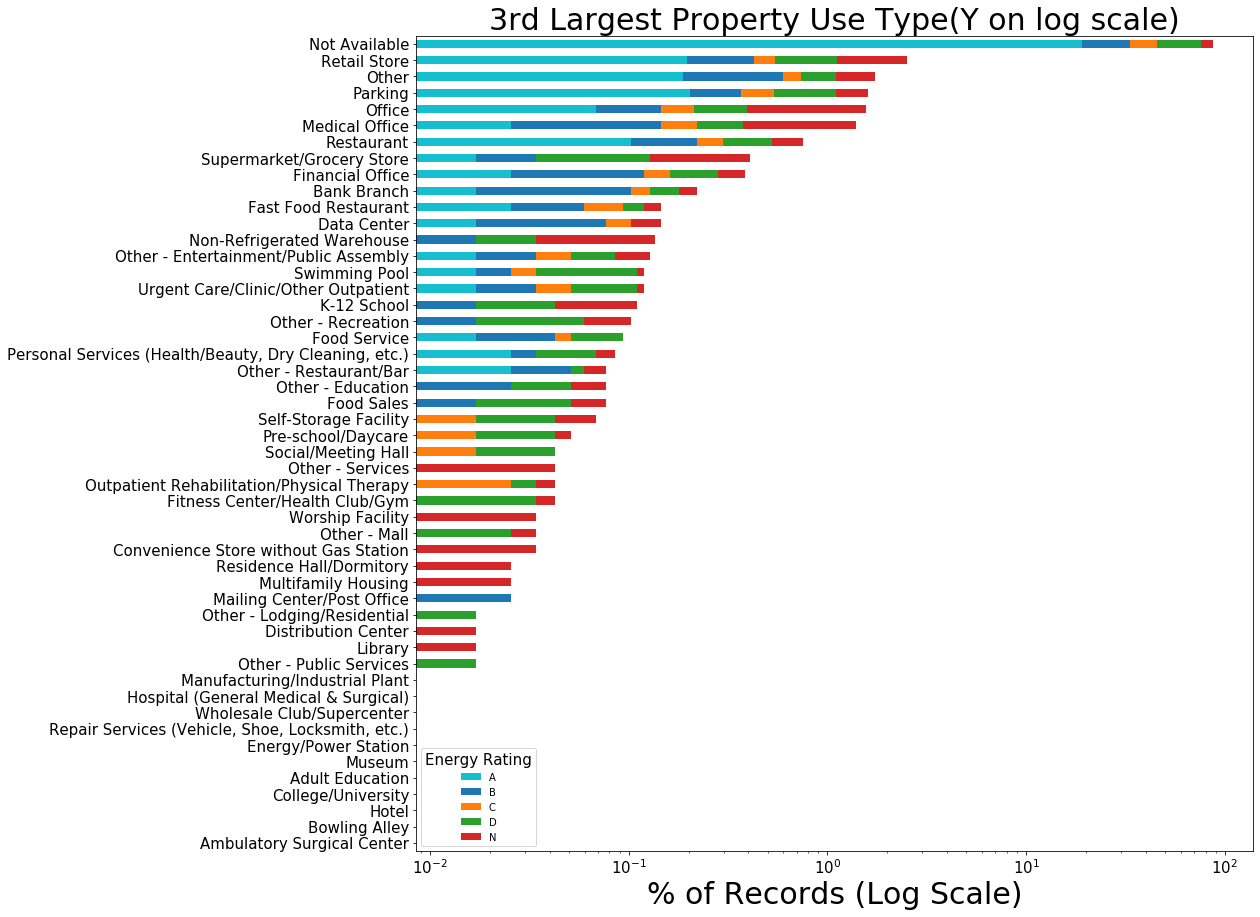

In [16]:
plot_cat('3rd Largest Property Use Type')
category['3rd Largest Property Use Type']=category['3rd Largest Property Use Type'].apply(lambda x:x if x in ['Not Available', 'Retail Store', 'Other', 'Parking', 'Office', 'Medical Office', 'Restaurant'] else 'Other')

<p>It is evident from the above plot that only 'Not Available', 'Retail Store', 'Other', 'Parking', 'Office', 'Medical Office', 'Restaurant' values have more records so we will move all other values into a necategory 'others' </p><br>
<p>Plots after restructuring</p>

['Not Available', 'Other', 'Retail Store', 'Parking', 'Office', 'Medical Office', 'Restaurant']


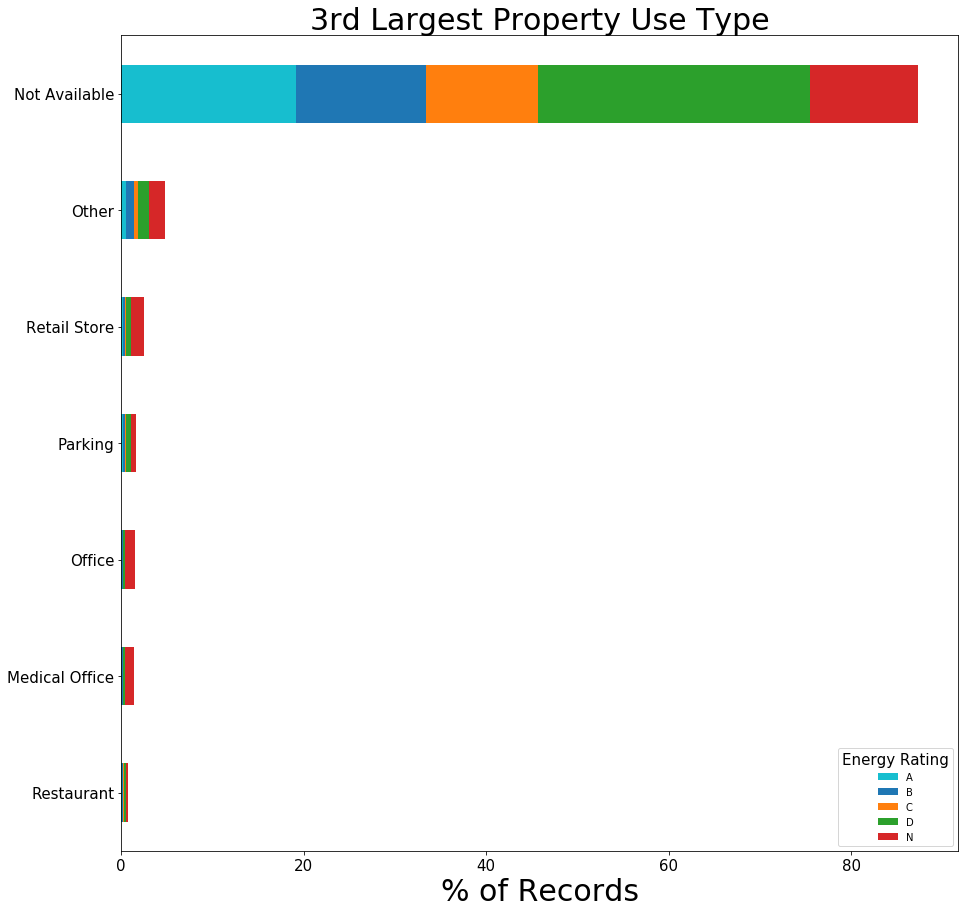

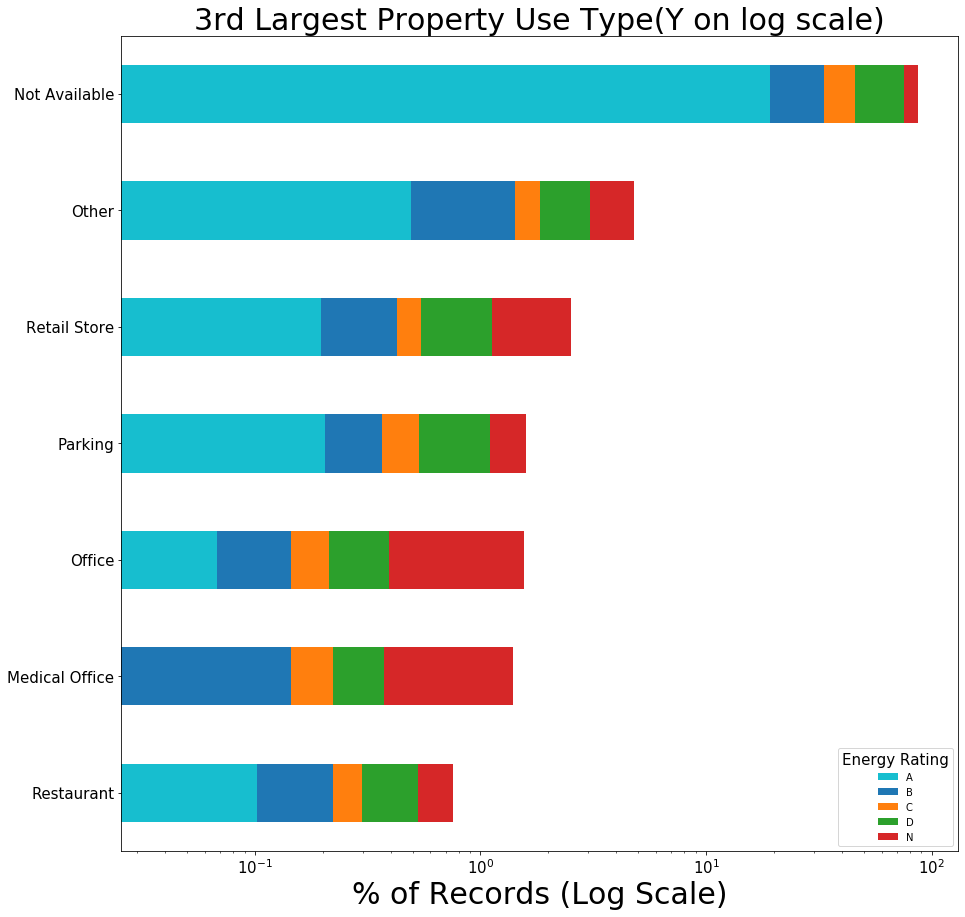

In [17]:
plot_cat('3rd Largest Property Use Type')

<h3> 5] For 'Metered Areas (Energy)' </h3>

['Whole Building', 'Not Available', 'Another configuration', 'Common areas only', 'Tenant Cooling, Common Area Hot Water, Common Area Heating, Common Area Plug Load/Electricity', 'Tenant areas only', 'Tenant Plug Load/Electricity, Common Area Cooling, Tenant Cooling, Common Area Plug Load/Electricity', 'Common Area Cooling, Tenant Plug Load/Electricity, Tenant Cooling, Common Area Plug Load/Electricity']


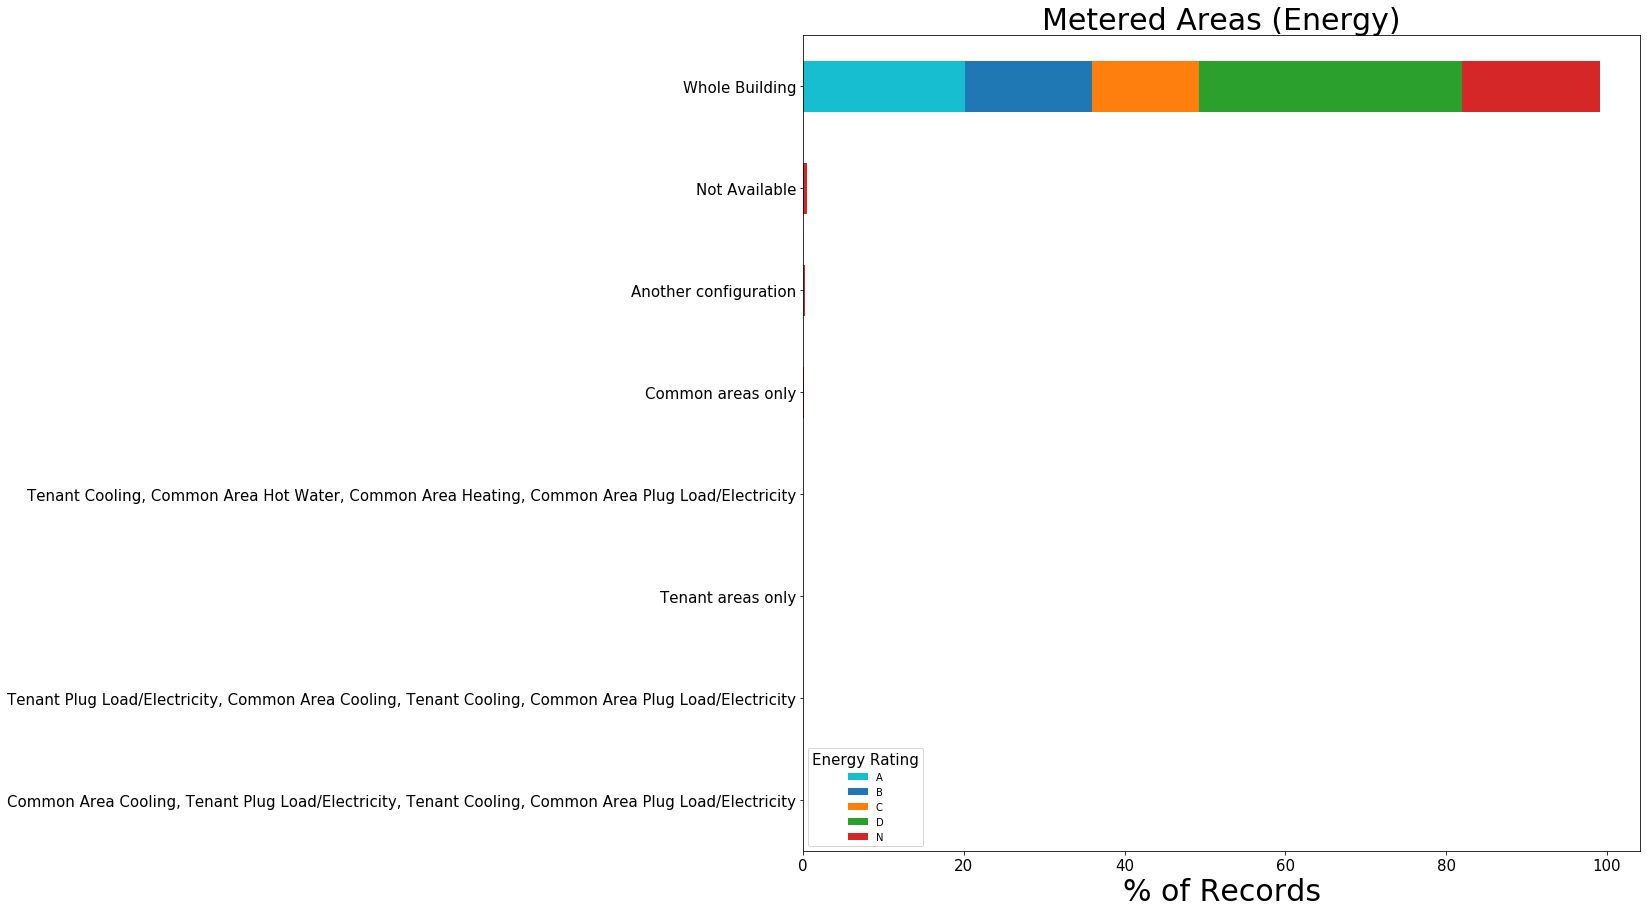

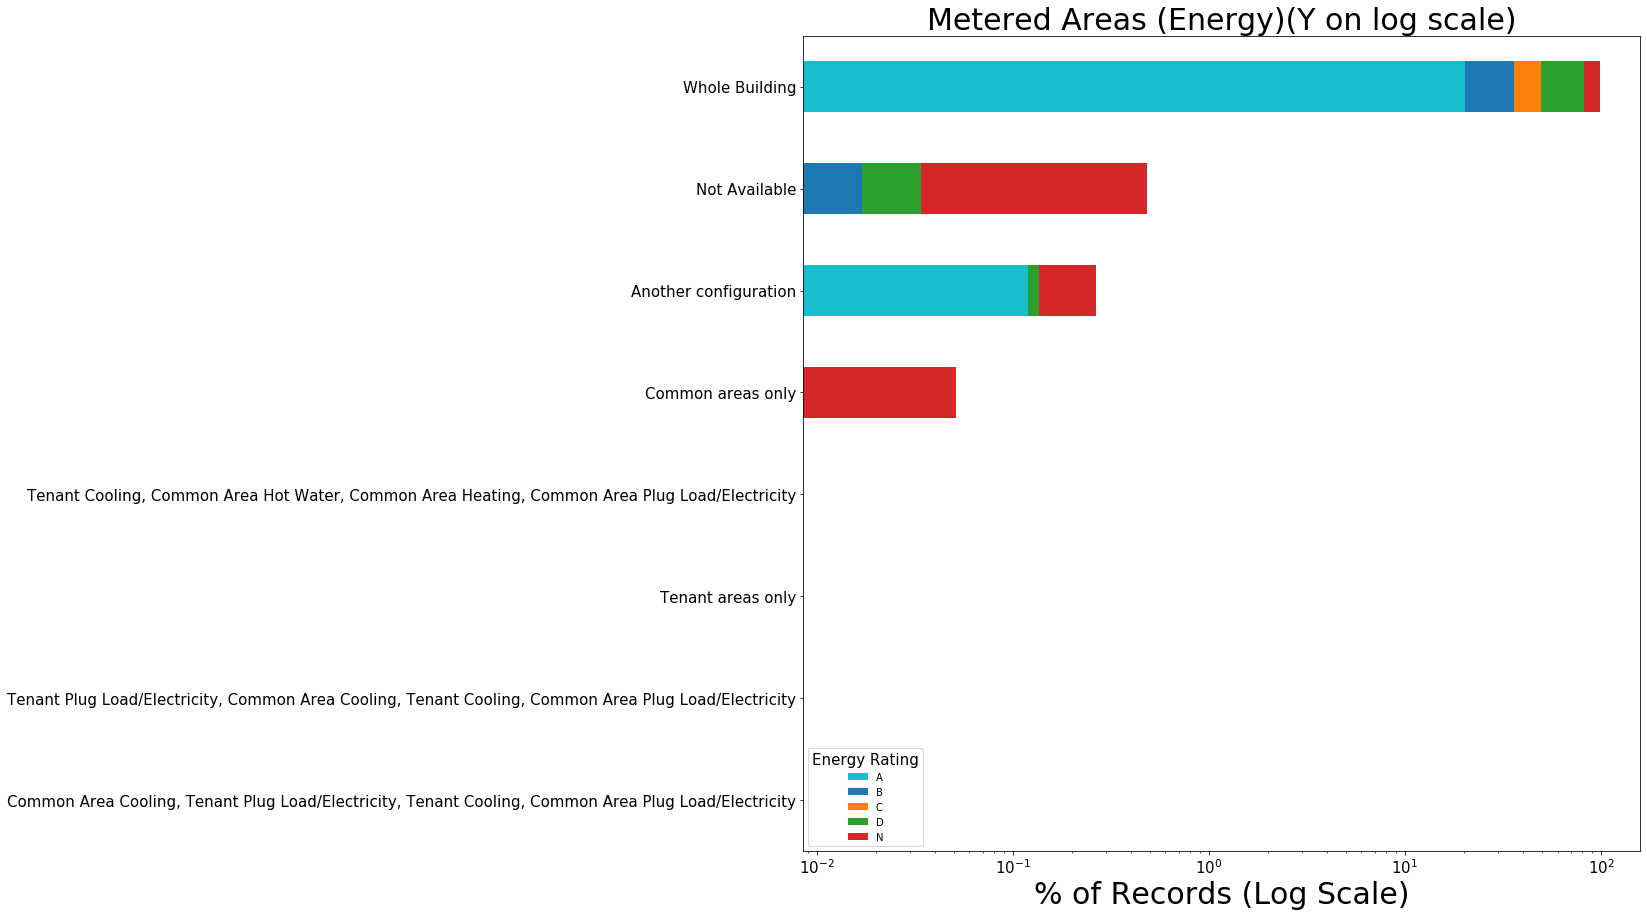

In [18]:
plot_cat('Metered Areas (Energy)')
category['Metered Areas (Energy)']=category['Metered Areas (Energy)'].apply(lambda x:x if x in ['Whole Building', 'Not Available', 'Another configuration','Common areas only'] else 'Other')

<p>It is evident from the above plot that only 'Whole Building', 'Not Available', 'Another configuration','Common areas only' values have more records so we will move all other values into a necategory 'others' </p><br>
<p>Plots after restructuring</p>

['Whole Building', 'Not Available', 'Another configuration', 'Common areas only', 'Other']


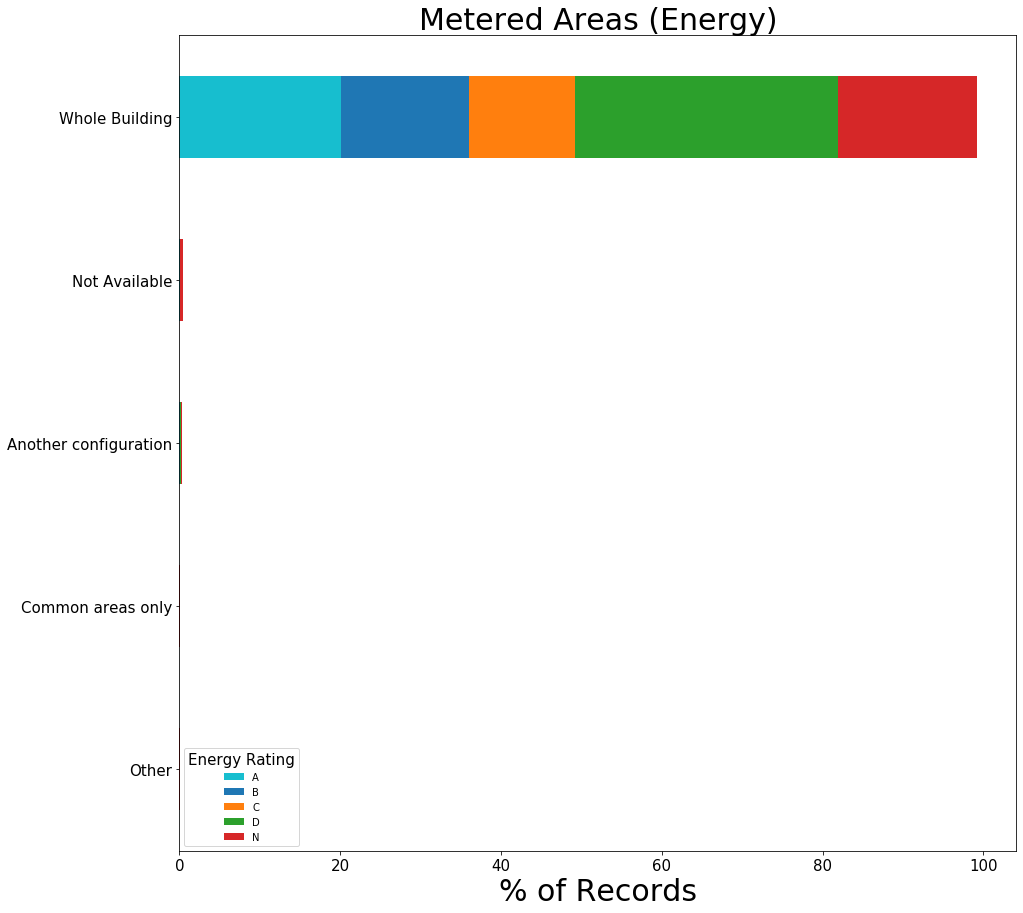

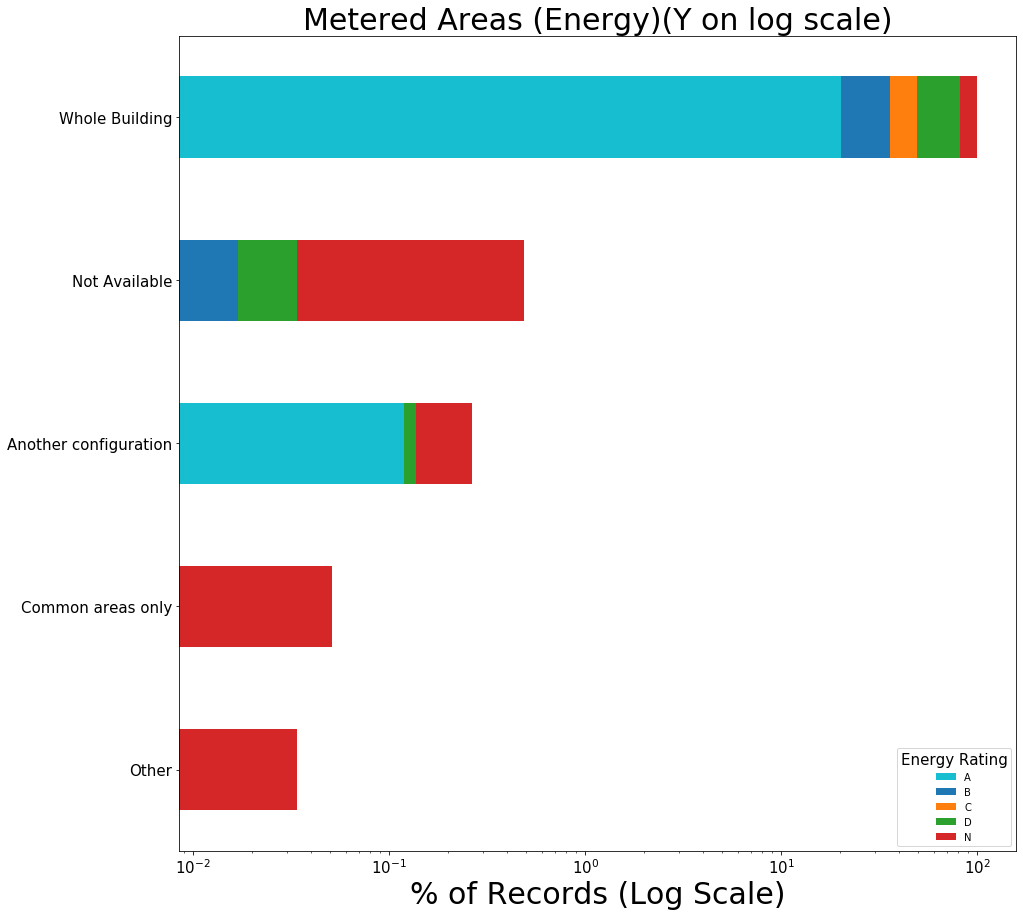

In [19]:
plot_cat('Metered Areas (Energy)')

<h3> 6] For 'Metered Areas (Energy)' </h3>

['Whole Building', 'Not Available', 'Combination of common and tenant areas', 'Common areas only', 'Another configuration', 'Tenant areas only', 'Tenant areas (all energy loads)']


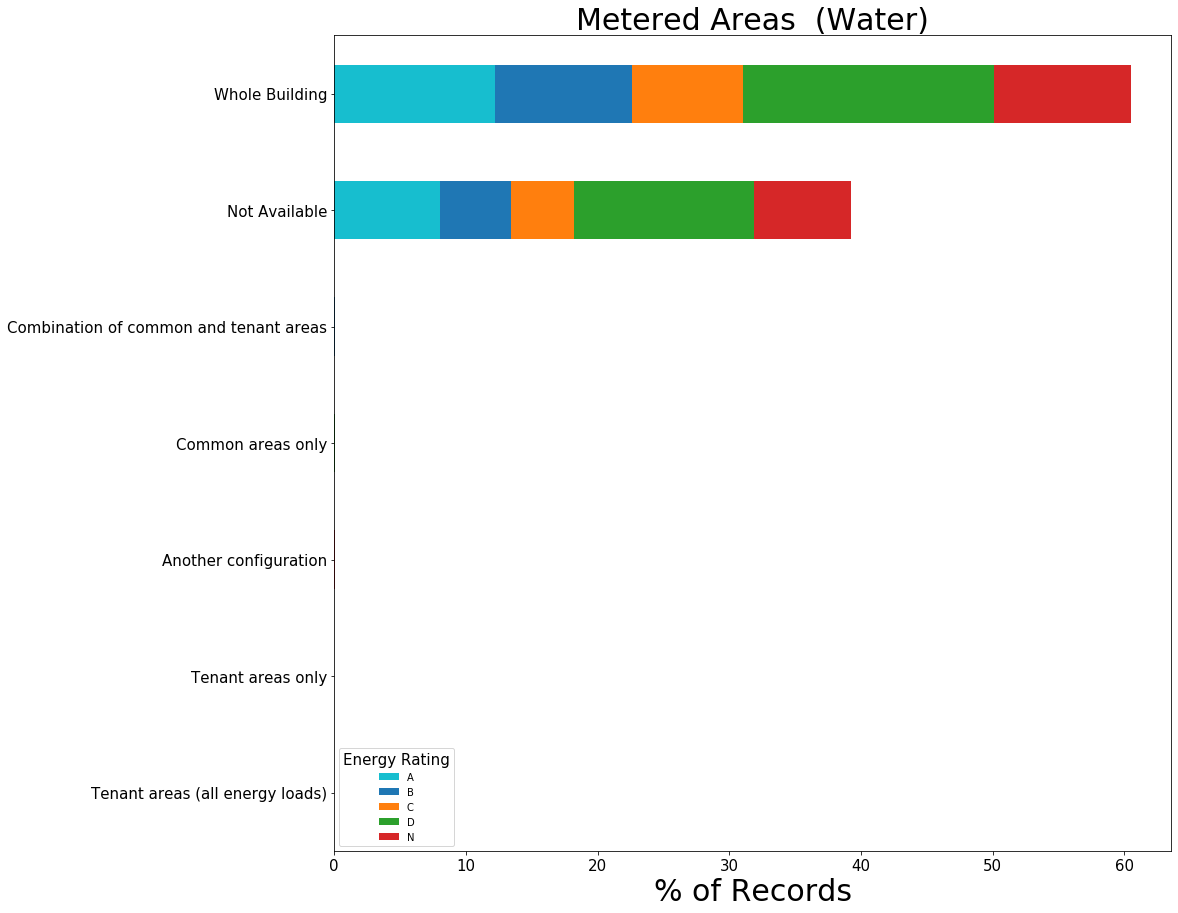

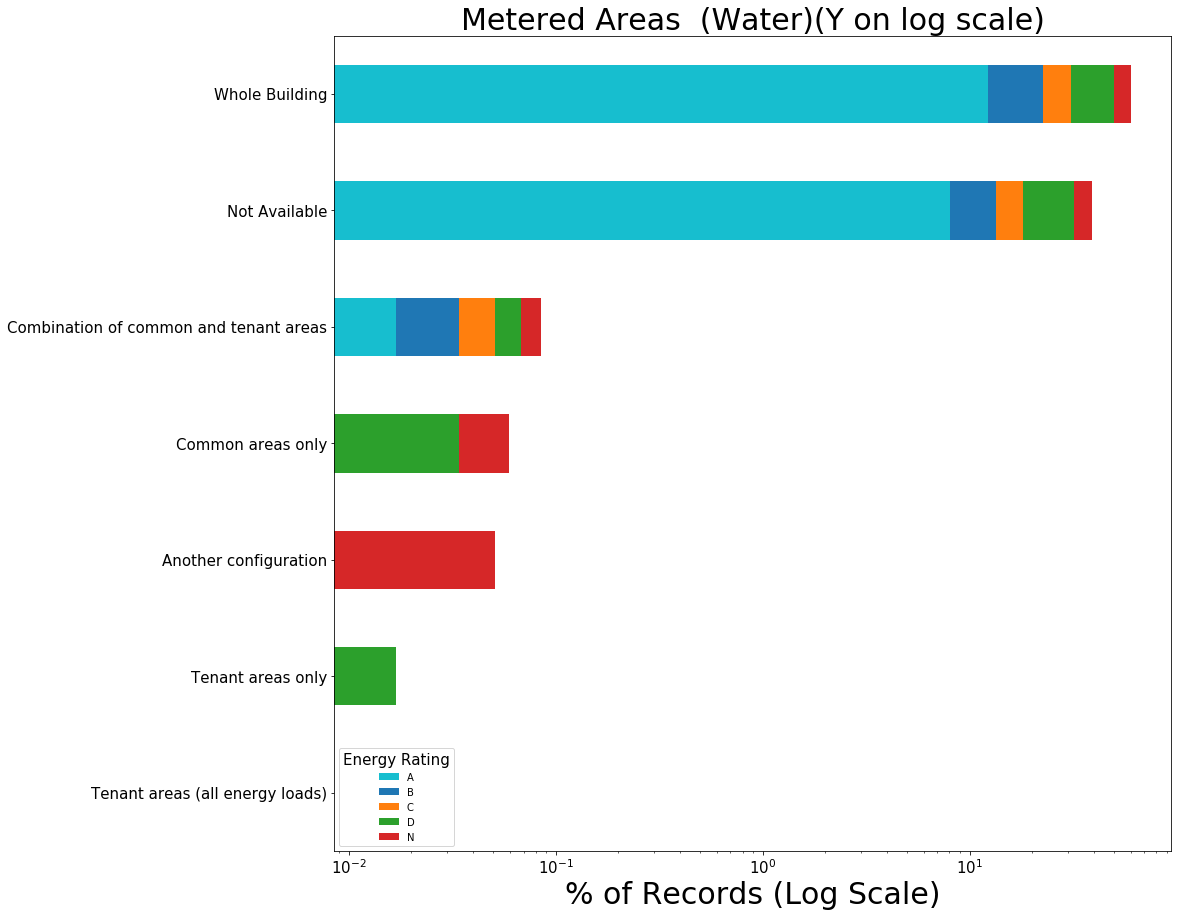

In [20]:
plot_cat('Metered Areas  (Water)')
category['Metered Areas  (Water)']=category['Metered Areas  (Water)'].apply(lambda x:x if x in ['Whole Building', 'Not Available'] else 'Other')

<p>It is evident from the above plot that only 'Whole Building', 'Not Available' values have more records so we will move all other values into a necategory 'others' </p><br>
<p>Plots after restructuring</p>

['Whole Building', 'Not Available', 'Other']


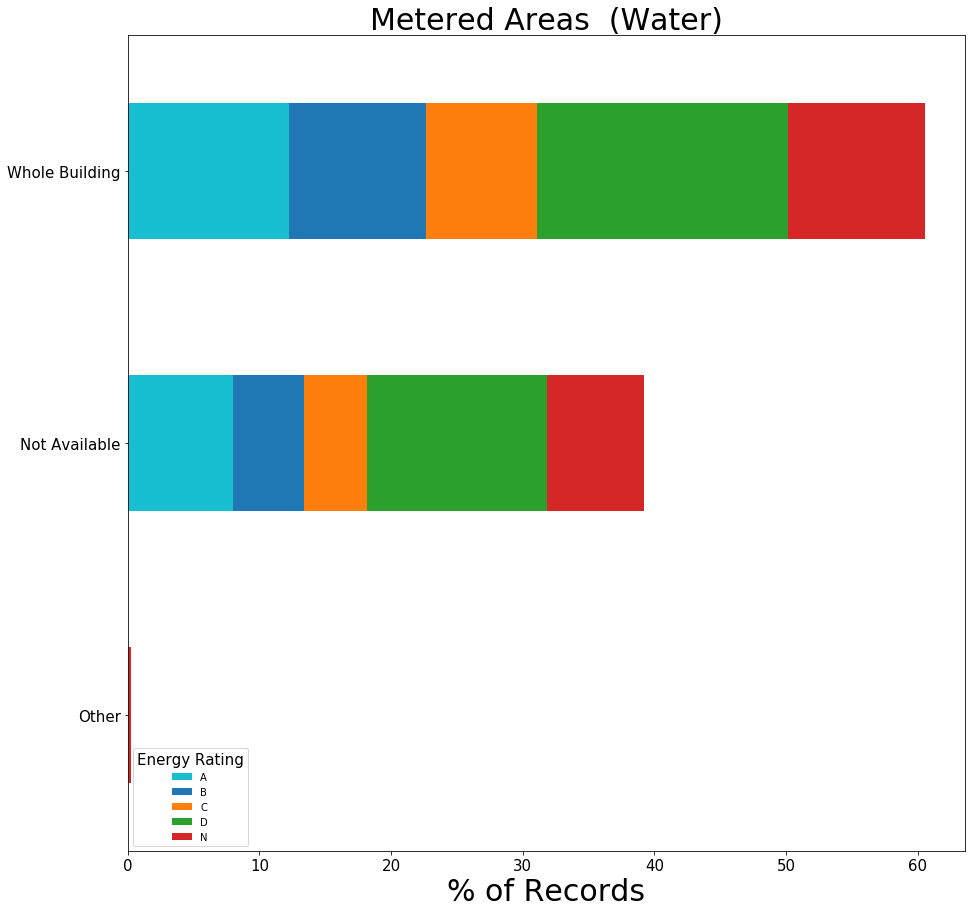

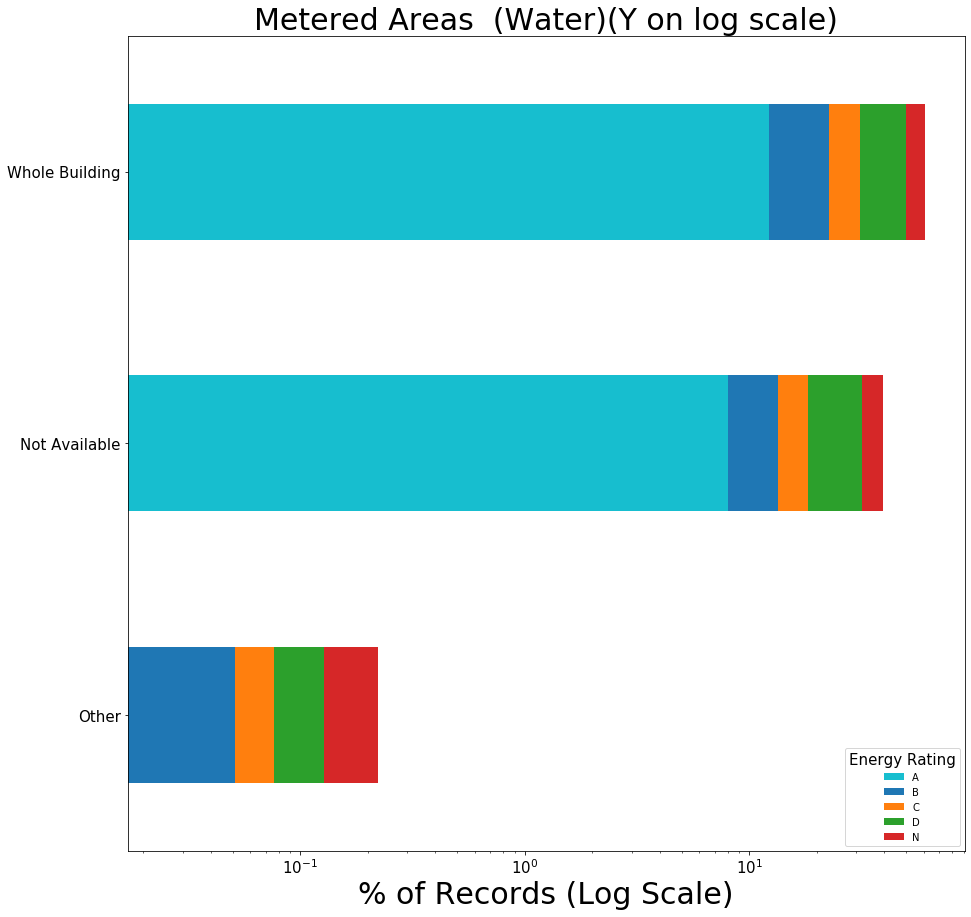

In [21]:
plot_cat('Metered Areas  (Water)')

<h3> 7] For 'NTA' </h3>

['Not Available', 'Midtown-Midtown South', 'Upper East Side-Carnegie Hill', 'Upper West Side', 'Hudson Yards-Chelsea-Flatiron-Union Square', 'Turtle Bay-East Midtown', 'West Village', 'SoHo-TriBeCa-Civic Center-Little Italy', 'Flatbush', 'Lenox Hill-Roosevelt Island', 'Murray Hill-Kips Bay', 'Lincoln Square', 'Battery Park City-Lower Manhattan', 'Morningside Heights', 'Washington Heights North', 'Washington Heights South', 'Yorkville', 'Clinton', 'Prospect Lefferts Gardens-Wingate', 'Van Cortlandt Village', 'Spuyten Duyvil-Kingsbridge', 'West Concourse', 'Bay Ridge', 'Midwood', 'Norwood', 'Bedford Park-Fordham North', 'University Heights-Morris Heights', 'East Concourse-Concourse Village', 'Gramercy', 'Mount Hope']


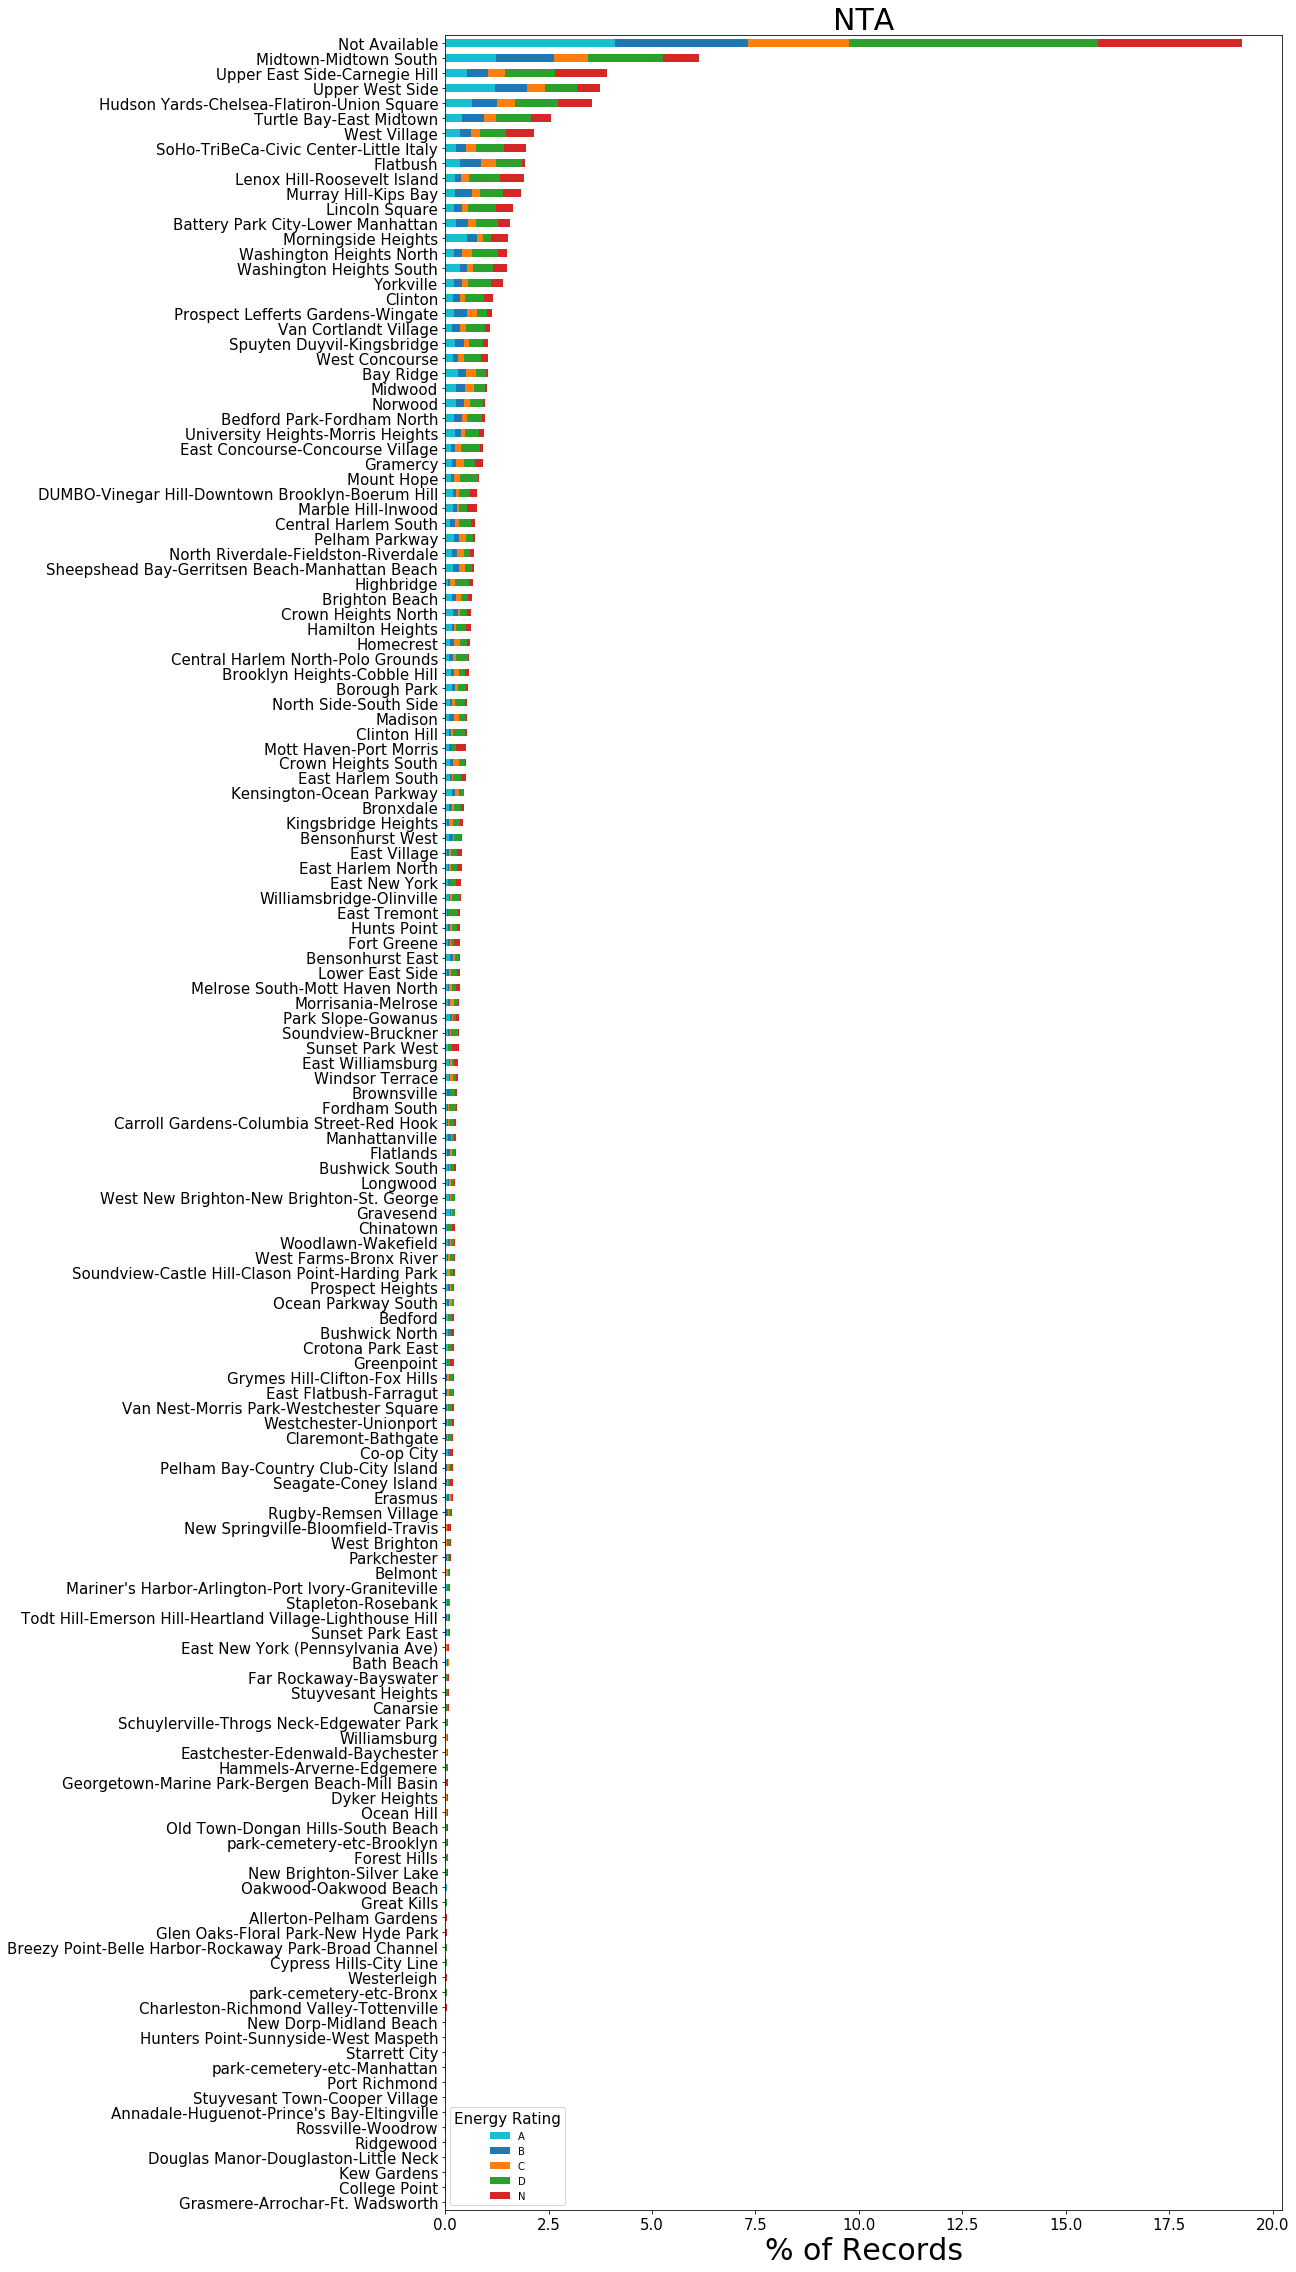

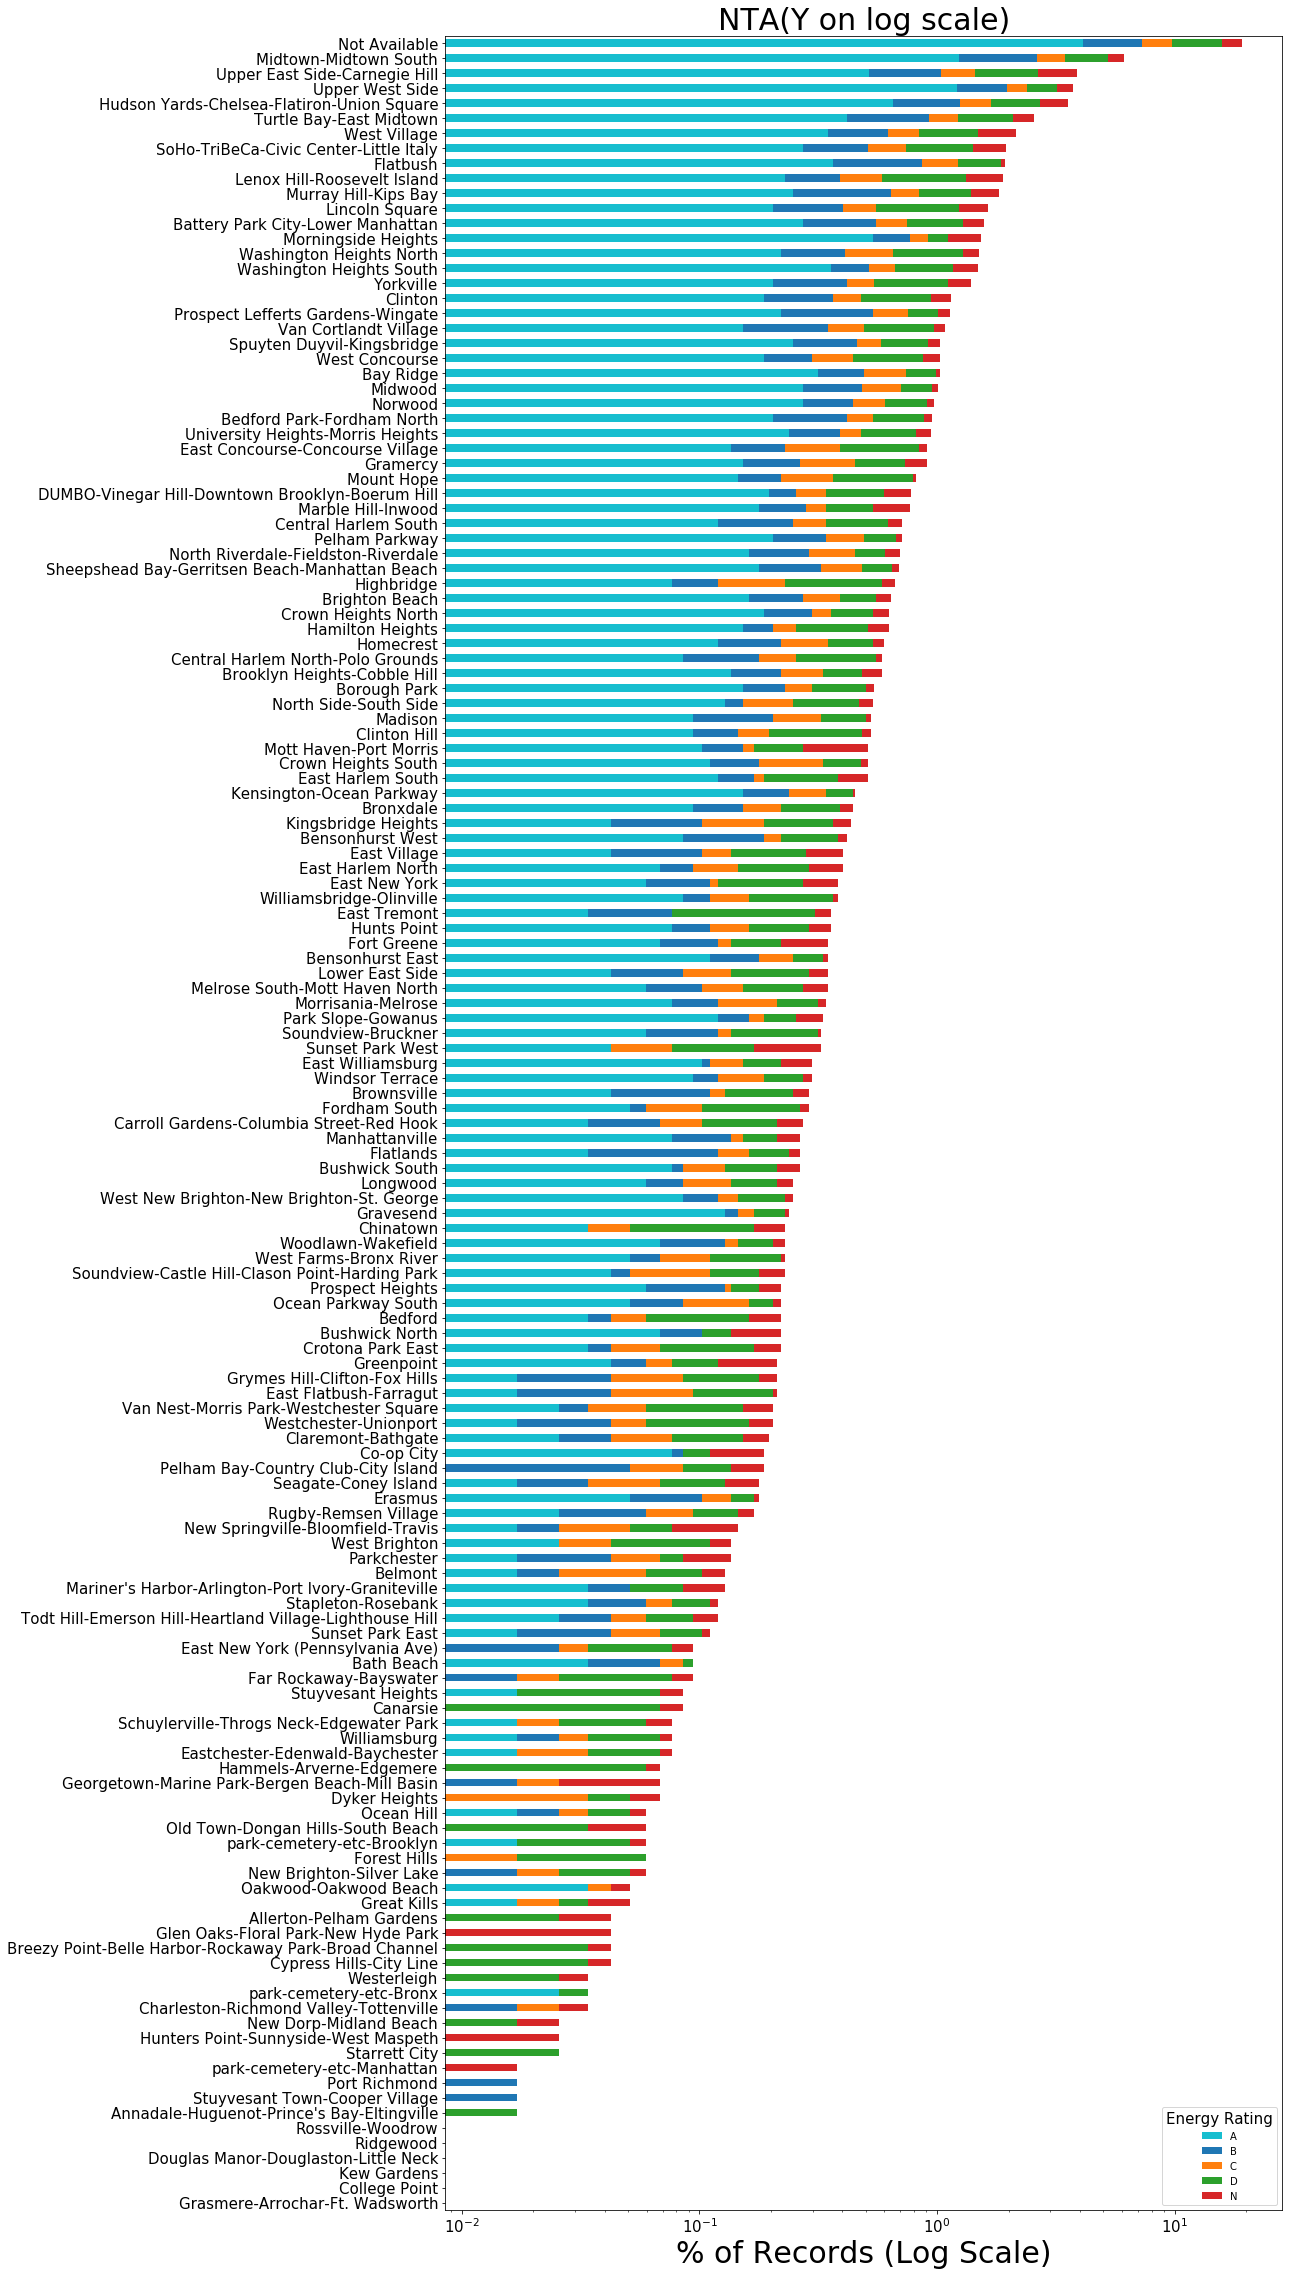

In [22]:
plot_cat_long('NTA')
lst_inc=['Not Available', 'Midtown-Midtown South', 'Upper East Side-Carnegie Hill', 'Upper West Side', 'Hudson Yards-Chelsea-Flatiron-Union Square', 'Turtle Bay-East Midtown', 'West Village', 'SoHo-TriBeCa-Civic Center-Little Italy', 'Flatbush', 'Lenox Hill-Roosevelt Island', 'Murray Hill-Kips Bay', 'Lincoln Square', 'Battery Park City-Lower Manhattan', 'Morningside Heights', 'Washington Heights North', 'Washington Heights South', 'Yorkville', 'Clinton', 'Prospect Lefferts Gardens-Wingate', 'Van Cortlandt Village', 'West Concourse', 'Bay Ridge', 'Spuyten Duyvil-Kingsbridge', 'Midwood', 'Norwood', 'Bedford Park-Fordham North', 'University Heights-Morris Heights', 'Gramercy', 'East Concourse-Concourse Village', 'Mount Hope']
category['NTA']=category['NTA'].apply(lambda x:x if x in lst_inc else 'Other')


<p>It is evident from the above plot that only 'Not Available', 'Midtown-Midtown South', 'Upper East Side-Carnegie Hill', 'Upper West Side', 'Hudson Yards-Chelsea-Flatiron-Union Square', 'Turtle Bay-East Midtown', 'West Village', 'SoHo-TriBeCa-Civic Center-Little Italy', 'Flatbush', 'Lenox Hill-Roosevelt Island', 'Murray Hill-Kips Bay', 'Lincoln Square', 'Battery Park City-Lower Manhattan', 'Morningside Heights', 'Washington Heights North', 'Washington Heights South', 'Yorkville', 'Clinton', 'Prospect Lefferts Gardens-Wingate', 'Van Cortlandt Village', 'West Concourse', 'Bay Ridge', 'Spuyten Duyvil-Kingsbridge', 'Midwood', 'Norwood', 'Bedford Park-Fordham North', 'University Heights-Morris Heights', 'Gramercy', 'East Concourse-Concourse Village', 'Mount Hope' values have more records so we will move all other values into a necategory 'others' </p><br>
<p>Plots after restructuring</p>

['Other', 'Not Available', 'Midtown-Midtown South', 'Upper East Side-Carnegie Hill', 'Upper West Side', 'Hudson Yards-Chelsea-Flatiron-Union Square', 'Turtle Bay-East Midtown', 'West Village', 'SoHo-TriBeCa-Civic Center-Little Italy', 'Flatbush', 'Lenox Hill-Roosevelt Island', 'Murray Hill-Kips Bay', 'Lincoln Square', 'Battery Park City-Lower Manhattan', 'Morningside Heights', 'Washington Heights North', 'Washington Heights South', 'Yorkville', 'Clinton', 'Prospect Lefferts Gardens-Wingate', 'Van Cortlandt Village', 'Spuyten Duyvil-Kingsbridge', 'West Concourse', 'Bay Ridge', 'Midwood', 'Norwood', 'Bedford Park-Fordham North', 'University Heights-Morris Heights', 'Gramercy', 'East Concourse-Concourse Village']


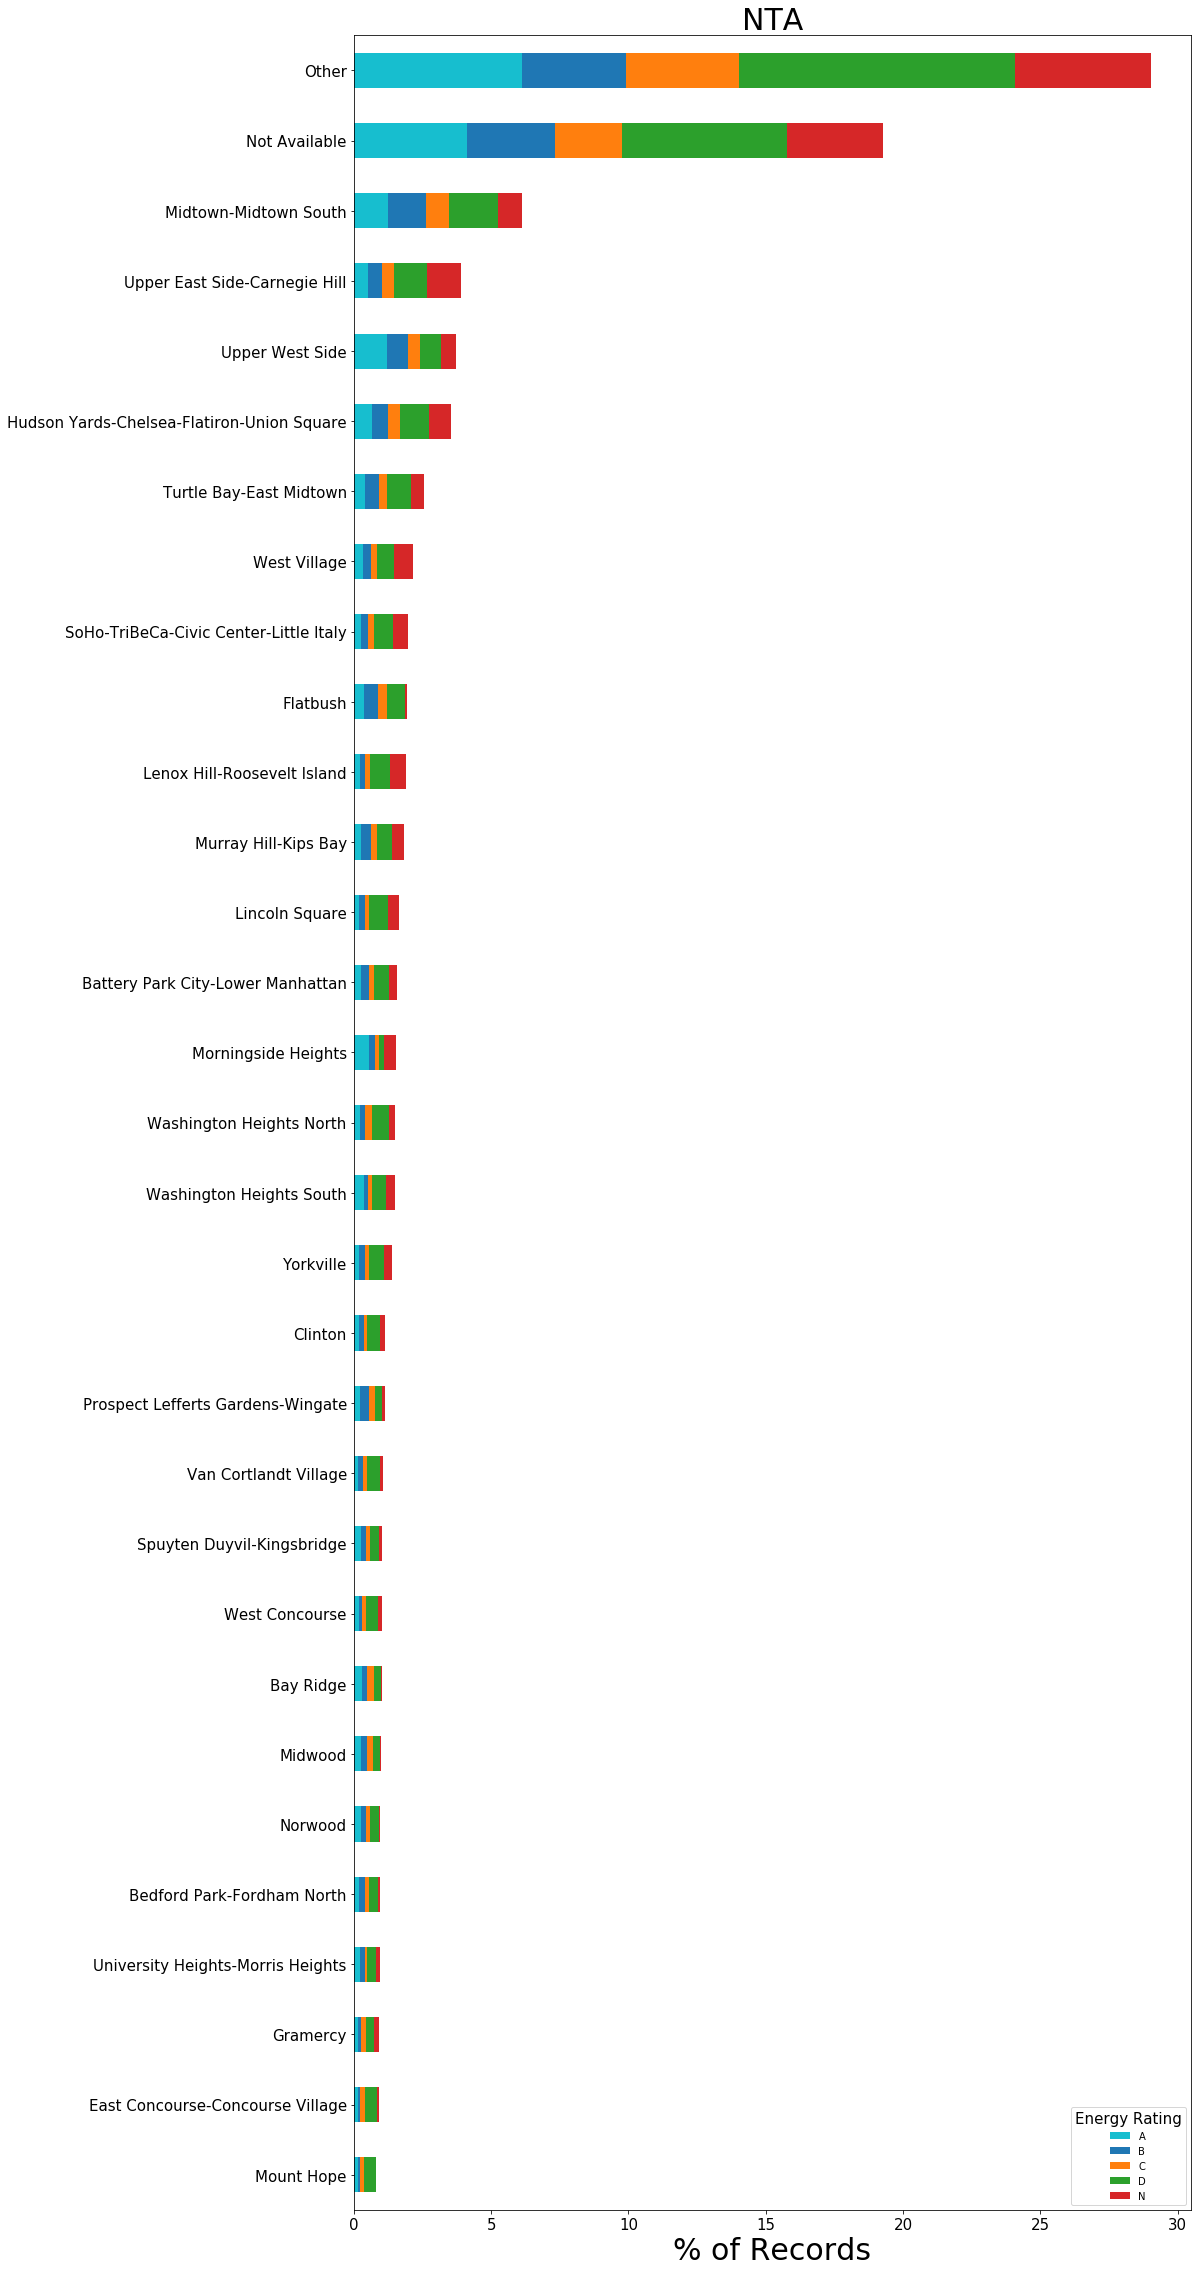

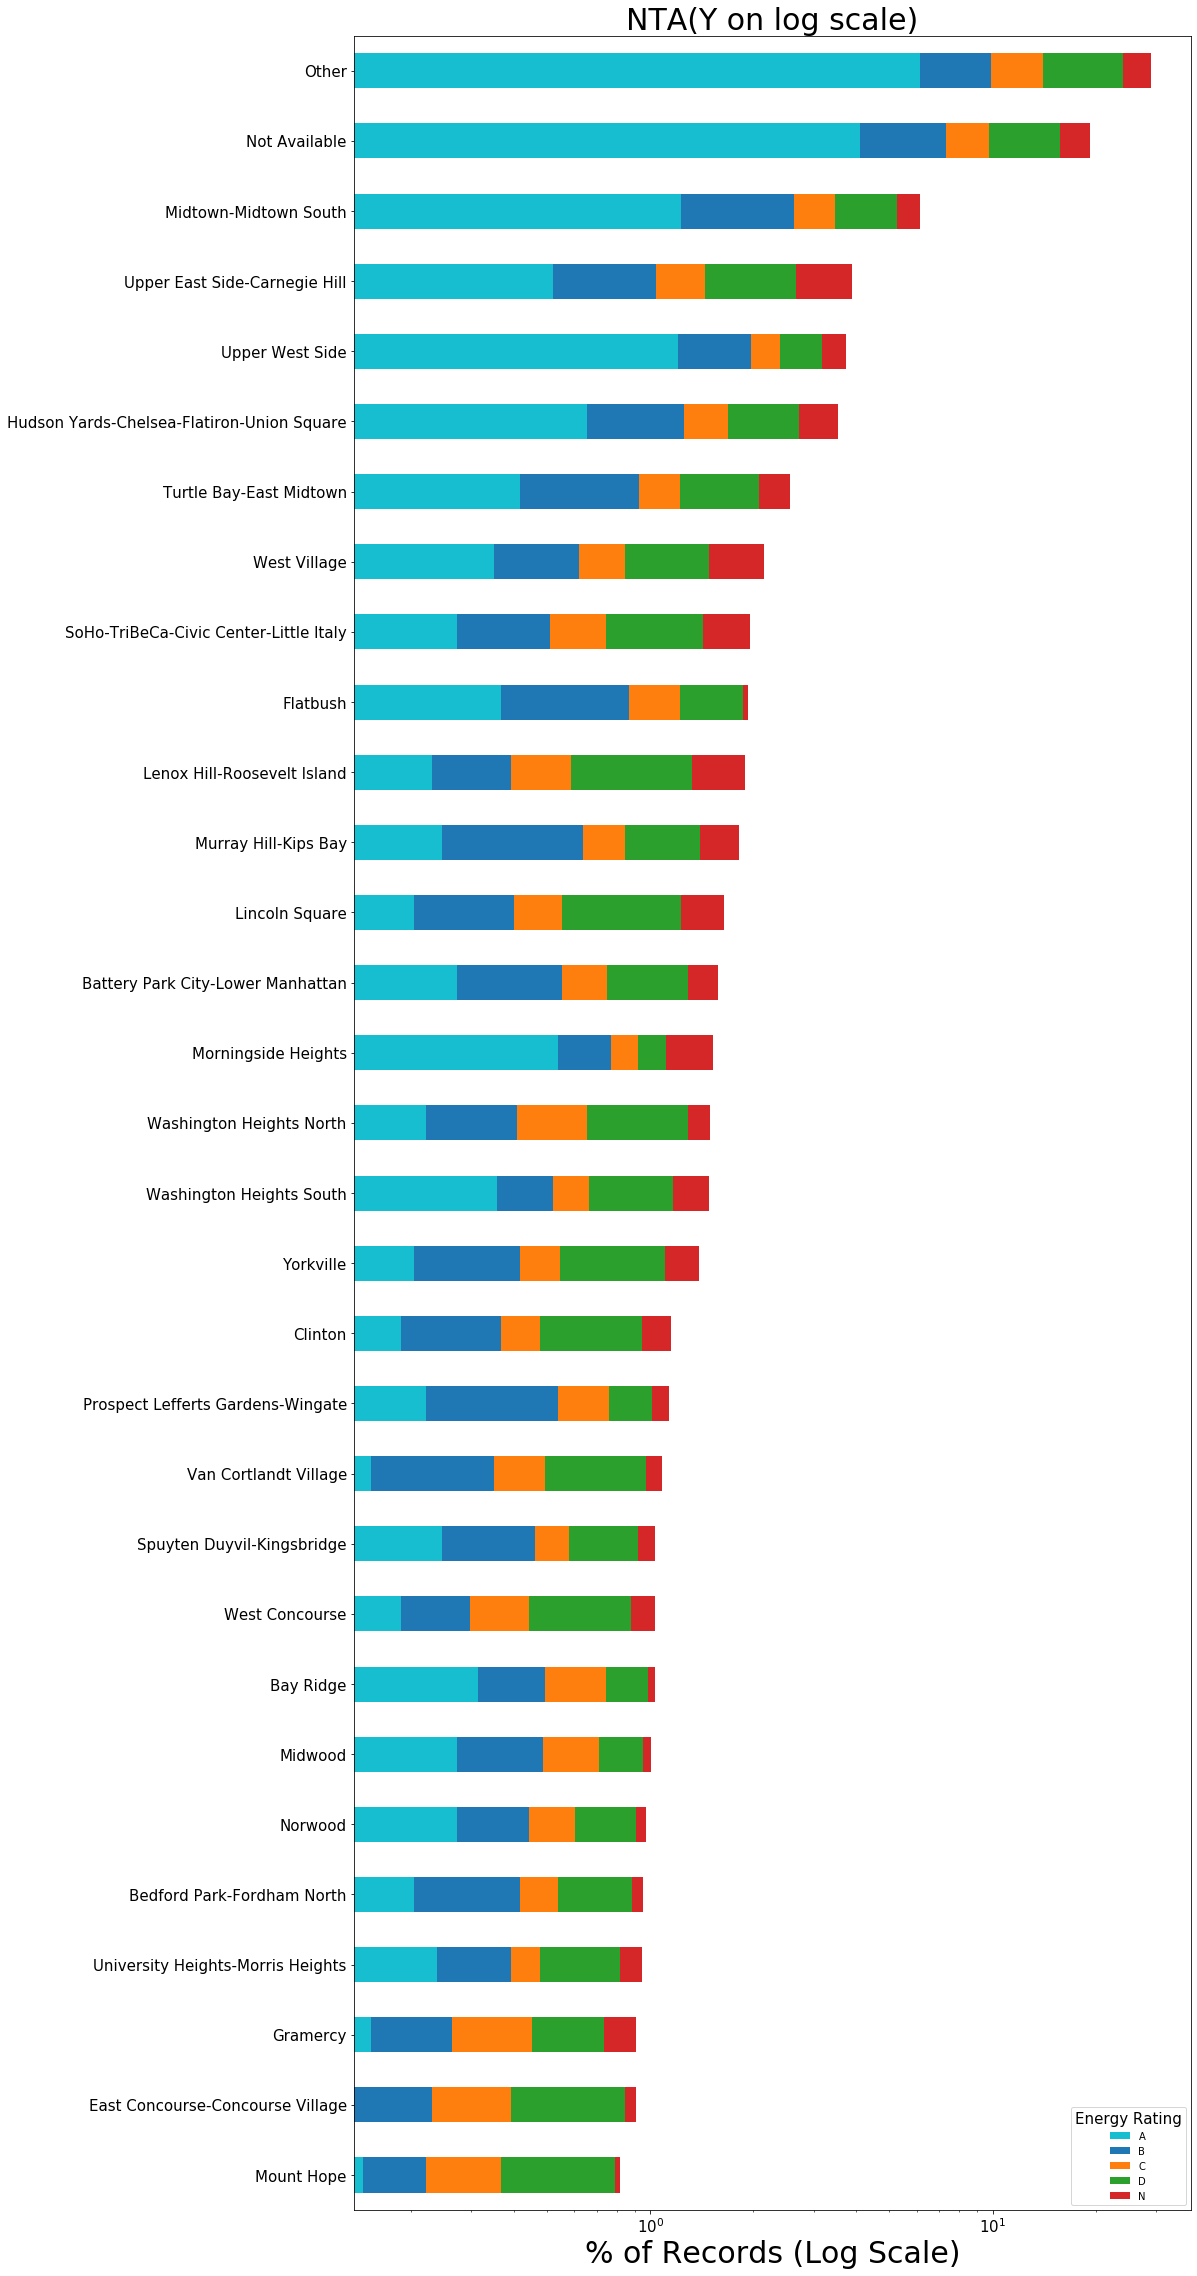

In [23]:
plot_cat_long('NTA')

In [24]:
# order=use_case1.groupby(by=['NTA'],as_index=False).count().iloc[:,0:3]['Order']
# plt.hist(order*100/order.sum(),bins=50)
# plt.gca().set_ylabel('count')
# plt.gca().set_xlabel('Percent')
# plt.gca().set_title('NTA Count Distribution')

<h3> 8] For 'Water Required?' </h3>

['Yes', 'No', 'Not Available']


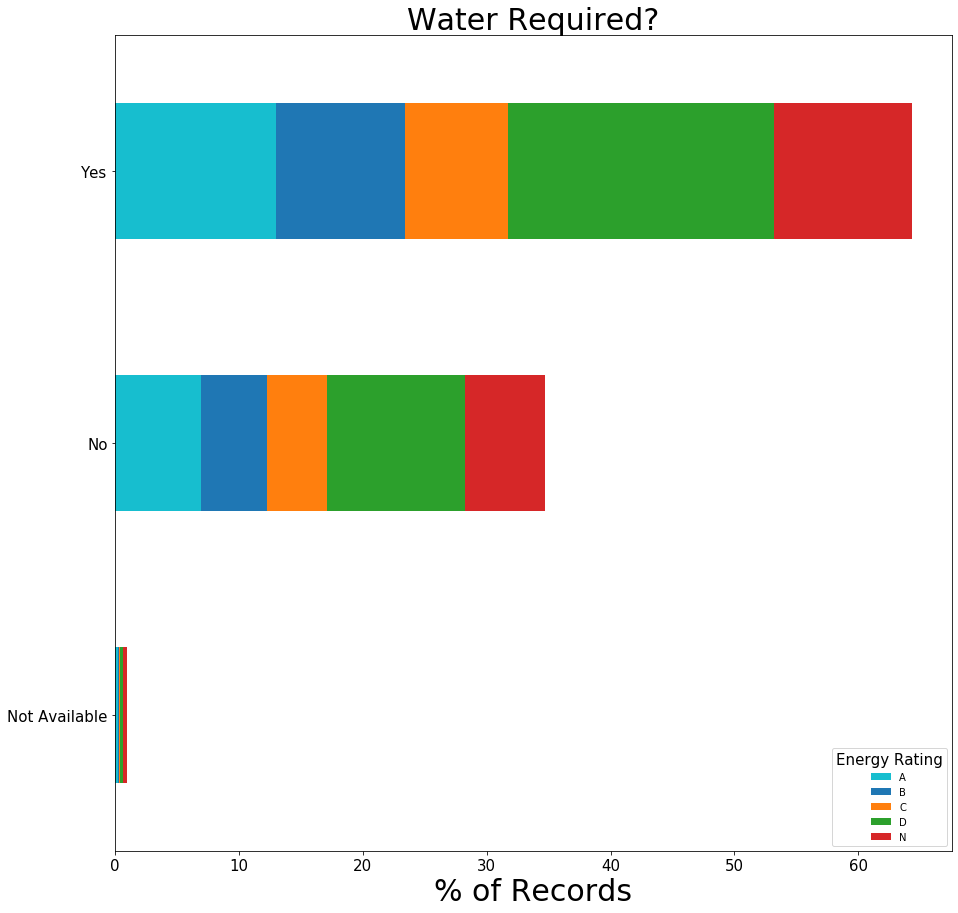

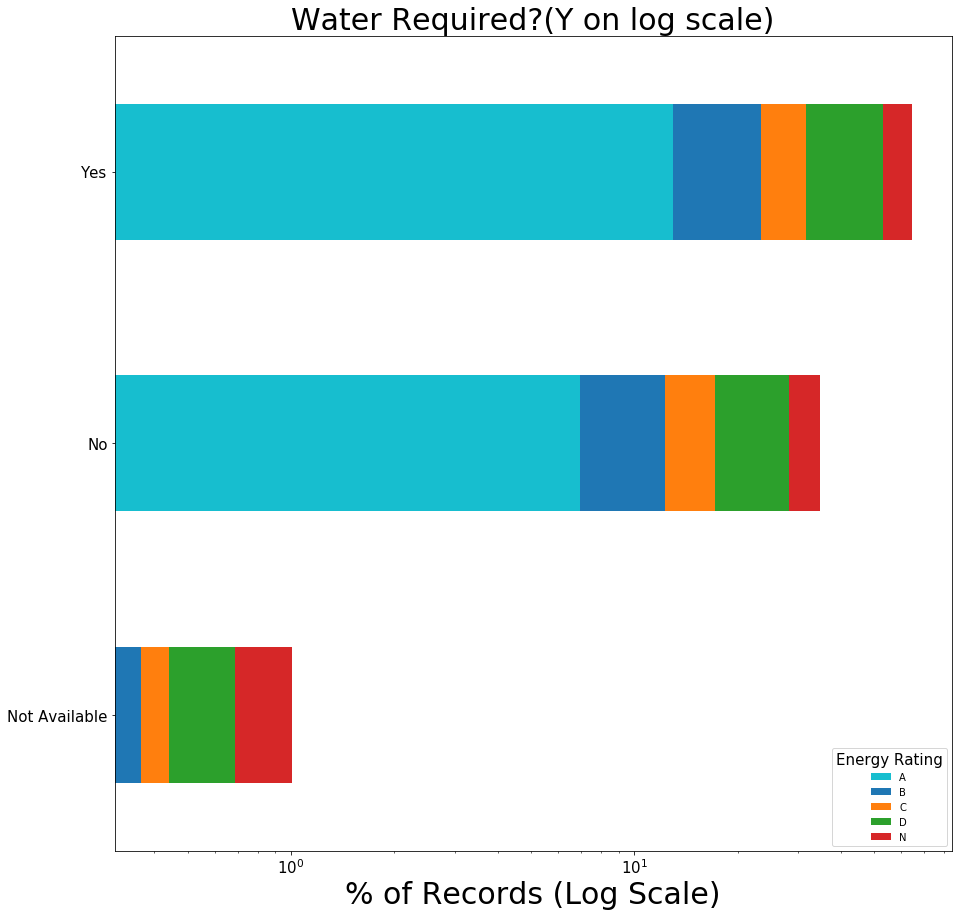

In [25]:
plot_cat('Water Required?')
lst_inc=['Yes', 'No']
category['NTA']=category['NTA'].apply(lambda x:x if x in lst_inc else 'Not Available')

<h3> 9] For 'DOF Benchmarking Submission Status' </h3>

['In Compliance', 'Not Available']


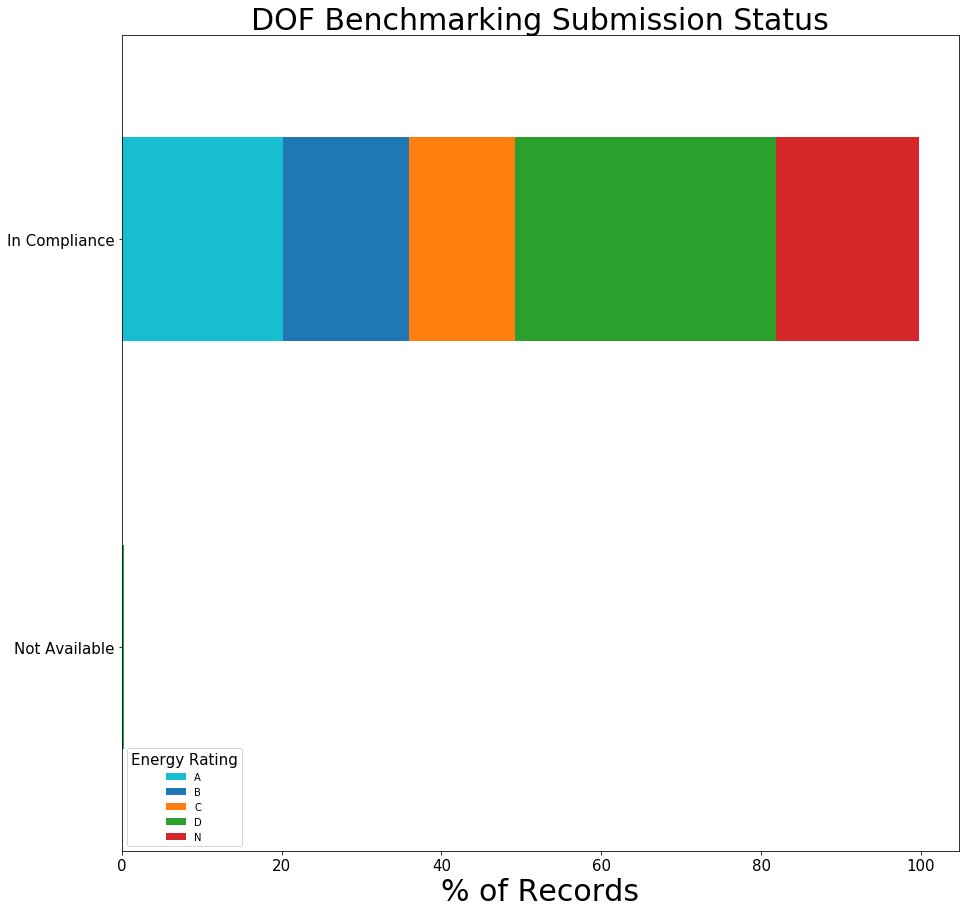

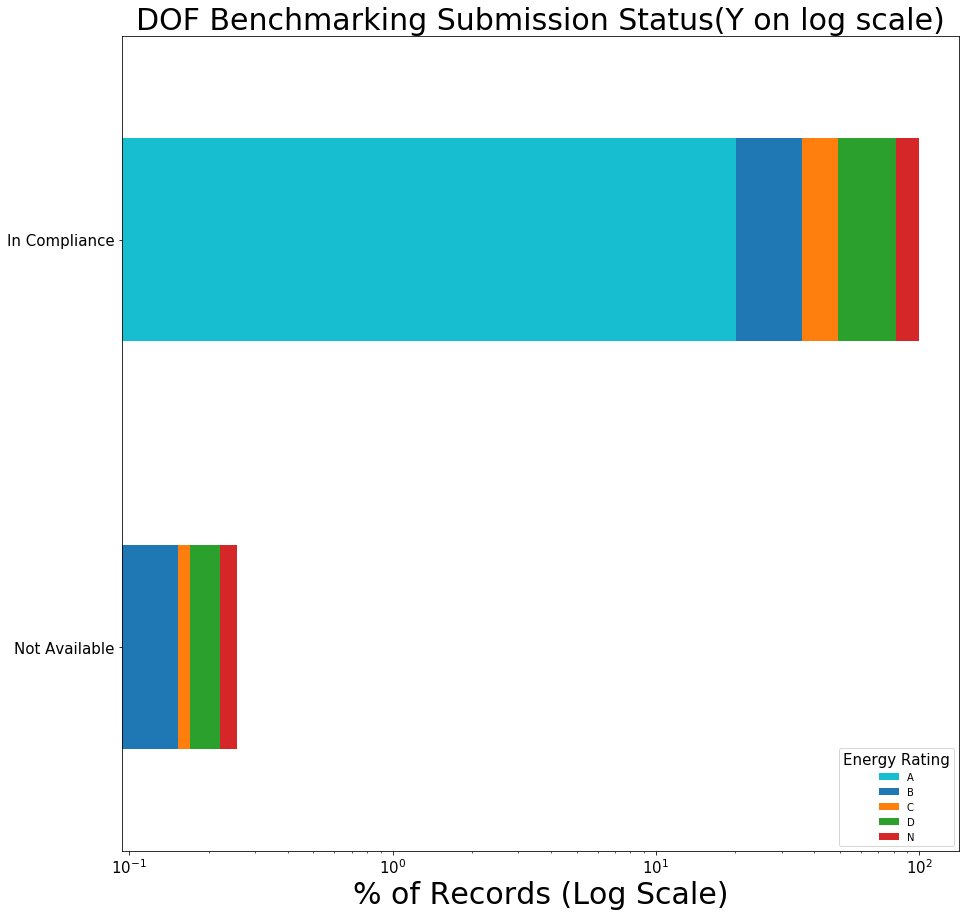

In [26]:
plot_cat('DOF Benchmarking Submission Status')
category['DOF Benchmarking Submission Status']=category['DOF Benchmarking Submission Status'].apply(lambda x:x if x in lst_inc else 'Non Compliance')

In [27]:
date_dat=use_case1[['Year Built','Release Date']]
date_dat['years_since_construction']=pd.DatetimeIndex(date_dat['Release Date']).year-date_dat['Year Built']

In [28]:
date_dat

Year Built            Release Date  years_since_construction
0            1963  05/01/2017 05:32:03 PM                        54
1            1969  04/27/2017 11:23:27 AM                        48
2            1924  04/27/2017 11:23:27 AM                        93
3            1971  04/27/2017 11:23:27 AM                        46
4            1932  04/27/2017 11:23:27 AM                        85
...           ...                     ...                       ...
11741        1928  04/26/2017 11:20:06 AM                        89
11742        1926  04/26/2017 11:20:06 AM                        91
11743        1913  03/23/2017 02:51:02 PM                       104
11744        1928  04/26/2017 11:20:06 AM                        89
11745        1930  04/27/2017 06:37:53 AM                        87

[11746 rows x 3 columns]

In [29]:
category=category[['Primary Property Type - Self Selected',
                    'Largest Property Use Type',
                    '2nd Largest Property Use Type',
                    '3rd Largest Property Use Type',
                    'Metered Areas (Energy)',
                    'Metered Areas  (Water)',
                    'NTA','Water Required?','DOF Benchmarking Submission Status']]

In [30]:
mapping={'x0':'Primary Property Type - Self Selected', 'x1':'Largest Property Use Type',
       'x2':'2nd Largest Property Use Type', 'x3':'3rd Largest Property Use Type',
       'x4':'Metered Areas (Energy)', 'x5':'Metered Areas  (Water)', 'x6':'NTA',
        'x7':'Water Required?','x8':'DOF Benchmarking Submission Status'}

In [31]:
category

Primary Property Type - Self Selected Largest Property Use Type  \
0                                    Office                    Office   
1                                     Other                     Other   
2                                     Other                     Other   
3                                     Other                     Other   
4                                     Other                     Other   
...                                     ...                       ...   
11741                   Multifamily Housing       Multifamily Housing   
11742                   Multifamily Housing       Multifamily Housing   
11743                   Multifamily Housing       Multifamily Housing   
11744                   Multifamily Housing       Multifamily Housing   
11745                   Multifamily Housing       Multifamily Housing   

      2nd Largest Property Use Type 3rd Largest Property Use Type  \
0                     Not Available                 Not Available   
1                     Not Available                 Not Available   
2                     Not Available                 Not Available   
3                     Not Available                 Not Available   
4                     Not Available                 Not Available   
...                             ...                           ...   
11741                 Not Available                 Not Available   
11742                         Other                 Not Available   
11743                 Not Available                 Not Available   
11744                 Not Available                 Not Available   
11745                 Not Available                 Not Available   

      Metered Areas (Energy) Metered Areas  (Water)            NTA  \
0             Whole Building          Not Available  Not Available   
1             Whole Building         Whole Building  Not Available   
2              Not Available          Not Available  Not Available   
3              Not Available          Not Available  Not Available   
4              Not Available          Not Available  Not Available   
...                      ...                    ...            ...   
11741         Whole Building         Whole Building  Not Available   
11742         Whole Building          Not Available  Not Available   
11743         Whole Building          Not Available  Not Available   
11744         Whole Building         Whole Building  Not Available   
11745         Whole Building          Not Available  Not Available   

      Water Required? DOF Benchmarking Submission Status  
0                  No                     Non Compliance  
1                  No                     Non Compliance  
2                  No                     Non Compliance  
3                  No                     Non Compliance  
4                  No                     Non Compliance  
...               ...                                ...  
11741   Not Available                     Non Compliance  
11742   Not Available                     Non Compliance  
11743   Not Available                     Non Compliance  
11744   Not Available                     Non Compliance  
11745             Yes                     Non Compliance  

[11746 rows x 9 columns]

<h2>One hot Encoding categocial features</h2>

In [32]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(drop='first')
category.reset_index(drop=True, inplace=True)
enc.fit(category)
category_dum=enc.transform(category).toarray()
feature_labels = [ x.replace(x[0:2],mapping[x[0:2]]).strip() for x in enc.get_feature_names().tolist()]
feature_labels = np.array(feature_labels).ravel()
features = pd.DataFrame(category_dum,columns=feature_labels)
features

Primary Property Type - Self Selected_Hotel  \
0                                              0.0   
1                                              0.0   
2                                              0.0   
3                                              0.0   
4                                              0.0   
...                                            ...   
11741                                          0.0   
11742                                          0.0   
11743                                          0.0   
11744                                          0.0   
11745                                          0.0   

       Primary Property Type - Self Selected_Multifamily Housing  \
0                                                    0.0           
1                                                    0.0           
2                                                    0.0           
3                                                    0.0           
4                                                    0.0           
...                                                  ...           
11741                                                1.0           
11742                                                1.0           
11743                                                1.0           
11744                                                1.0           
11745                                                1.0           

       Primary Property Type - Self Selected_Non-Refrigerated Warehouse  \
0                                                    0.0                  
1                                                    0.0                  
2                                                    0.0                  
3                                                    0.0                  
4                                                    0.0                  
...                                                  ...                  
11741                                                0.0                  
11742                                                0.0                  
11743                                                0.0                  
11744                                                0.0                  
11745                                                0.0                  

       Primary Property Type - Self Selected_Office  \
0                                               1.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   
...                                             ...   
11741                                           0.0   
11742                                           0.0   
11743                                           0.0   
11744                                           0.0   
11745                                           0.0   

       Primary Property Type - Self Selected_Other  \
0                                              0.0   
1                                              1.0   
2                                              1.0   
3                                              1.0   
4                                              1.0   
...                                            ...   
11741                                          0.0   
11742                                          0.0   
11743                                          0.0   
11744                                          0.0   
11745                                          0.0   

       Primary Property Type - Self Selected_Residence Hall/Dormitory  \
0                                                    0.0                
1                                                    0.0                
2                                                    0.0                
3                                     

<h1>Data Preparation and Exploration of Numeric features</h1>

In [33]:
numeric_lst=['Largest Property Use Type - Gross Floor Area (ft²)',
'2nd Largest Property Use - Gross Floor Area (ft²)',
'3rd Largest Property Use Type - Gross Floor Area (ft²)',
'Number of Buildings - Self-reported',
'Occupancy',
'Site EUI (kBtu/ft²)',
'Weather Normalized Site EUI (kBtu/ft²)',
'Weather Normalized Site Electricity Intensity (kWh/ft²)',
'Weather Normalized Site Natural Gas Intensity (therms/ft²)',
'Weather Normalized Source EUI (kBtu/ft²)',
'Fuel Oil #1 Use (kBtu)',
'Fuel Oil #4 Use (kBtu)',
'Fuel Oil #5 & 6 Use (kBtu)',
'Diesel #2 Use (kBtu)',
'District Steam Use (kBtu)',
'Natural Gas Use (kBtu)',
'Weather Normalized Site Natural Gas Use (therms)',
'Electricity Use - Grid Purchase (kBtu)',
'Weather Normalized Site Electricity (kWh)',
'Total GHG Emissions (Metric Tons CO2e)',
'Direct GHG Emissions (Metric Tons CO2e)',
'Indirect GHG Emissions (Metric Tons CO2e)',
'Property GFA - Self-Reported (ft²)',
'Water Use (All Water Sources) (kgal)',
'Water Intensity (All Water Sources) (gal/ft²)',
'Source EUI (kBtu/ft²)',
'Latitude',
'Longitude',
'Community Board',
'Council District',
'Census Tract']

numeric=use_case1[numeric_lst]

In [34]:
len(features)

11746

In [35]:
len(numeric)

11746

In [36]:
len(date_dat['years_since_construction'])

11746

<h2> Preparing a single dataframe with Numeric and categorical features</h2>

In [37]:
use_case1_fin=pd.concat([numeric,date_dat['years_since_construction'],features],axis=1)
use_case1_fin

Largest Property Use Type - Gross Floor Area (ft²)  \
0                                                 293447   
1                                                3889181   
2                                                 231342   
3                                                1305748   
4                                                 179694   
...                                                  ...   
11741                                              74177   
11742                                              93500   
11743                                             103328   
11744                                              60715   
11745                                              63756   

      2nd Largest Property Use - Gross Floor Area (ft²)  \
0                                         Not Available   
1                                         Not Available   
2                                         Not Available   
3                                         Not Available   
4                                         Not Available   
...                                                 ...   
11741                                     Not Available   
11742                                              7791   
11743                                     Not Available   
11744                                     Not Available   
11745                                     Not Available   

      3rd Largest Property Use Type - Gross Floor Area (ft²)  \
0                                          Not Available       
1                                          Not Available       
2                                          Not Available       
3                                          Not Available       
4                                          Not Available       
...                                                  ...       
11741                                      Not Available       
11742                                      Not Available       
11743                                      Not Available       
11744                                      Not Available       
11745                                      Not Available       

       Number of Buildings - Self-reported  Occupancy Site EUI (kBtu/ft²)  \
0                                        2        100               305.6   
1                                       12        100               229.8   
2                                        1        100       Not Available   
3                                        1        100       Not Available   
4                                        1        100       Not Available   
...                                    ...        ...                 ...   
11741                                    1        100                81.4   
11742                                    1        100               109.3   
11743                                    1         95                44.3   
11744                                    1        100                  70   
11745                                    1        100               130.2   

      Weather Normalized Site EUI (kBtu/ft²)  \
0                                      303.1   
1                                      228.8   
2                              Not Available   
3                              Not Available   
4                              Not Available   
...                                      ...   
11741                                     87   
11742                                  117.7   
11743                                   43.9   
11744                                   74.9   
11745                                  140.5   

      Weather Normalized Site Electricity Intensity (kWh/ft²)  \
0                                                   37.8        
1                                                   24.8        
2                                          Not Available        
3                                          No

In [38]:
print(len(use_case1_fin))
print(np.unique(use_case1_fin['Metered Areas (Energy)_Other']))

11746
[0. 1.]


In [39]:
def get_histplot(col):
    '''Function to plot histogram of numeric features'''
    print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!',col)
    fig=plt.figure()
    plt.hist(numeric.loc[(numeric[col]!='Not Available') & (~numeric[col].isna()),:][col].astype(np.float32),bins=50)
    plt.gca().set_ylabel('Count')
    plt.gca().set_xlabel(col)    

In [40]:
def remove_na(col):
    '''Function to convert `Not Available` to np.nan so the same can be imputed using knn'''
    print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!',col) 
    use_case1_fin.loc[(use_case1_fin[col]=='Not Available'),col]=np.nan
    

<h3>Converting `Not Available` to np.nan</h3>

In [41]:
for col in numeric.columns:
    remove_na(col)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Largest Property Use Type - Gross Floor Area (ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 2nd Largest Property Use - Gross Floor Area (ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 3rd Largest Property Use Type - Gross Floor Area (ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Number of Buildings - Self-reported
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Occupancy
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Site EUI (kBtu/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Weather Normalized Site EUI (kBtu/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Weather Normalized Site Electricity Intensity (kWh/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Weather Normalized Site Natural Gas Intensity (therms/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Weather Normalized Source EUI (kBtu/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Fuel Oil #1 Use (kBtu)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Fuel Oil #4 Use (kBtu)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Fuel Oil #5 & 6 Use (kBtu)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Diesel #2 Use (kBtu)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! District Steam Use (kBtu)
!!!!!!!!!!!!!

In [42]:
print(len(use_case1_fin))
print(np.unique(use_case1_fin['Metered Areas (Energy)_Other']))

11746
[0. 1.]


!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Largest Property Use Type - Gross Floor Area (ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 2nd Largest Property Use - Gross Floor Area (ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 3rd Largest Property Use Type - Gross Floor Area (ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Number of Buildings - Self-reported
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Occupancy
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Site EUI (kBtu/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Weather Normalized Site EUI (kBtu/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Weather Normalized Site Electricity Intensity (kWh/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Weather Normalized Site Natural Gas Intensity (therms/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Weather Normalized Source EUI (kBtu/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Fuel Oil #1 Use (kBtu)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Fuel Oil #4 Use (kBtu)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Fuel Oil #5 & 6 Use (kBtu)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Diesel #2 Use (kBtu)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! District Steam Use (kBtu)
!!!!!!!!!!!!!

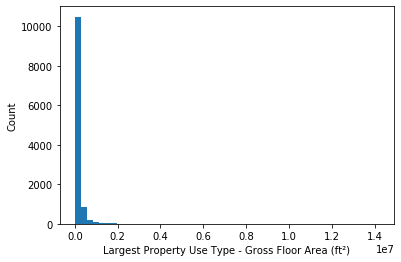

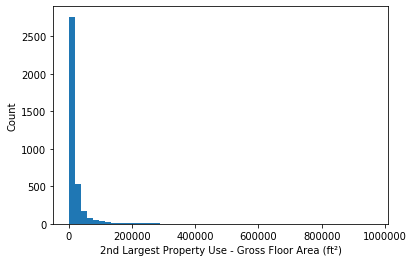

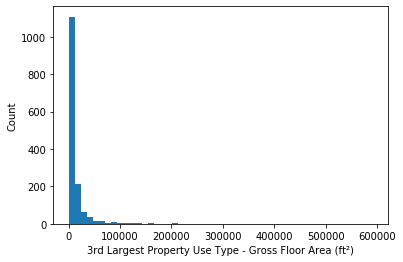

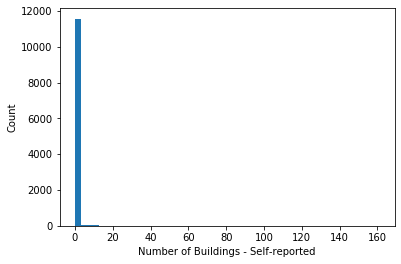

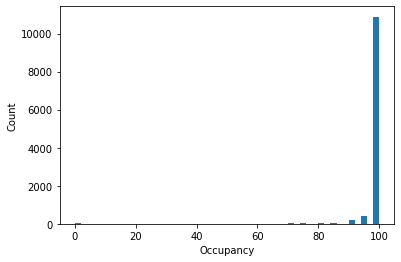

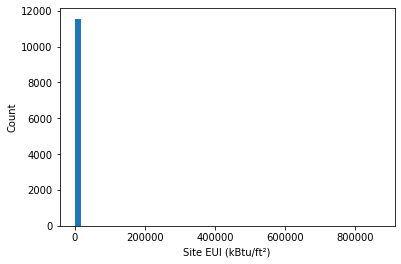

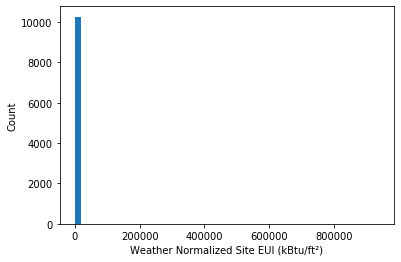

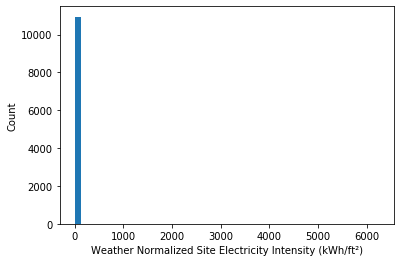

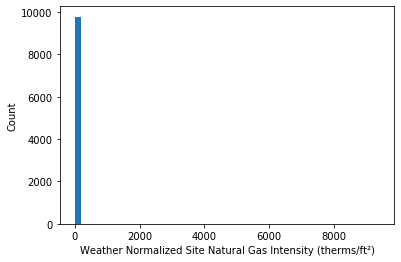

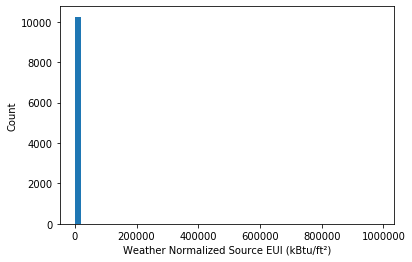

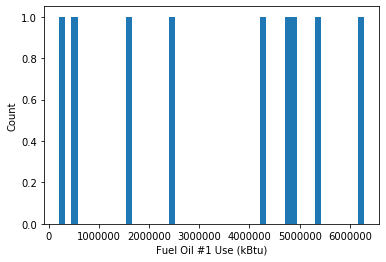

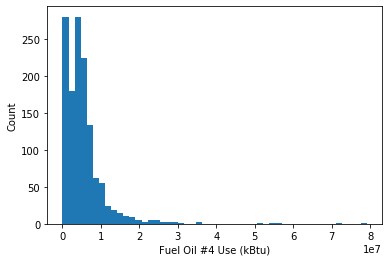

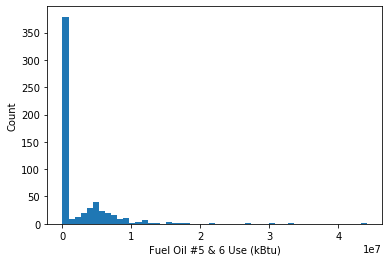

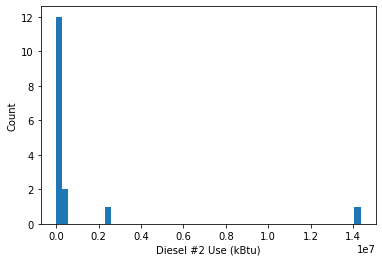

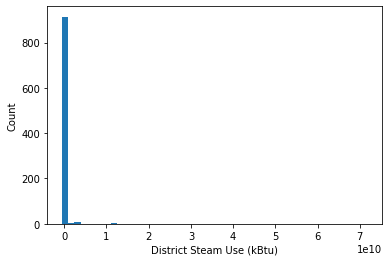

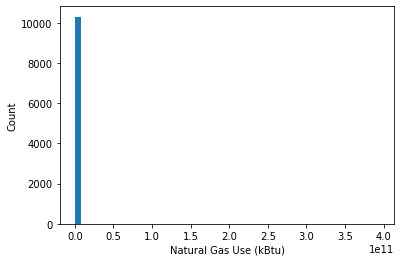

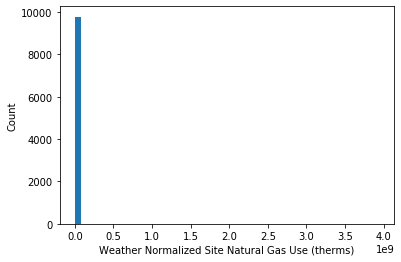

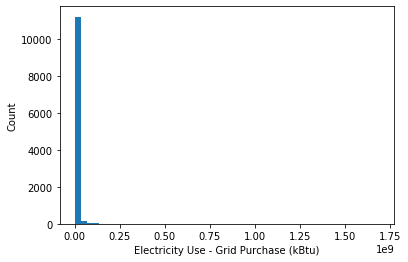

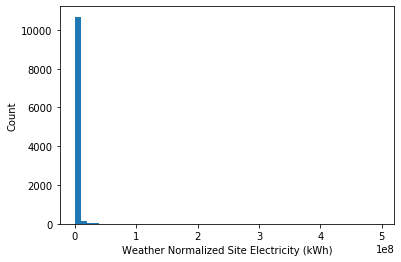

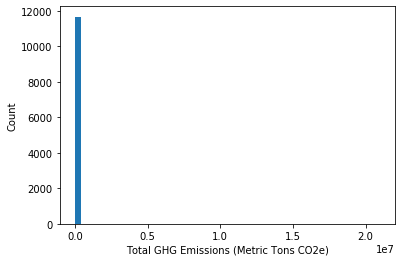

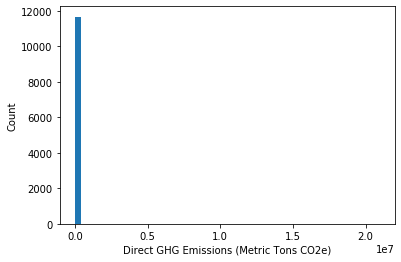

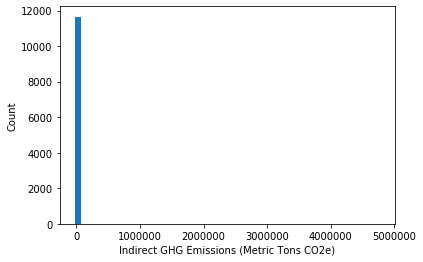

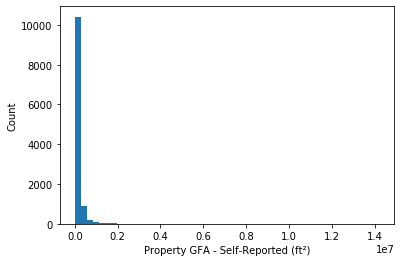

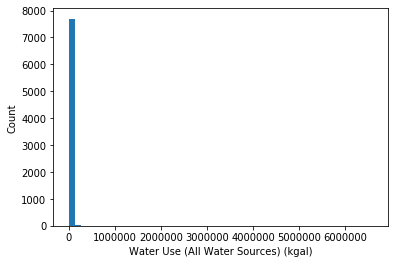

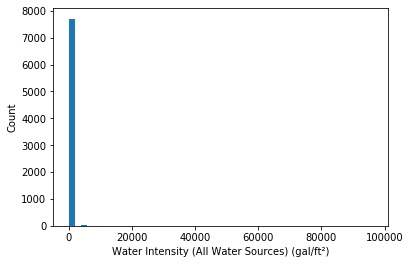

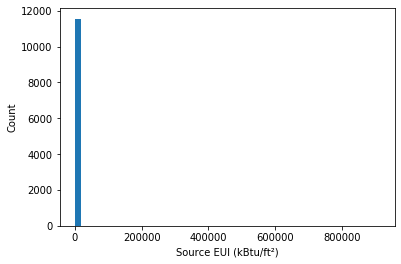

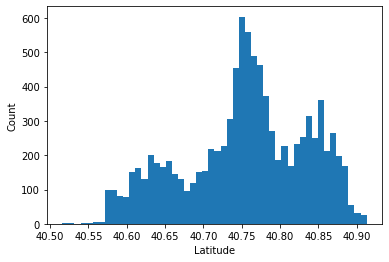

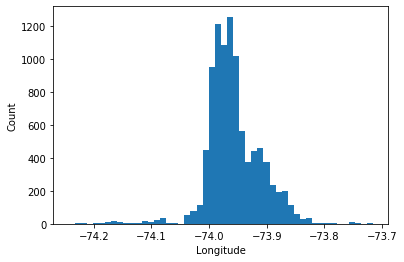

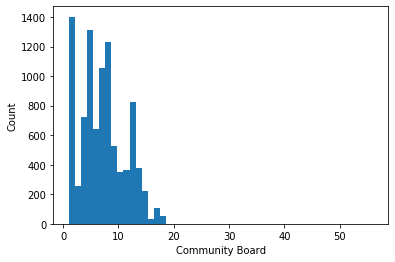

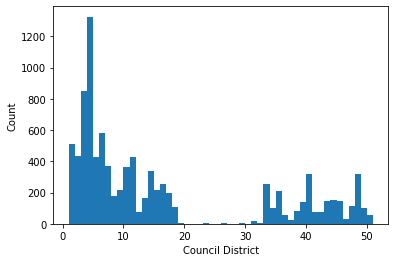

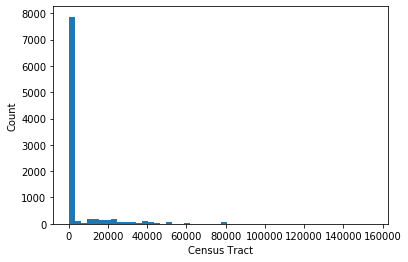

In [43]:
for col in numeric:
    get_histplot(col)

<h2> Using KNNImputer to impute missing values with n=108 (square root of 11746, which are total number of records) </h2>

In [44]:
imputer = KNNImputer(n_neighbors=np.int32(np.round(np.sqrt(len(use_case1_fin)))), weights="uniform")
imputer.fit(use_case1_fin)
cols=use_case1_fin.columns
use_case1_fin=pd.DataFrame(imputer.transform(use_case1_fin),columns=cols)

In [45]:
k=use_case1_fin.isna().sum()
k[k>0]

Series([], dtype: int64)

<h2> Treating numeric features by:- </h2>
<p>
<ol>
  <li>Taking Log `log(abs(min(x)) + x + 1)`</li>
  <li>Standardizing `(x-x_mean)/x_std`</li>
  <li>Removing outliers by caping values >5 by 5 and < -5 with 5</li>
</ol>
</p>

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric2=use_case1_fin[numeric_lst]
numeric2=np.apply_along_axis(arr=numeric2,func1d=lambda x:np.log1p(np.absolute(np.min(x))+x),axis=1)
scaler.fit(numeric2)
numeric2=scaler.transform(numeric2)
numeric2[numeric2>5]=5
numeric2[numeric2<-5]=-5
use_case1_fin[numeric_lst]=numeric2
use_case1_fin.dropna(inplace=True)
use_case1_fin

Largest Property Use Type - Gross Floor Area (ft²)  \
0                                               1.328421    
1                                               5.000000    
2                                               1.007979    
3                                               3.340365    
4                                               0.667565    
...                                                  ...    
11741                                          -0.524270    
11742                                          -0.212500    
11743                                          -0.077883    
11744                                          -0.793907    
11745                                          -0.728110    

       2nd Largest Property Use - Gross Floor Area (ft²)  \
0                                               1.846396   
1                                               5.000000   
2                                               0.519288   
3                                               2.392110   
4                                               0.419808   
...                                                  ...   
11741                                          -0.111510   
11742                                          -0.292448   
11743                                           0.251383   
11744                                          -0.069225   
11745                                           0.056779   

       3rd Largest Property Use Type - Gross Floor Area (ft²)  \
0                                               2.434781        
1                                               5.000000        
2                                               0.349750        
3                                               2.504353        
4                                               0.050599        
...                                                  ...        
11741                                          -0.546095        
11742                                          -0.008381        
11743                                          -0.053435        
11744                                          -0.100677        
11745                                          -0.063224        

       Number of Buildings - Self-reported  Occupancy  Site EUI (kBtu/ft²)  \
0                                 0.037249   0.030293             1.945109   
1                                 5.000000   5.000000             5.000000   
2                                -0.028471   0.029333            -0.061295   
3                                -0.028304   0.029408             0.218414   
4                                -0.028325   0.029398            -0.191502   
...                                    ...        ...                  ...   
11741                            -0.025128   0.030821            -0.008441   
11742                            -0.025081   0.030842             0.352167   
11743                            -0.027889  -0.114847            -0.604081   
11744                            -0.026455   0.030230            -0.175017   
11745                            -0.026675   0.030132             0.587879   

       Weather Normalized Site EUI (kBtu/ft²)  \
0                                    1.854286   
1                                    5.000000   
2                                   -0.050431   
3                                    0.191463   
4                                   -0.169176   
...                                       ...   
11741                                0.009551   
11742                                0.387294   
11743                               -0.664521   
11744                               -0.159722   
11745                                0.630449   

       Weather Normalized Site Electricity Intensity (kWh/ft²)  \
0                                               1.268924         
1                                               5.000000         
2                                               

In [47]:
len(use_case1_fin)

11746

In [48]:
l=use_case1_fin.isna().sum()
l[l>0]


numeric[['District Steam Use (kBtu)','Indirect GHG Emissions (Metric Tons CO2e)']]


District Steam Use (kBtu) Indirect GHG Emissions (Metric Tons CO2e)
0                  5.15506751E7                                    6962.2
1                -3.914148026E8                                    4854.1
2                 Not Available                                         0
3                 Not Available                                         0
4                 Not Available                                         0
...                         ...                                       ...
11741             Not Available                                      79.6
11742             Not Available                                       175
11743             Not Available                                     261.6
11744             Not Available                                      51.7
11745             Not Available                                      71.5

[11746 rows x 2 columns]

<h2>Comparing Distribudion of Numeric variables before and after transformation</h2>

In [55]:
def get_histplot_fin(col):
    '''Function to plot histogram'''
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))    
    print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!',col)    
    ax1.hist(numeric.loc[(numeric[col]!='Not Available') & (~numeric[col].isna()),:][col].astype('float64'),bins=50)
    ax1.set_ylabel('Count')
    ax1.set_xlabel(col) 
    ax2.hist(use_case1_fin.loc[(use_case1_fin[col]!='Not Available') & (~use_case1_fin[col].isna()),:][col].astype('float64'),bins=50)
    ax2.set_ylabel('Count')
    ax2.set_xlabel(col)    
    

!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Largest Property Use Type - Gross Floor Area (ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 2nd Largest Property Use - Gross Floor Area (ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 3rd Largest Property Use Type - Gross Floor Area (ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Number of Buildings - Self-reported
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Occupancy
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Site EUI (kBtu/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Weather Normalized Site EUI (kBtu/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Weather Normalized Site Electricity Intensity (kWh/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Weather Normalized Site Natural Gas Intensity (therms/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Weather Normalized Source EUI (kBtu/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Fuel Oil #1 Use (kBtu)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Fuel Oil #4 Use (kBtu)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Fuel Oil #5 & 6 Use (kBtu)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Diesel #2 Use (kBtu)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! District Steam Use (kBtu)
!!!!!!!!!!!!!

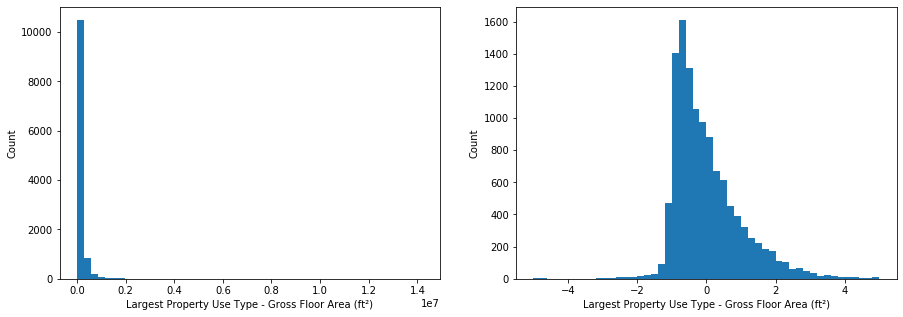

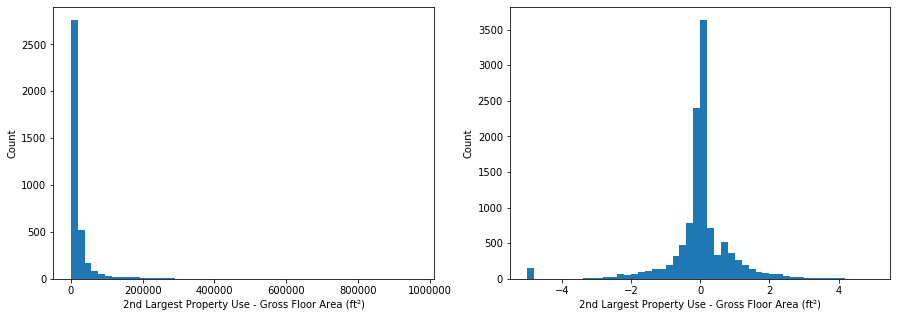

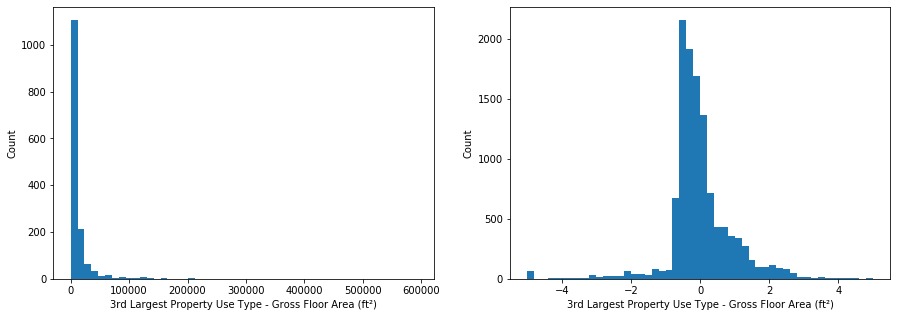

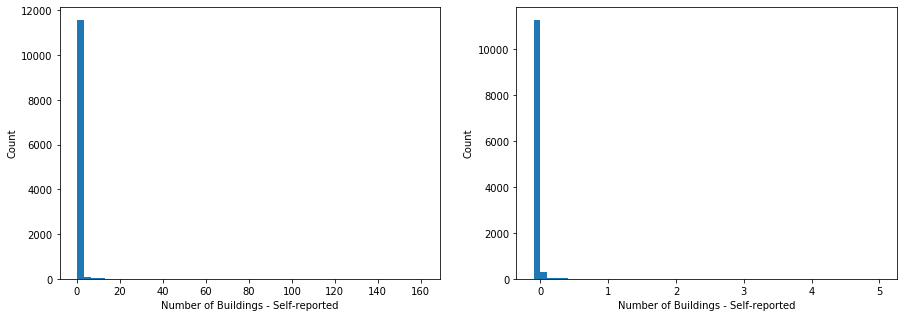

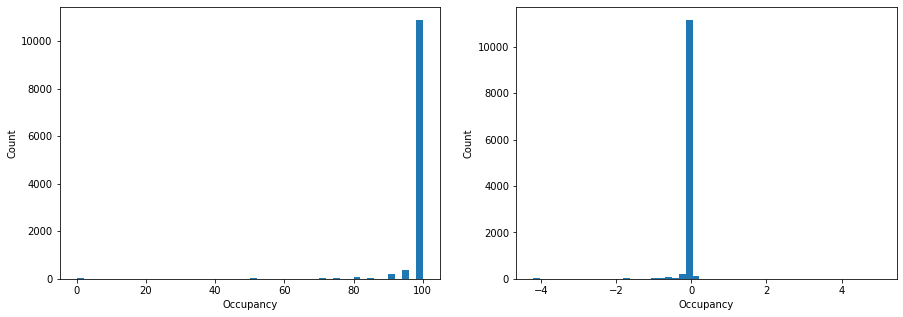

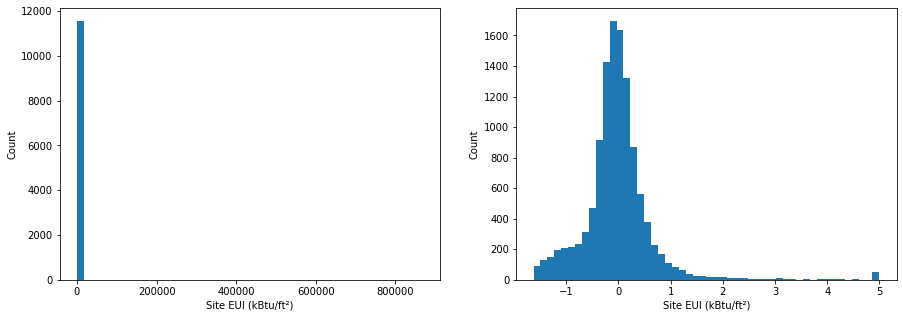

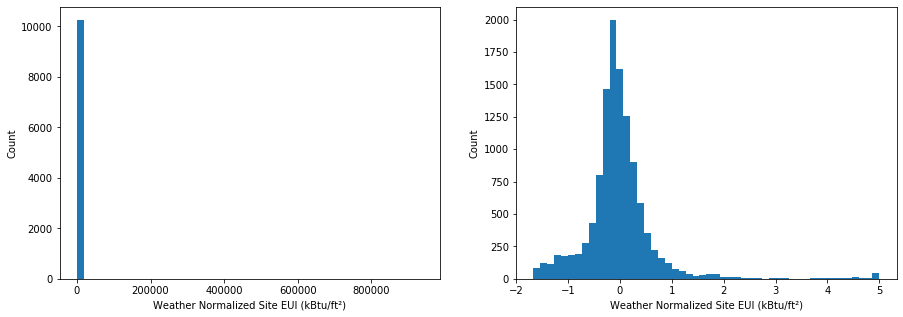

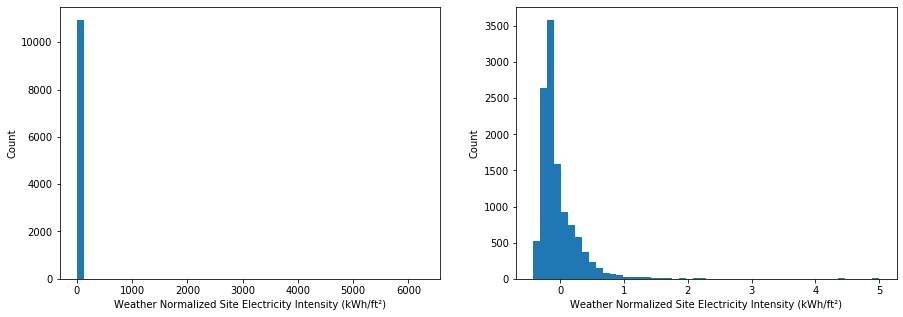

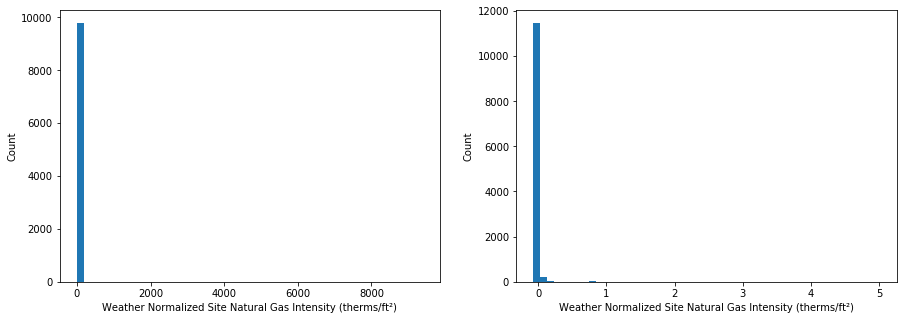

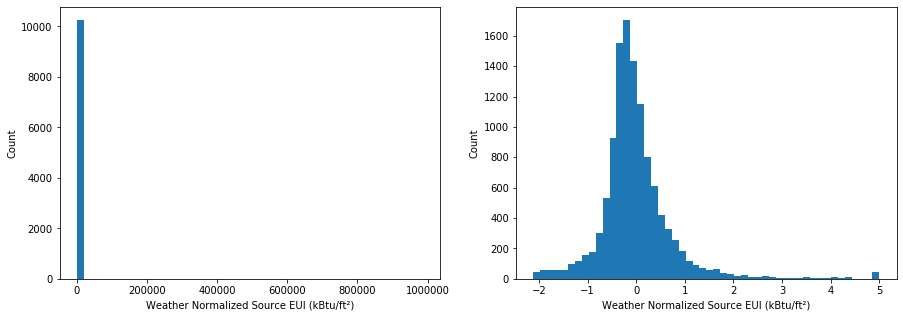

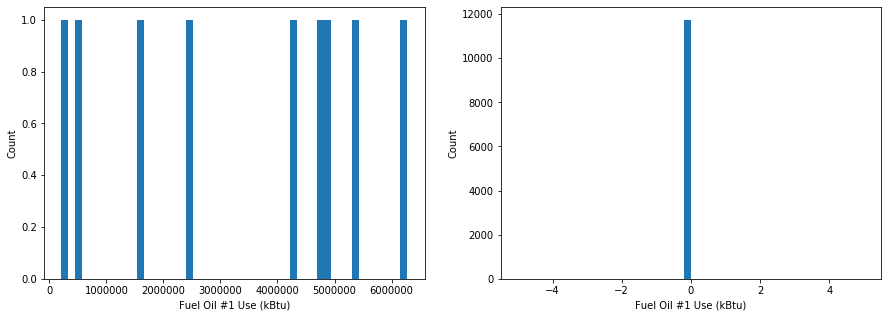

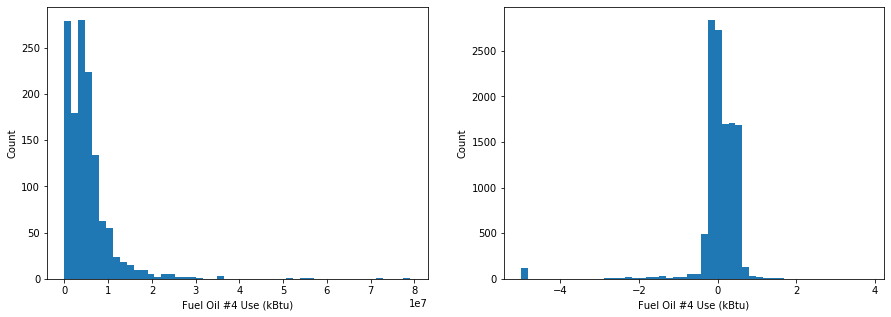

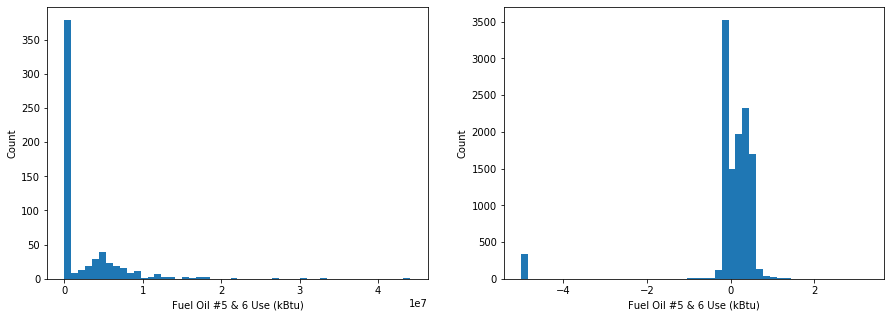

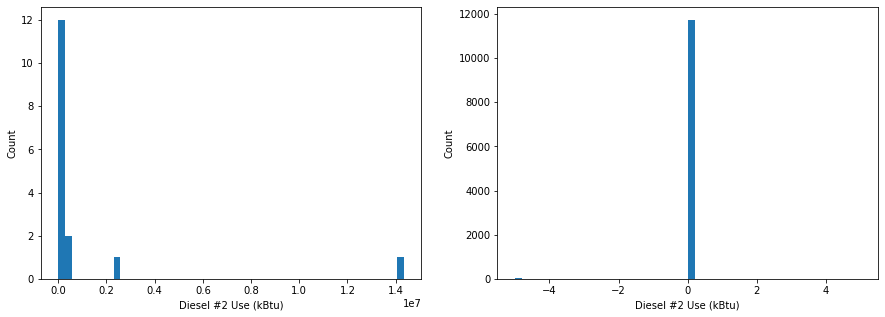

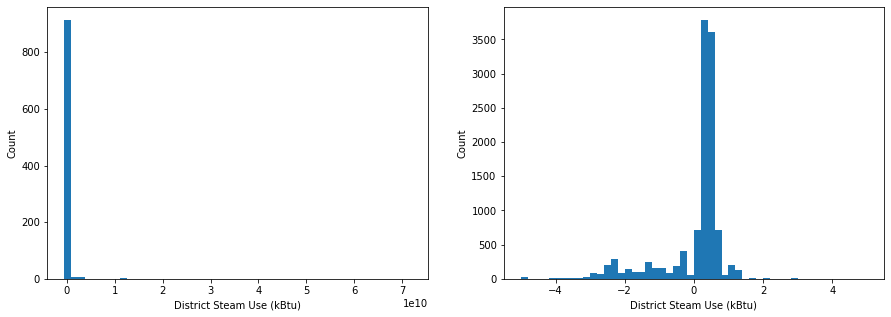

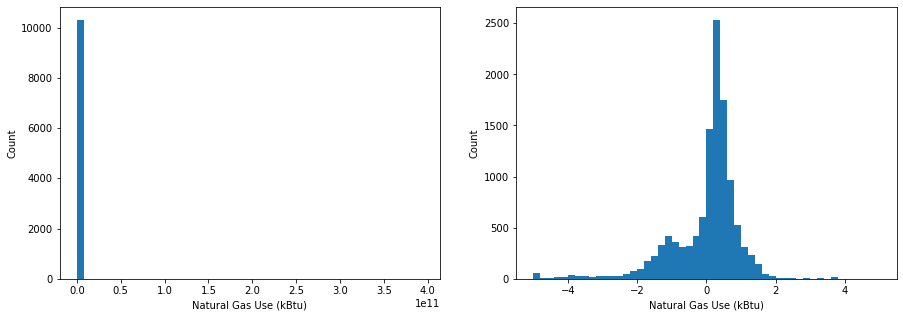

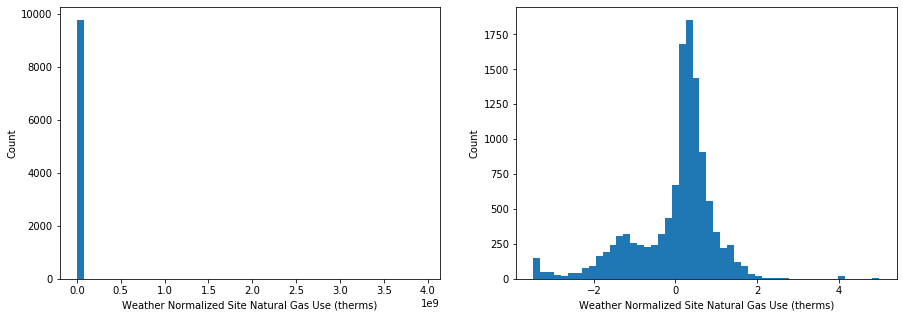

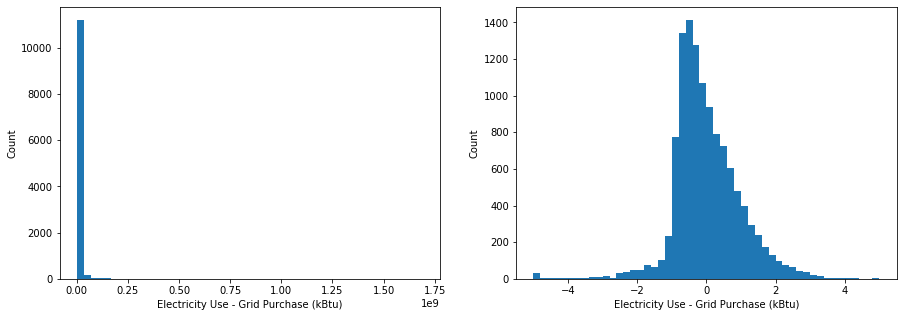

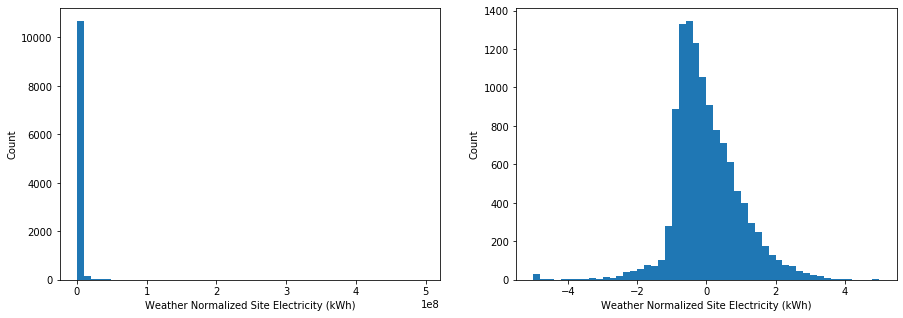

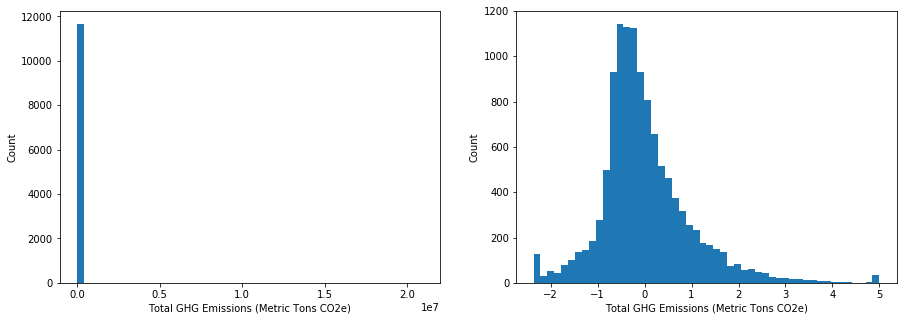

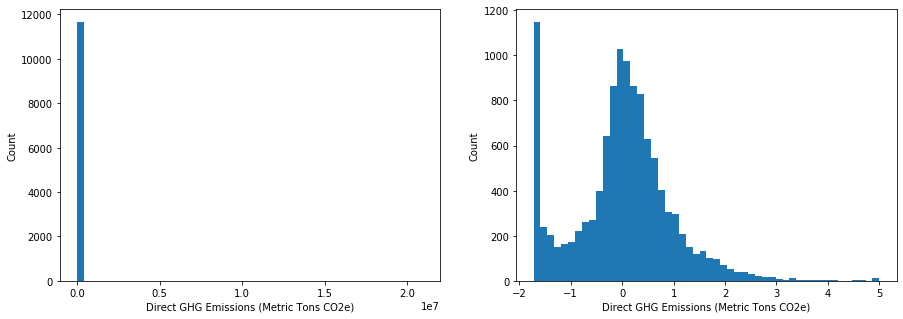

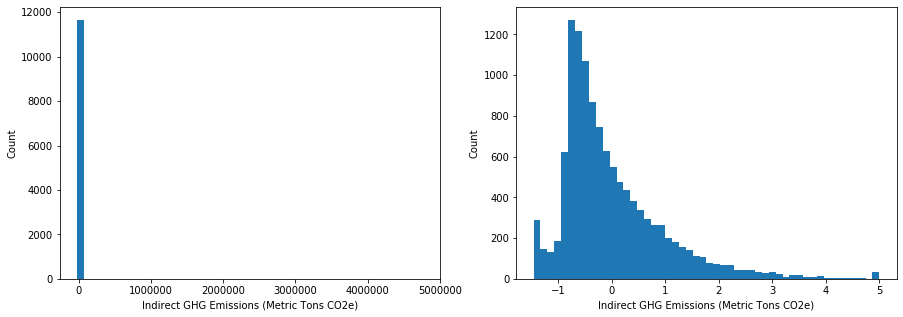

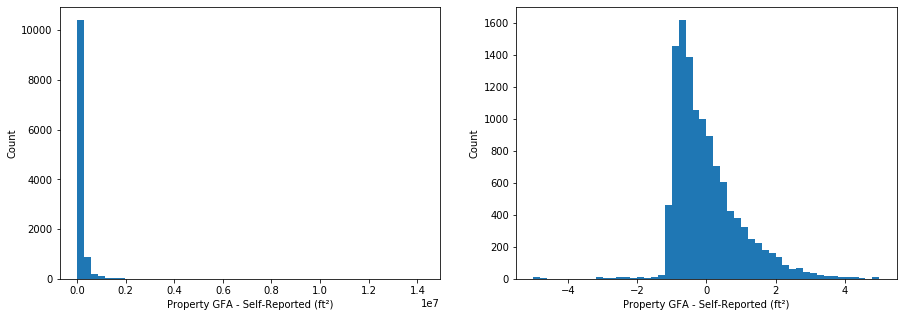

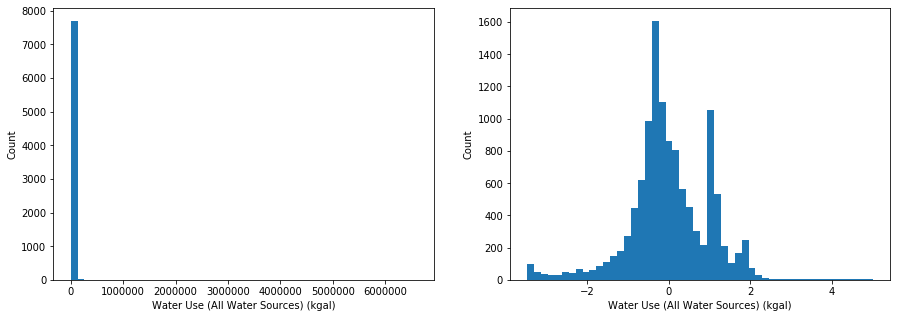

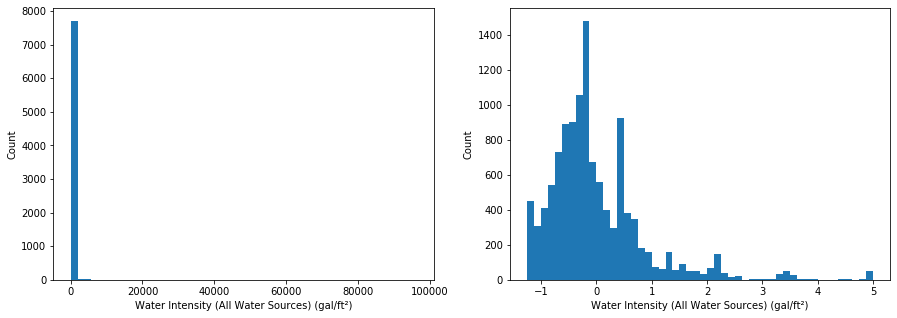

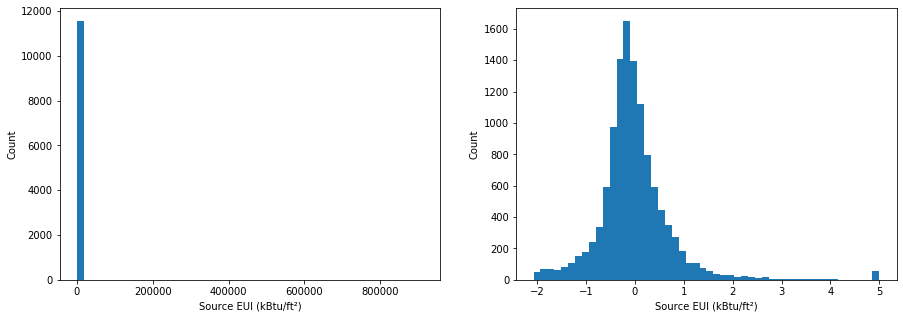

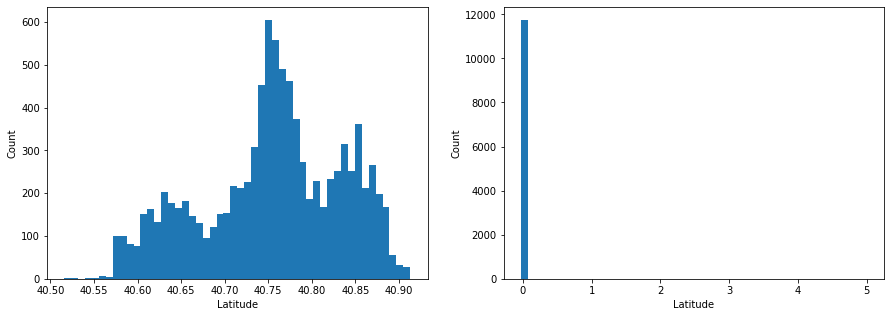

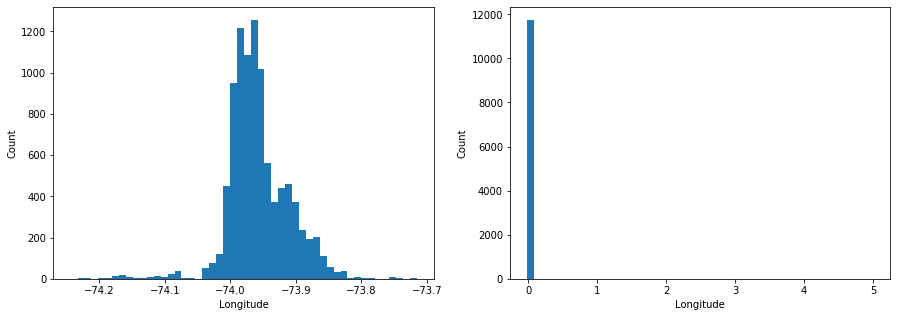

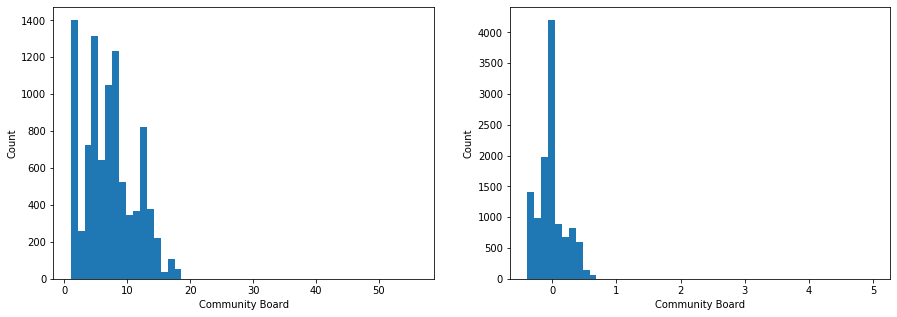

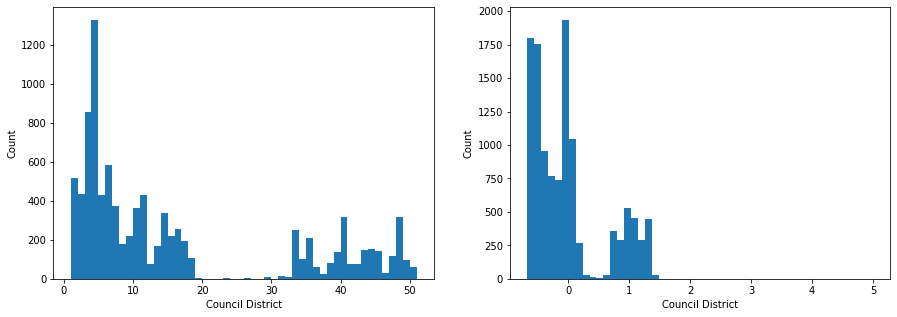

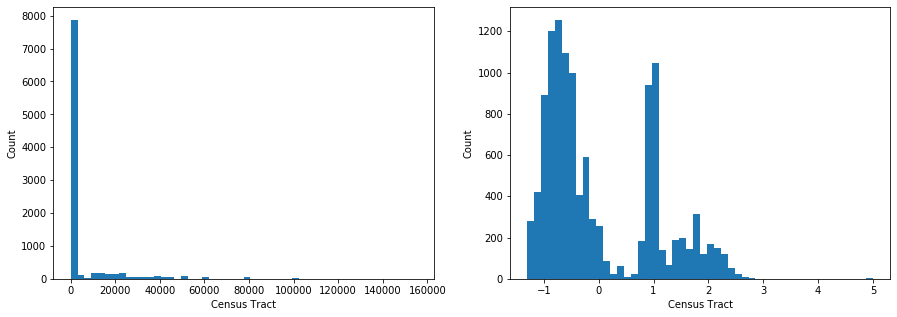

In [56]:
for col in numeric:
    get_histplot_fin(col)    

<h2>Visualizing Distribudion of Numeric variables For outliers</h2>

In [57]:
def get_box_fin(col):
    '''Function to plot boxplot'''
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))    
    print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!',col)    
    ax1.hist(numeric.loc[(numeric[col]!='Not Available') & (~numeric[col].isna()),:][col].astype('float64'),bins=50)
    ax1.set_ylabel('Count')
    ax1.set_xlabel(col) 
    ax2.boxplot(use_case1_fin.loc[(use_case1_fin[col]!='Not Available') & (~use_case1_fin[col].isna()),:][col].astype('float64'))
    ax2.set_ylabel('Count')
    ax2.set_xlabel(col)   

!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Largest Property Use Type - Gross Floor Area (ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 2nd Largest Property Use - Gross Floor Area (ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 3rd Largest Property Use Type - Gross Floor Area (ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Number of Buildings - Self-reported
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Occupancy
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Site EUI (kBtu/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Weather Normalized Site EUI (kBtu/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Weather Normalized Site Electricity Intensity (kWh/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Weather Normalized Site Natural Gas Intensity (therms/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Weather Normalized Source EUI (kBtu/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Fuel Oil #1 Use (kBtu)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Fuel Oil #4 Use (kBtu)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Fuel Oil #5 & 6 Use (kBtu)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Diesel #2 Use (kBtu)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! District Steam Use (kBtu)
!!!!!!!!!!!!!

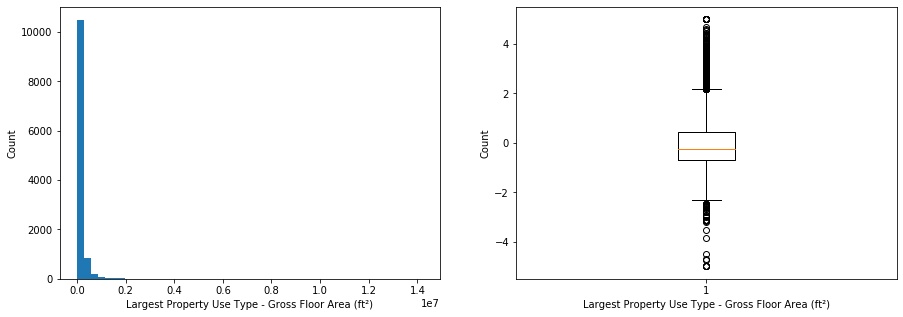

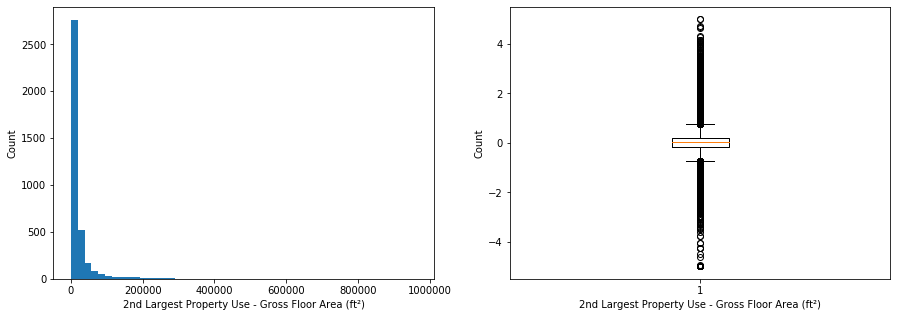

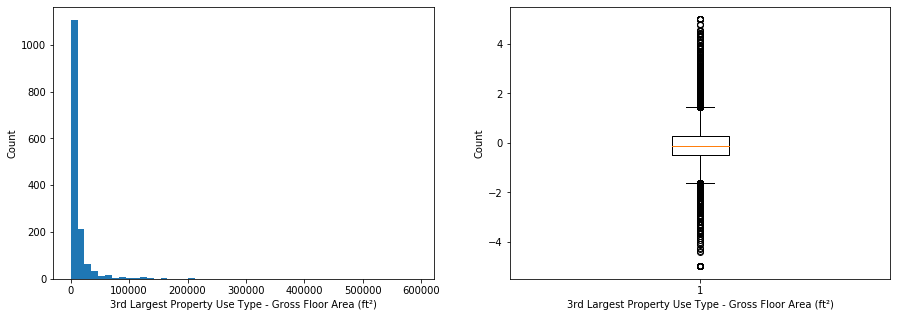

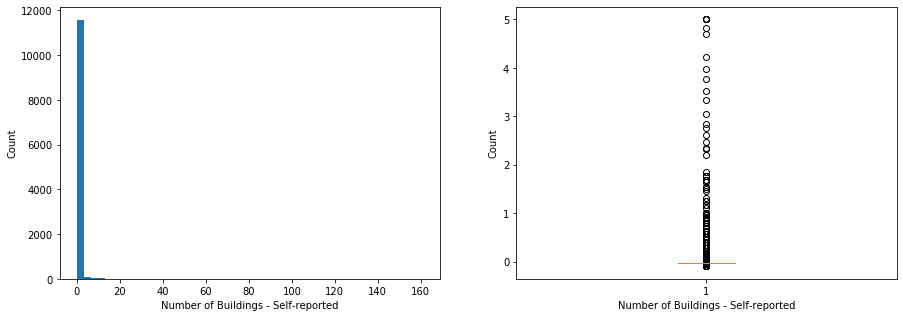

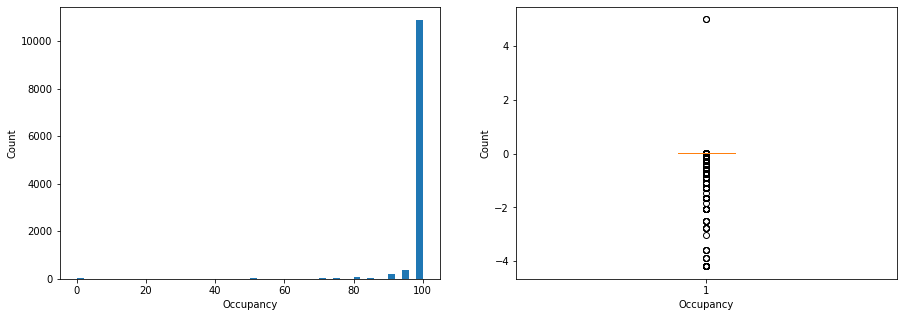

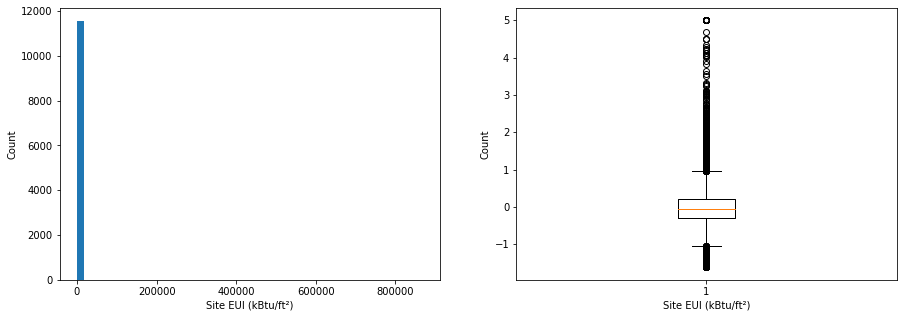

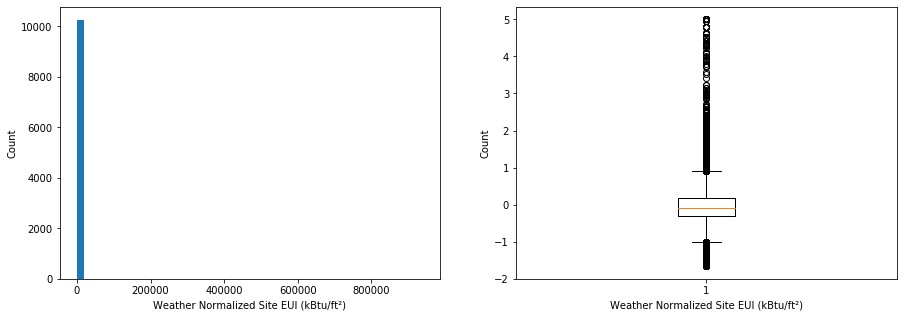

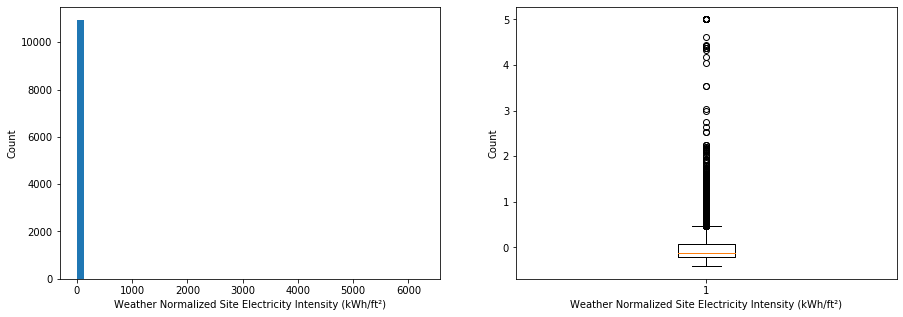

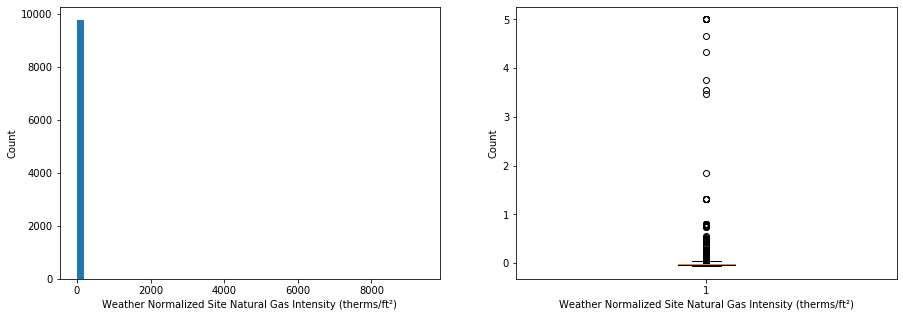

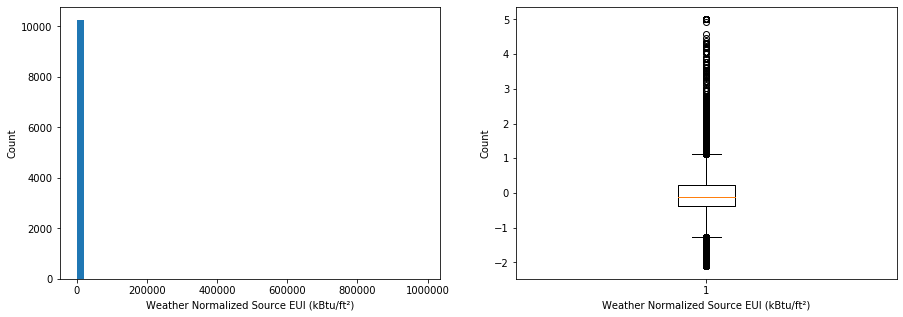

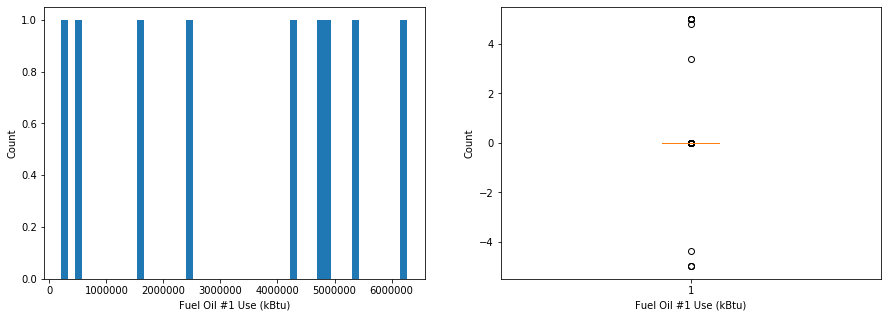

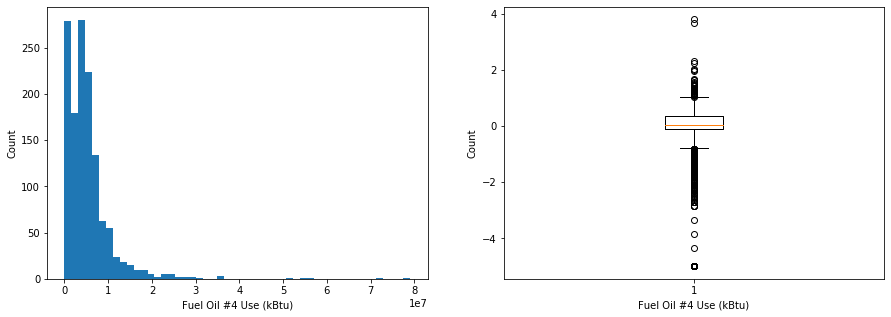

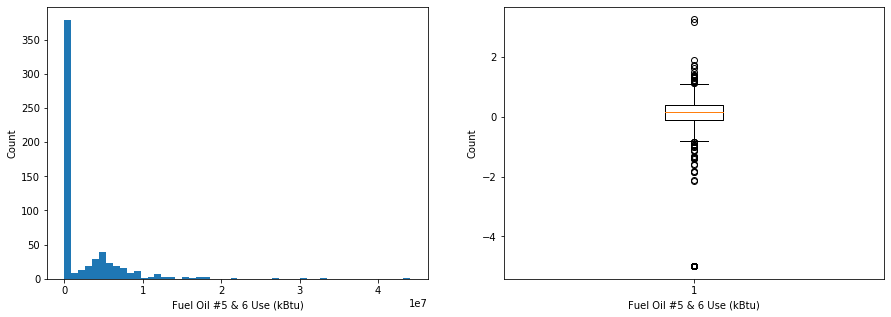

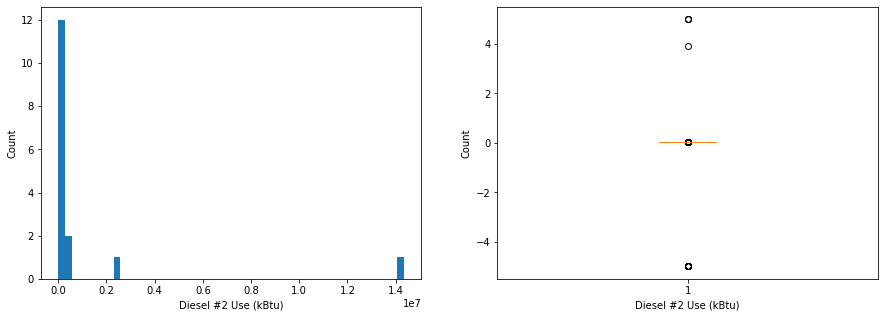

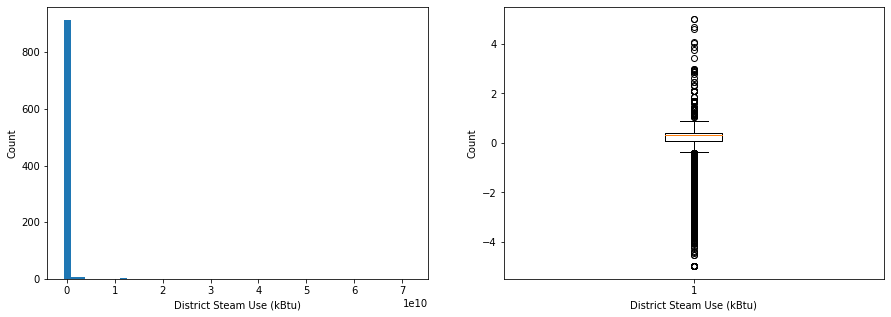

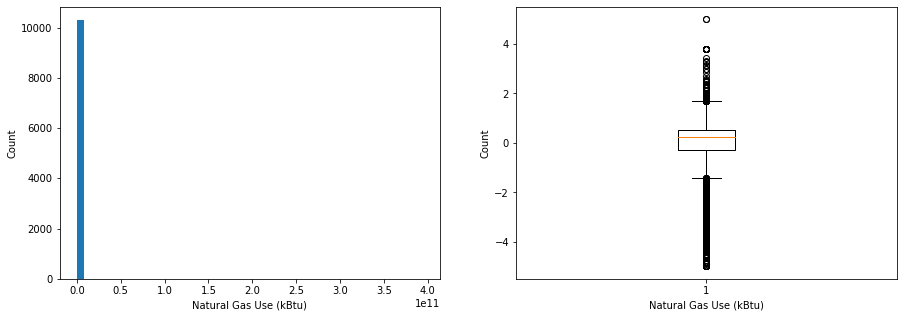

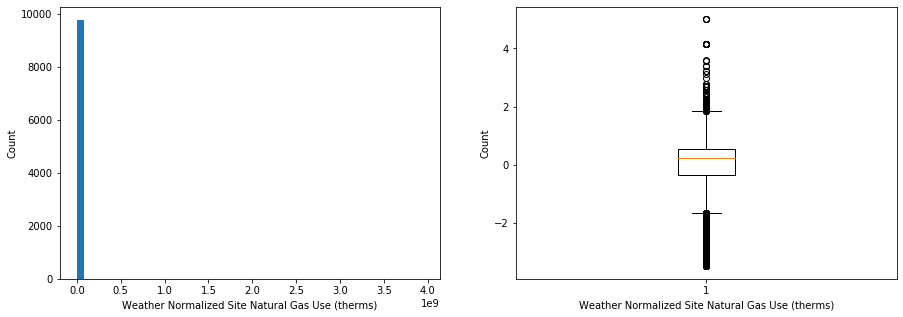

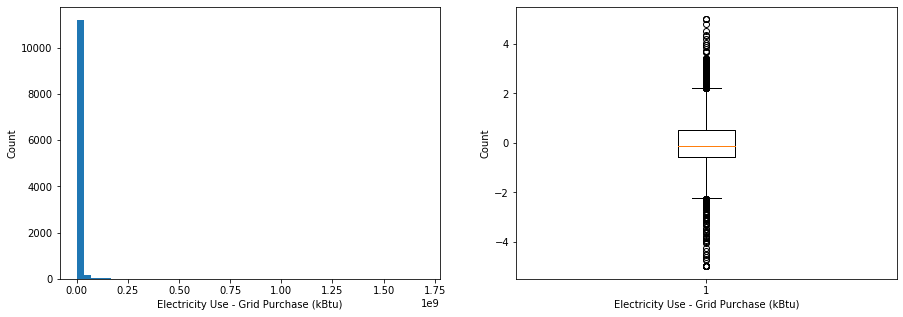

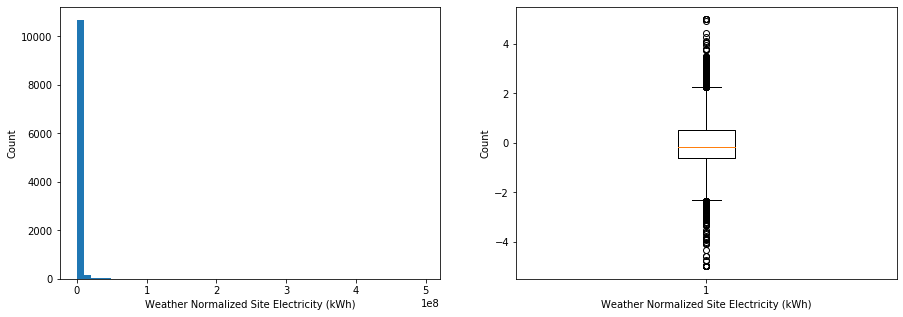

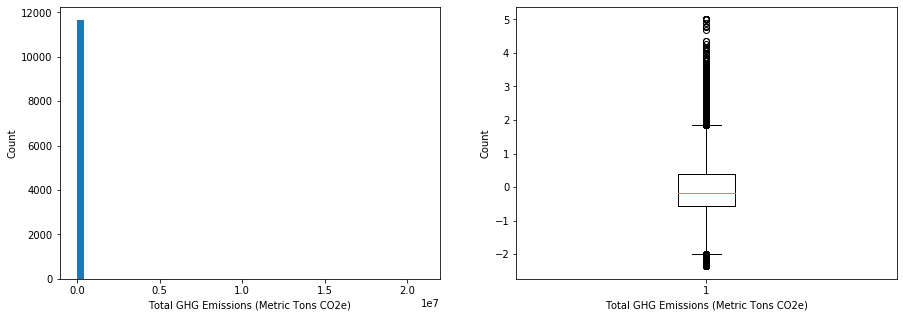

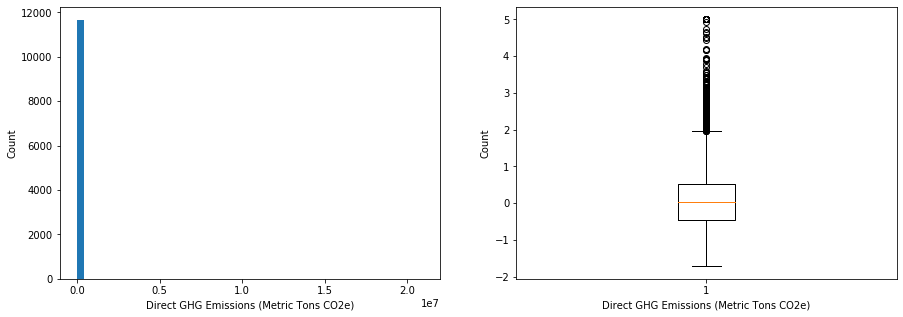

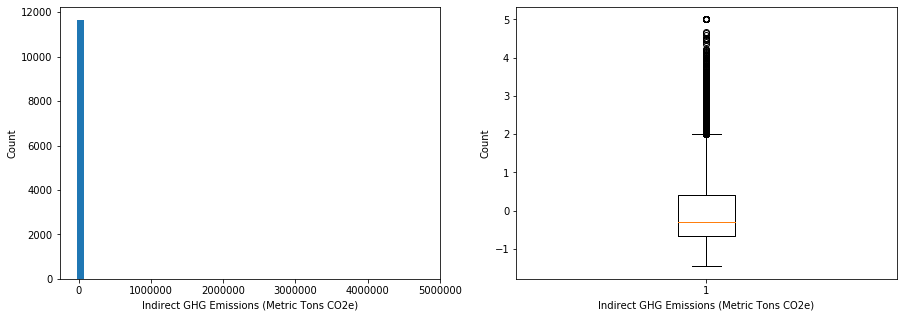

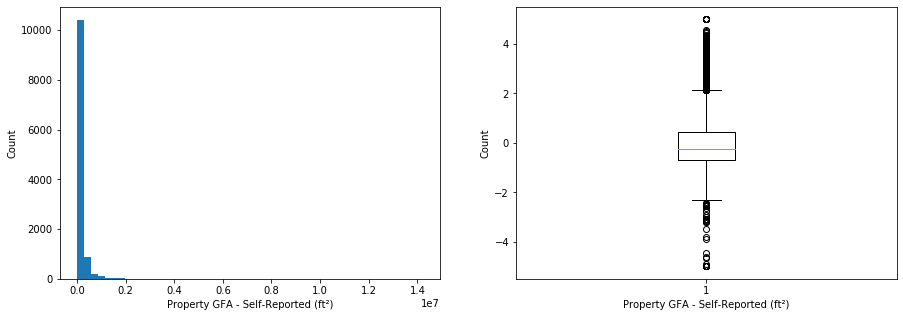

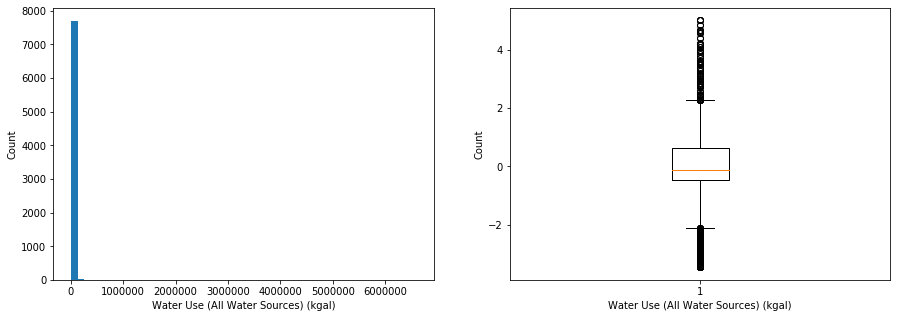

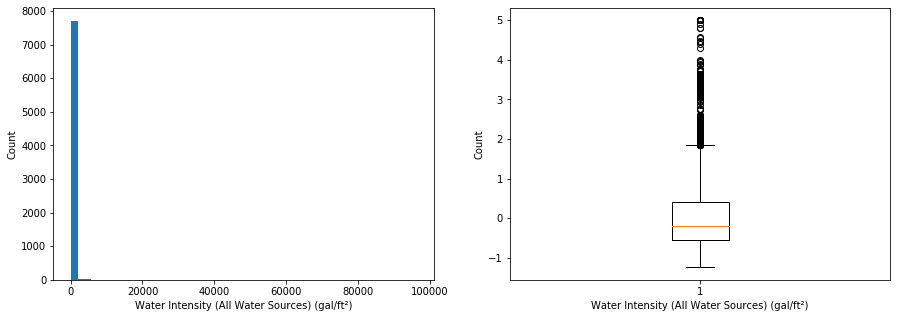

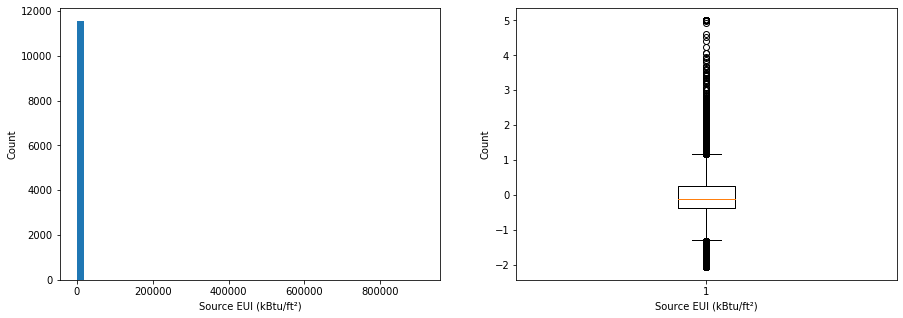

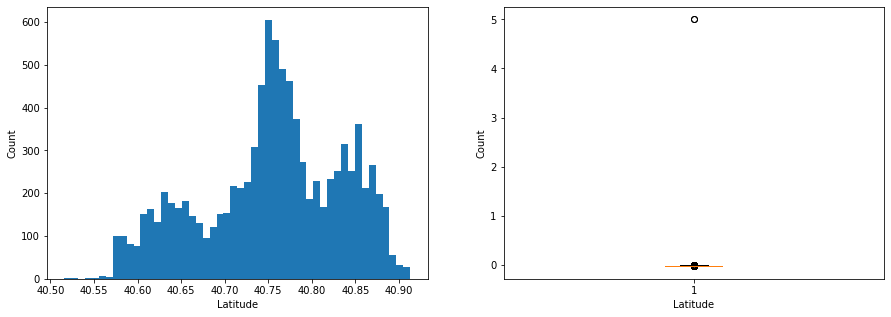

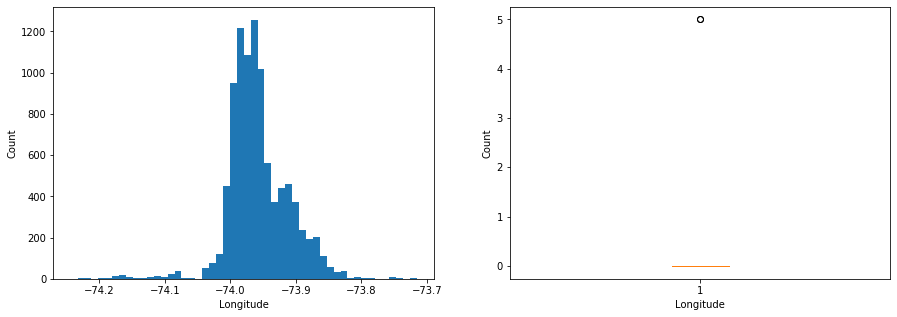

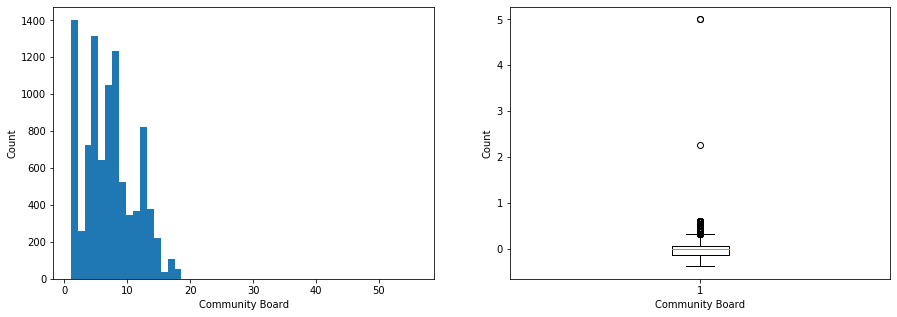

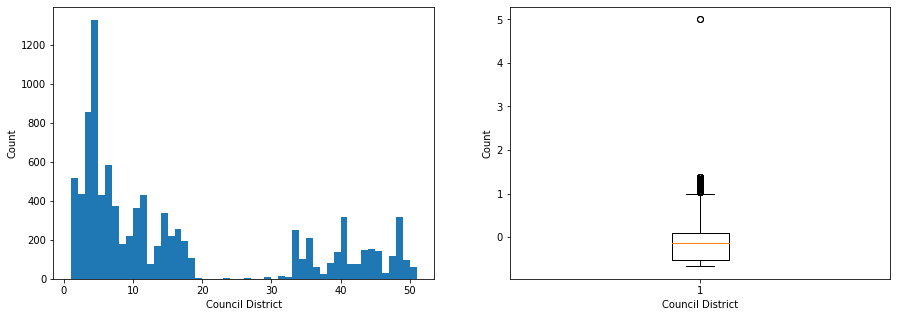

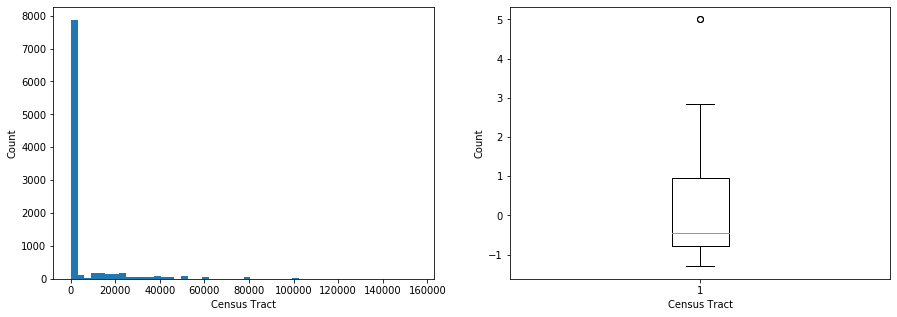

In [58]:
for col in numeric.columns:
    get_box_fin(col)    

In [64]:
def get_box_fin_after(col):
    '''This function plots box plot for numeric variable before and after transformation'''
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))    
    print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!',col)    
    ax1.boxplot(use_case1.loc[(use_case1[col]!='Not Available') & (~use_case1[col].isna()),:][col].astype('float64'))
    ax1.set_ylabel('Count')
    ax1.set_xlabel(col) 
    ax2.boxplot(use_case1_fin.loc[(use_case1_fin[col]!='Not Available') & (~use_case1_fin[col].isna()),:][col].astype('float64'))
    ax2.set_ylabel('Count')
    ax2.set_xlabel(col)

<h3>Box plots on Left are before transformation and to Right are after transformation</h3>

!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Largest Property Use Type - Gross Floor Area (ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 2nd Largest Property Use - Gross Floor Area (ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 3rd Largest Property Use Type - Gross Floor Area (ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Number of Buildings - Self-reported
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Occupancy
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Site EUI (kBtu/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Weather Normalized Site EUI (kBtu/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Weather Normalized Site Electricity Intensity (kWh/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Weather Normalized Site Natural Gas Intensity (therms/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Weather Normalized Source EUI (kBtu/ft²)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Fuel Oil #1 Use (kBtu)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Fuel Oil #4 Use (kBtu)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Fuel Oil #5 & 6 Use (kBtu)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Diesel #2 Use (kBtu)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!! District Steam Use (kBtu)
!!!!!!!!!!!!!

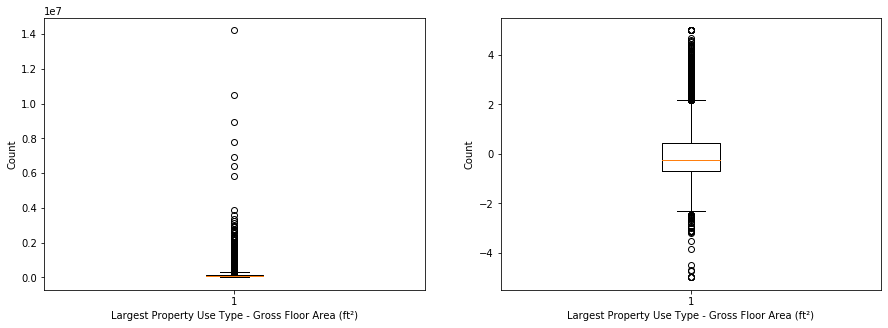

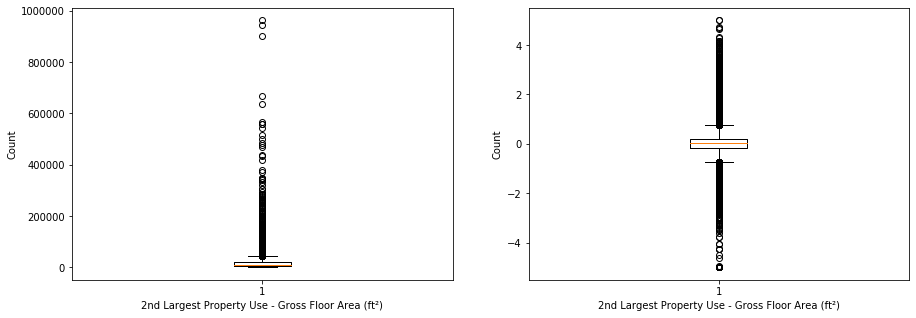

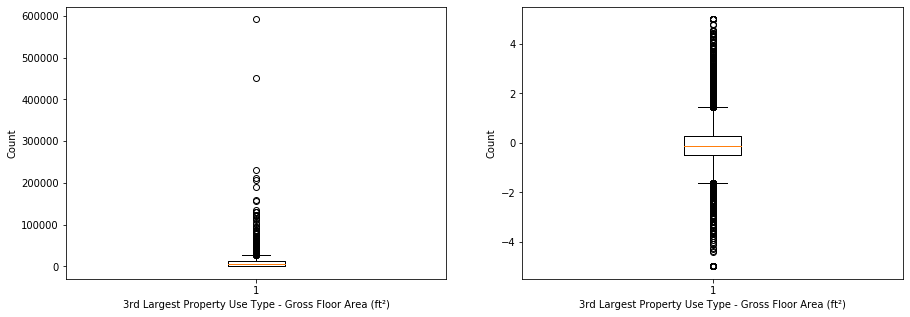

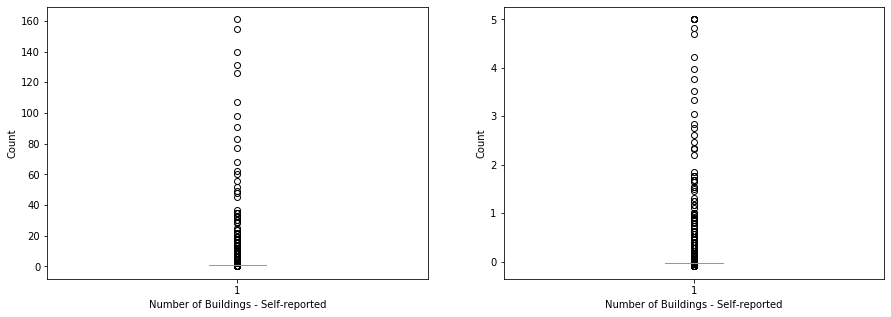

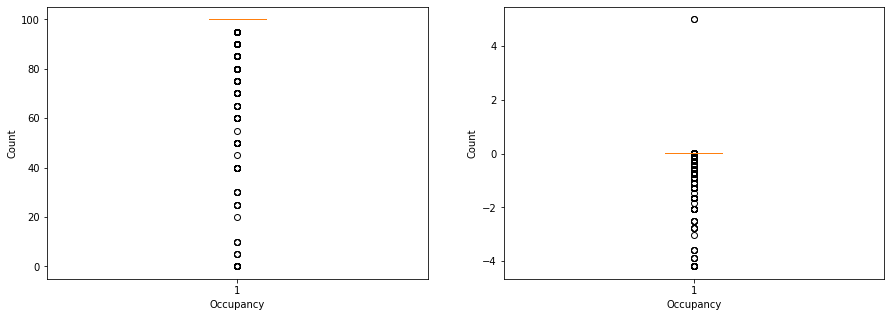

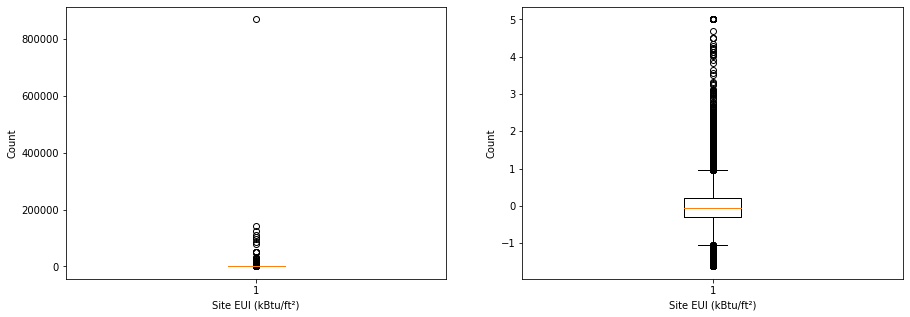

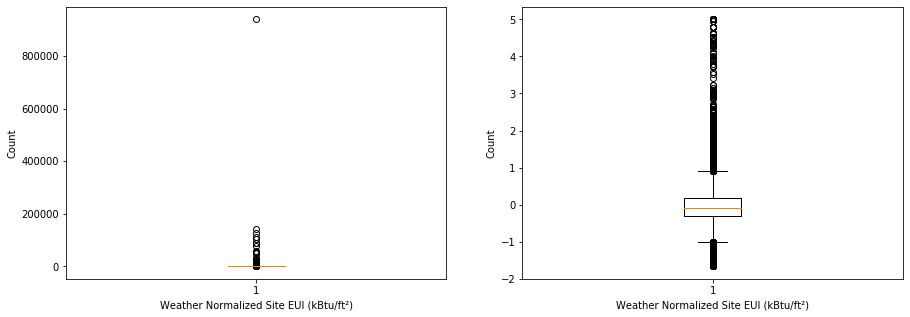

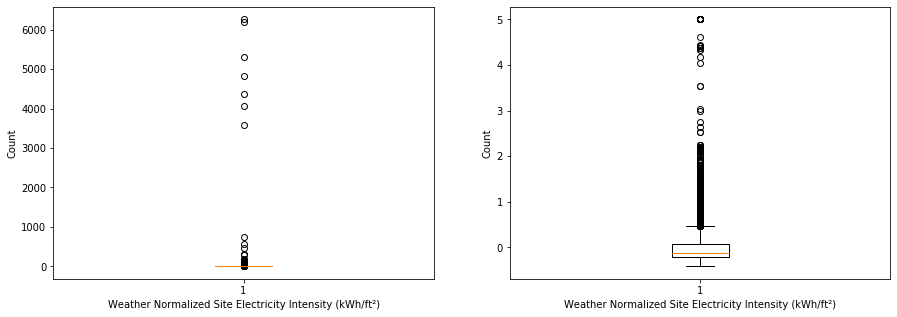

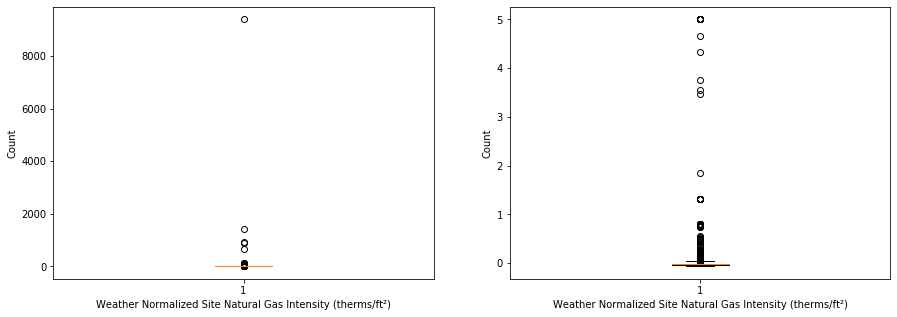

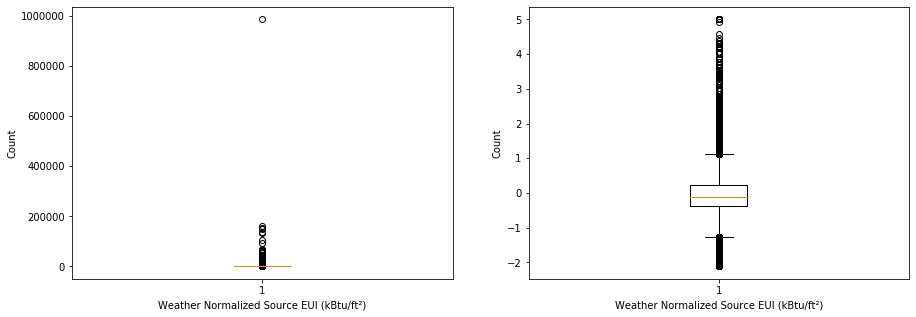

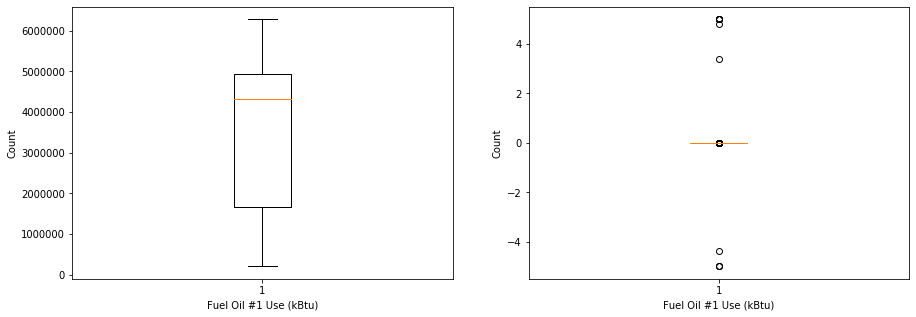

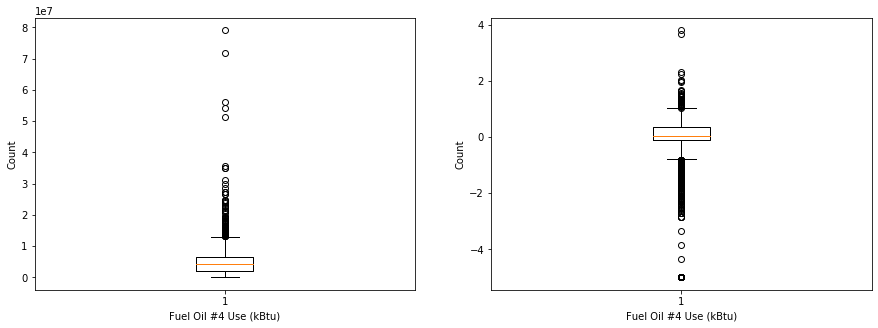

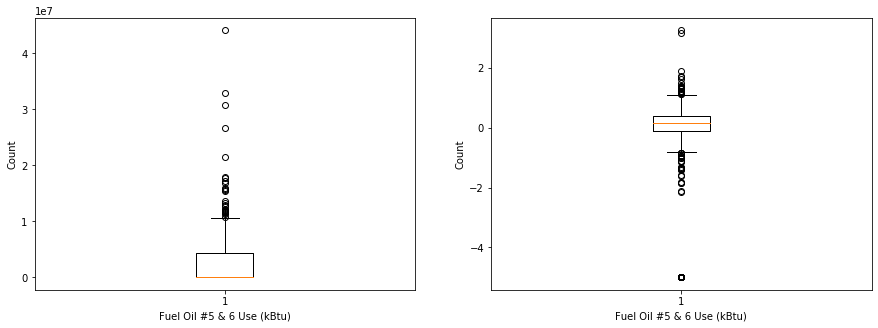

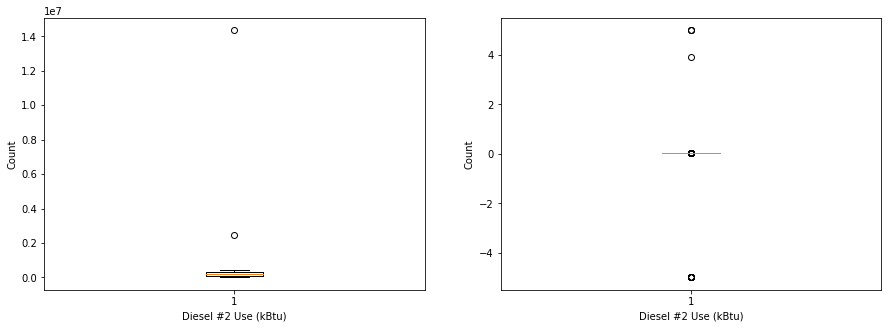

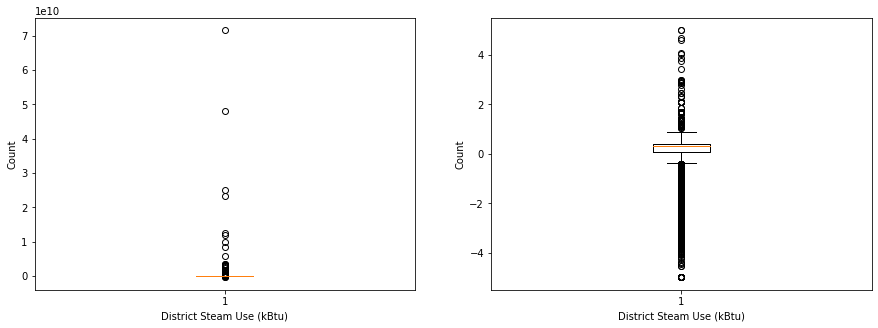

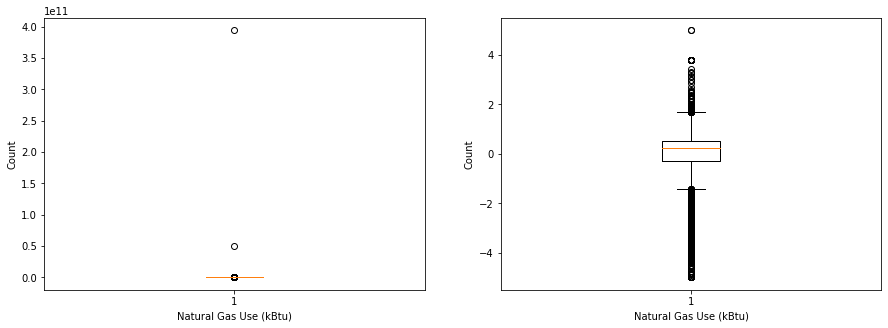

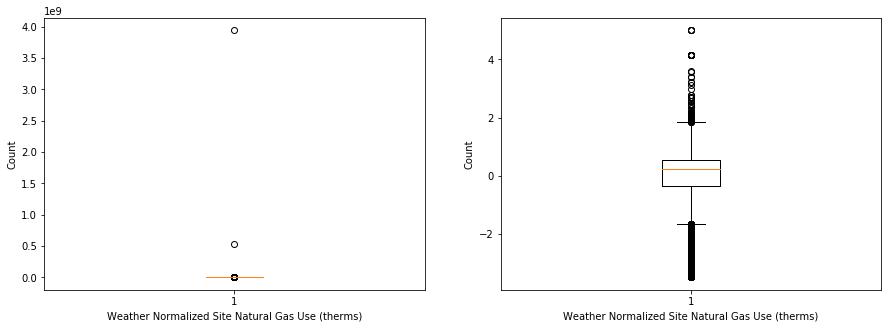

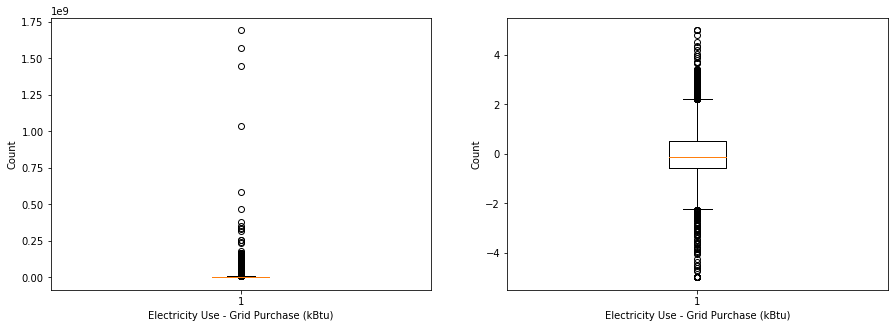

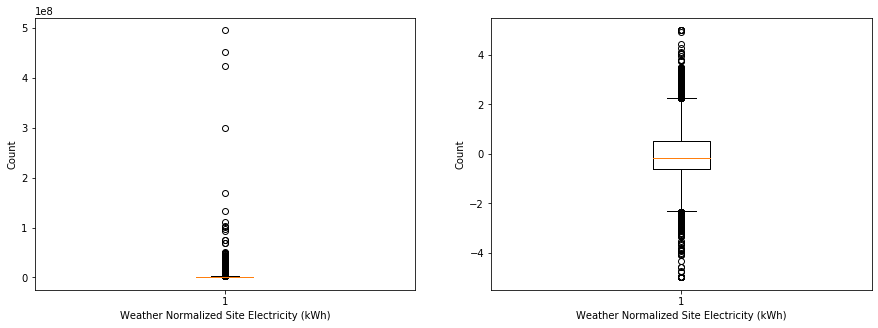

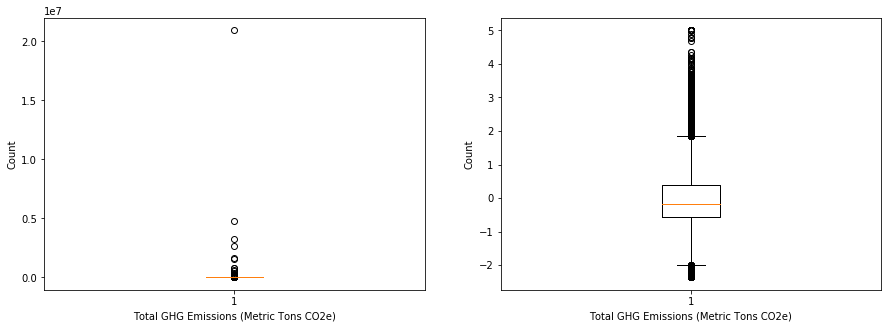

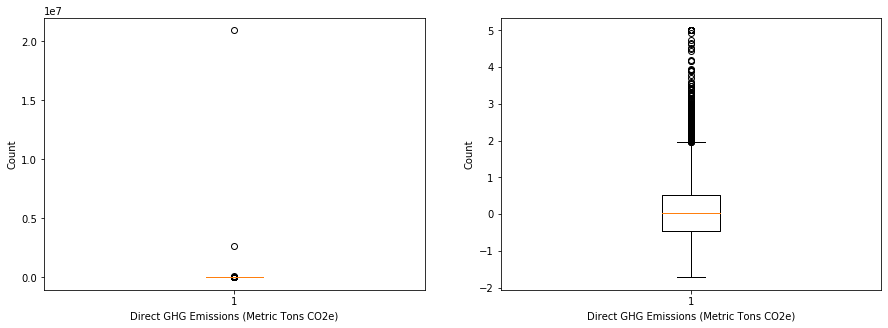

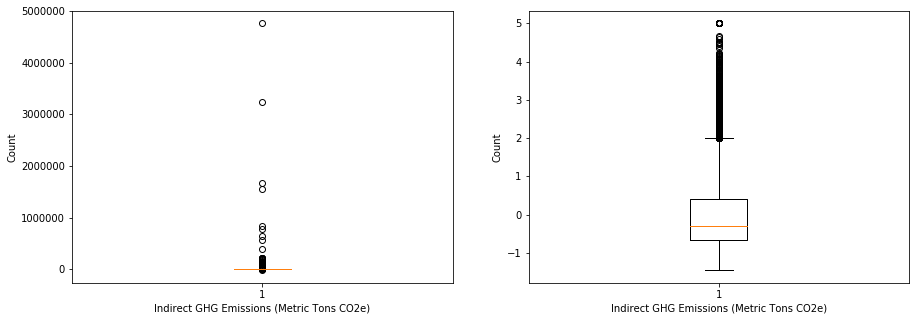

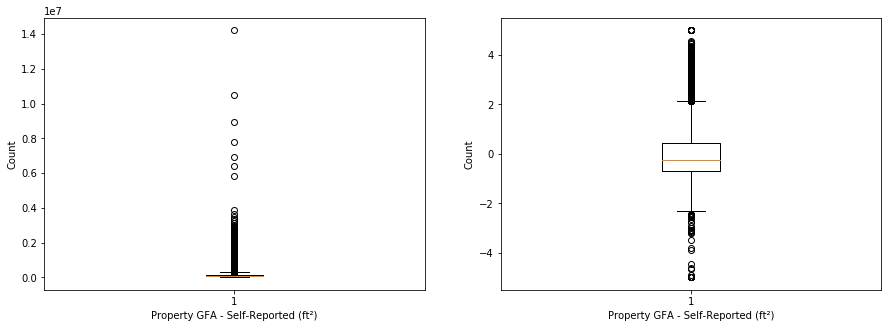

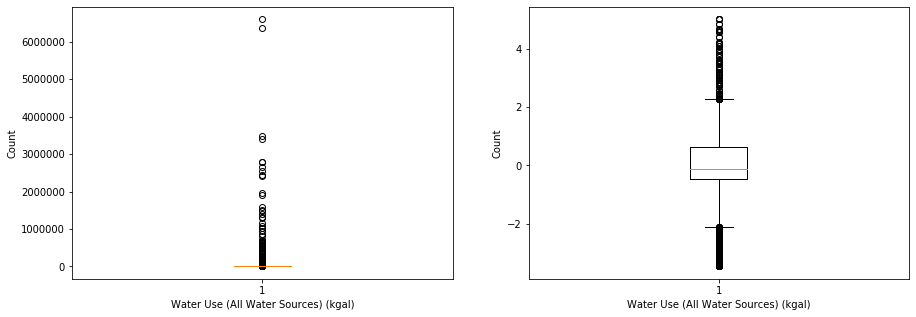

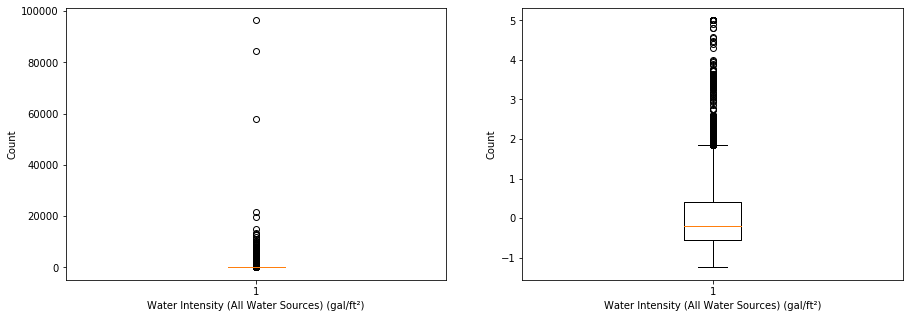

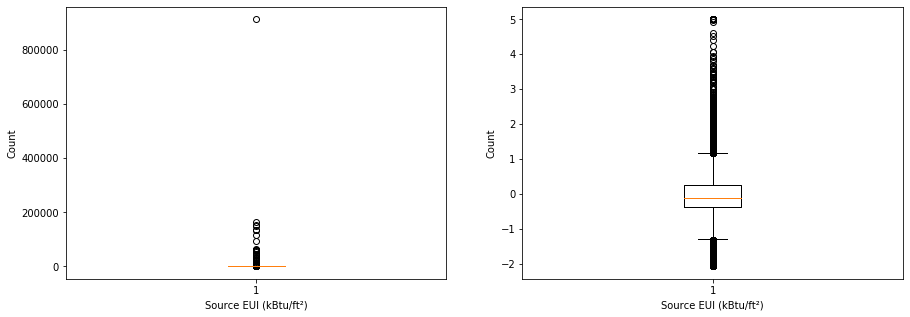

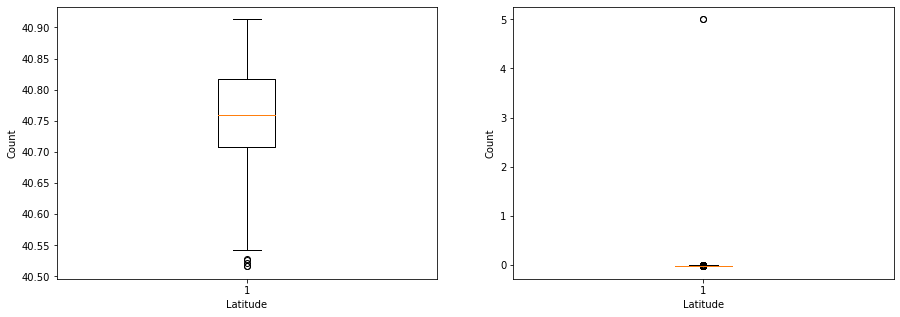

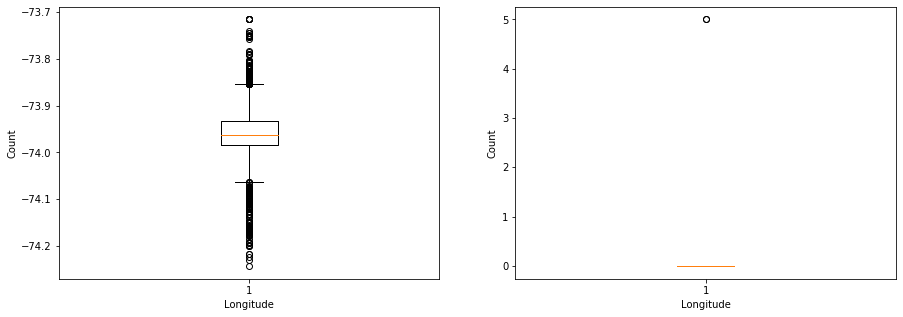

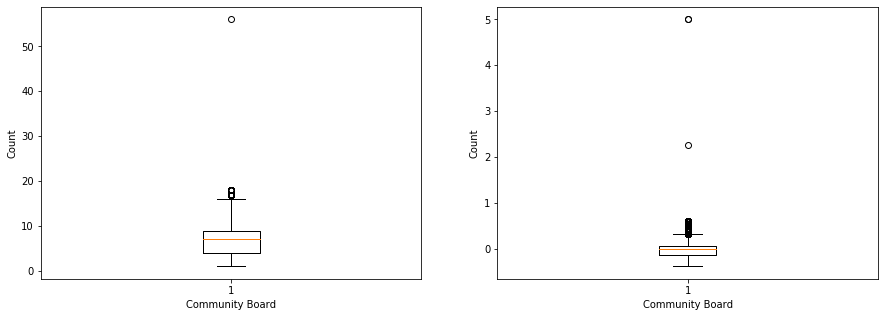

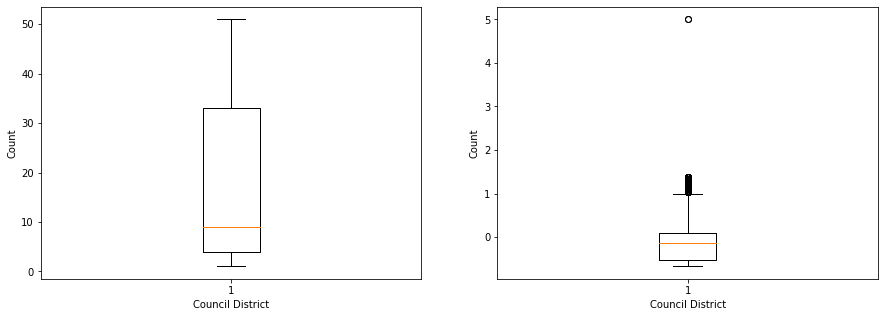

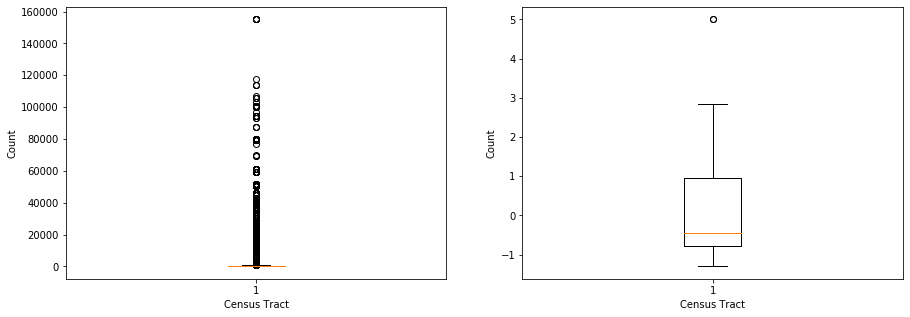

In [65]:
for col in numeric.columns:
    get_box_fin_after(col)    

In [66]:
numeric=use_case1[['Largest Property Use Type - Gross Floor Area (ft²)',
'2nd Largest Property Use - Gross Floor Area (ft²)',
'3rd Largest Property Use Type - Gross Floor Area (ft²)',
'Number of Buildings - Self-reported',
'Occupancy',
'Site EUI (kBtu/ft²)',
'Weather Normalized Site EUI (kBtu/ft²)',
'Weather Normalized Site Electricity Intensity (kWh/ft²)',
'Weather Normalized Site Natural Gas Intensity (therms/ft²)',
'Weather Normalized Source EUI (kBtu/ft²)',
'Fuel Oil #1 Use (kBtu)',
'Fuel Oil #4 Use (kBtu)',
'Fuel Oil #5 & 6 Use (kBtu)',
'Diesel #2 Use (kBtu)',
'District Steam Use (kBtu)',
'Natural Gas Use (kBtu)',
'Weather Normalized Site Natural Gas Use (therms)',
'Electricity Use - Grid Purchase (kBtu)',
'Weather Normalized Site Electricity (kWh)',
'Total GHG Emissions (Metric Tons CO2e)',
'Direct GHG Emissions (Metric Tons CO2e)',
'Indirect GHG Emissions (Metric Tons CO2e)',
'Property GFA - Self-Reported (ft²)',
'Water Use (All Water Sources) (kgal)',
'Water Intensity (All Water Sources) (gal/ft²)',
'Source EUI (kBtu/ft²)',
'Latitude',
'Longitude',
'Community Board',
'Council District',
'Census Tract']]

<h1>Checking Correlation among numeric variables</h1>

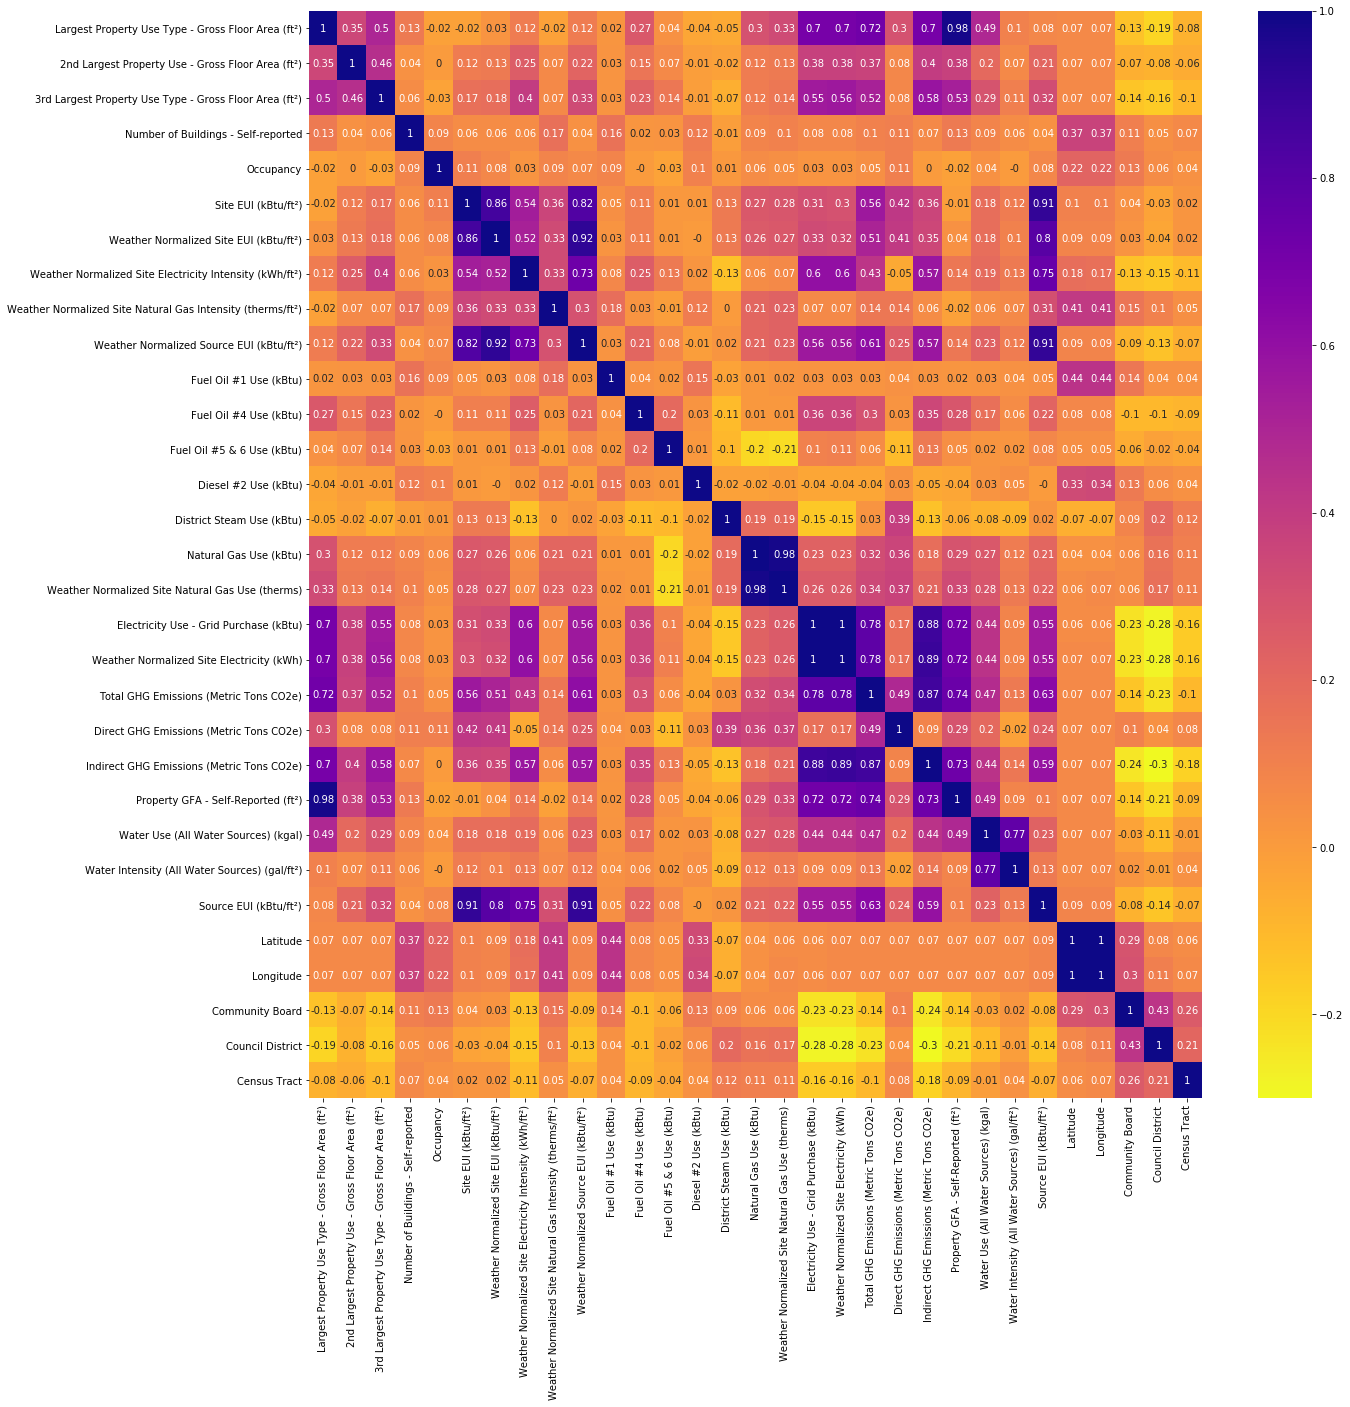

In [67]:
fig = plt.subplots(1, 1,figsize=(20,20)) 
corrMatrix = np.round(use_case1_fin[numeric_lst].corr(),2)
sns.heatmap(corrMatrix, annot=True,cmap='plasma_r')
plt.show()

In [68]:
use_case1_fin=pd.concat([use_case1_fin,use_case1['ENERGY STAR Score']],axis=1)
use_case1_fin

Largest Property Use Type - Gross Floor Area (ft²)  \
0                                               1.328421    
1                                               5.000000    
2                                               1.007979    
3                                               3.340365    
4                                               0.667565    
...                                                  ...    
11741                                          -0.524270    
11742                                          -0.212500    
11743                                          -0.077883    
11744                                          -0.793907    
11745                                          -0.728110    

       2nd Largest Property Use - Gross Floor Area (ft²)  \
0                                               1.846396   
1                                               5.000000   
2                                               0.519288   
3                                               2.392110   
4                                               0.419808   
...                                                  ...   
11741                                          -0.111510   
11742                                          -0.292448   
11743                                           0.251383   
11744                                          -0.069225   
11745                                           0.056779   

       3rd Largest Property Use Type - Gross Floor Area (ft²)  \
0                                               2.434781        
1                                               5.000000        
2                                               0.349750        
3                                               2.504353        
4                                               0.050599        
...                                                  ...        
11741                                          -0.546095        
11742                                          -0.008381        
11743                                          -0.053435        
11744                                          -0.100677        
11745                                          -0.063224        

       Number of Buildings - Self-reported  Occupancy  Site EUI (kBtu/ft²)  \
0                                 0.037249   0.030293             1.945109   
1                                 5.000000   5.000000             5.000000   
2                                -0.028471   0.029333            -0.061295   
3                                -0.028304   0.029408             0.218414   
4                                -0.028325   0.029398            -0.191502   
...                                    ...        ...                  ...   
11741                            -0.025128   0.030821            -0.008441   
11742                            -0.025081   0.030842             0.352167   
11743                            -0.027889  -0.114847            -0.604081   
11744                            -0.026455   0.030230            -0.175017   
11745                            -0.026675   0.030132             0.587879   

       Weather Normalized Site EUI (kBtu/ft²)  \
0                                    1.854286   
1                                    5.000000   
2                                   -0.050431   
3                                    0.191463   
4                                   -0.169176   
...                                       ...   
11741                                0.009551   
11742                                0.387294   
11743                               -0.664521   
11744                               -0.159722   
11745                                0.630449   

       Weather Normalized Site Electricity Intensity (kWh/ft²)  \
0                                               1.268924         
1                                               5.000000         
2                                               

<h4>Checking the % of records for which 'ENERGY STAR Score' is not available and Removing those records</h4>

In [107]:
len(use_case1_fin.loc[use_case1_fin['ENERGY STAR Score']=='Not Available',:])/len(use_case1_fin)

0.0

In [72]:
use_case1_fin=use_case1_fin.loc[use_case1_fin['ENERGY STAR Score']!='Not Available',:]

<h1>ML Modelling</h1>

<h2>Splitting the data into test and train set</h2>

In [75]:
col_lst=use_case1_fin.columns.tolist()
col_lst.remove('ENERGY STAR Score')

X=use_case1_fin[col_lst]
y=use_case1_fin['ENERGY STAR Score']

1        55
5        55
12       93
13        1
14       80
         ..
11741    98
11742    16
11743    83
11744    92
11745    19
Name: ENERGY STAR Score, Length: 9642, dtype: object

In [80]:
X=X.astype('float32')
y=y.astype('int32')

In [81]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [82]:
len(X_train.columns.tolist())

69

<h2>Linear Regression with Recursive Feature Elimination</h2>

In [84]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
rfe = RFECV(linreg, min_features_to_select=30,cv=4)
rfe = rfe.fit(X_train, y_train)


In [85]:
grid_sc=pd.DataFrame({'GS':rfe.grid_scores_})

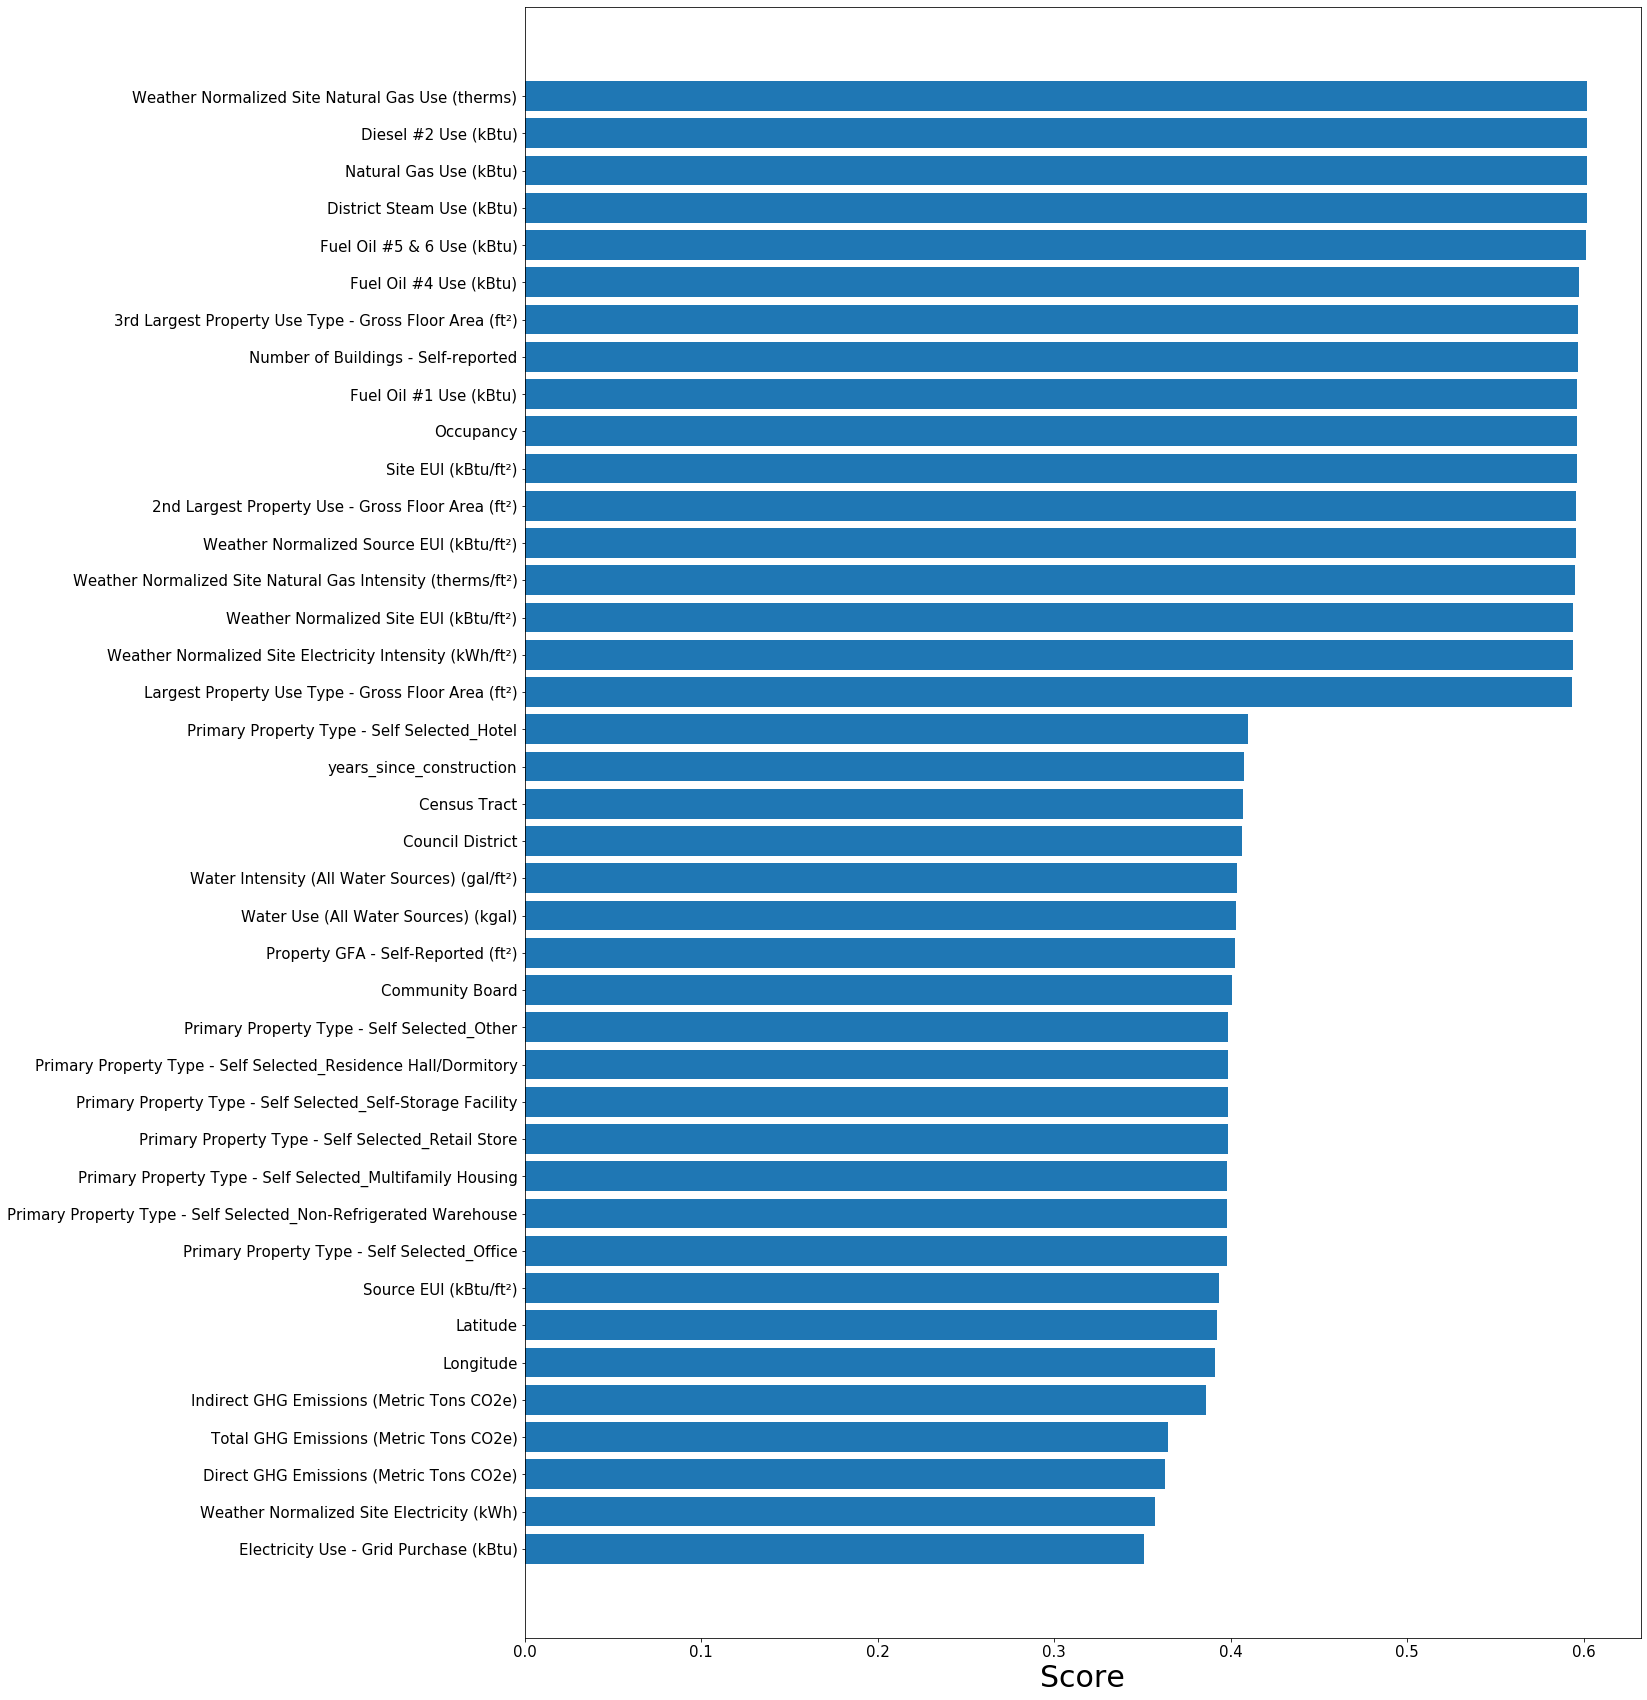

In [86]:
from  sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest



# configure to select all features
fs = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
fs.fit(X_train, y_train.astype(np.float32))
# transform train input data
X_train_fs = fs.transform(X_train)
# transform test input data
X_test_fs = fs.transform(X_test)
X_train_fs, X_test_fs, fs




fig, ax1 = plt.subplots(nrows=1, ncols=1,sharex=False)
fig.set_size_inches(10*2, 15*2)
ax1.set_facecolor('white')
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_color('black')
    
    
ax1.set_ylabel('')
ax1.set_xlabel('Score',size=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
    
score_df=pd.DataFrame({'feature':[X.columns.tolist()[i] for i in range(len(rfe.grid_scores_))], 'score':rfe.grid_scores_})
score_df.sort_values(by='score',inplace=True,ascending=True)
score_df=score_df.loc[(score_df.score!=np.nan) & ~score_df.score.isna(),:]
plt.barh(score_df['feature'], score_df['score'])
plt.gca().set_title('Feature Importance from Recursive Feature elimination')
plt.show()

In [88]:
len(use_case1_fin.iloc[rfe.ranking_,:].columns)

70

In [89]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [90]:
from sklearn.metrics import r2_score

y_pred=rfe.predict(X_test)
r2_score(y_test,y_pred)

0.6018587923442511

In [91]:
X_train.shape

(7713, 69)

<h2>Feature selection by Select KBest</h2>

In [92]:
#score_df.loc[score_df.feature=='Metered Areas (Energy)_Other',:]

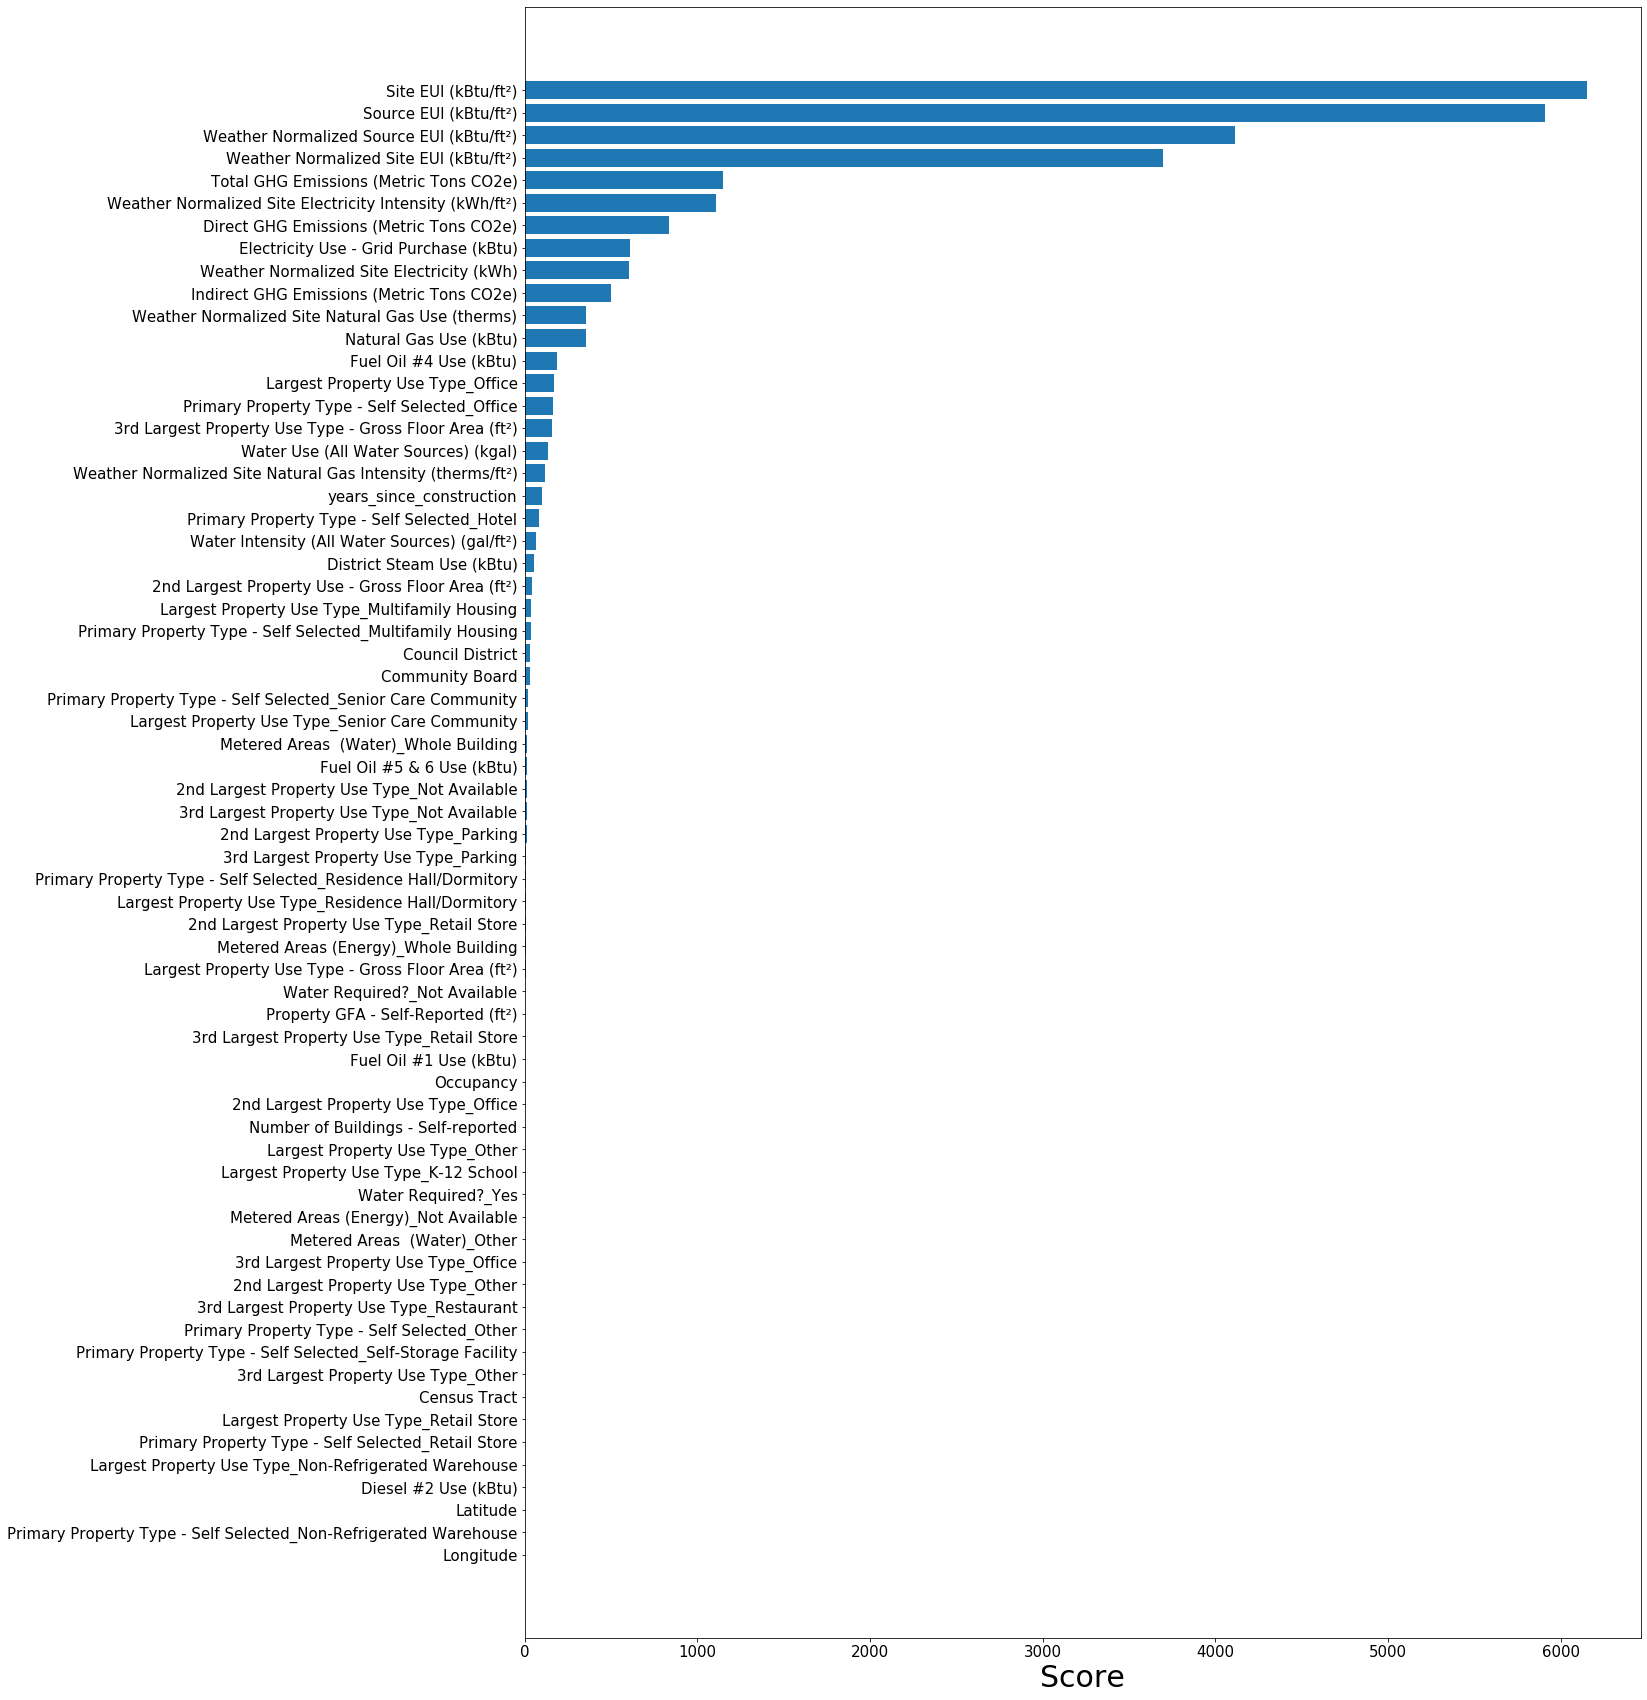

In [93]:
from  sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest



# configure to select all features
fs = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
fs.fit(X_train, y_train.astype('int32'))
# transform train input data
X_train_fs = fs.transform(X_train)
# transform test input data
X_test_fs = fs.transform(X_test)
X_train_fs, X_test_fs, fs




fig, ax1 = plt.subplots(nrows=1, ncols=1,sharex=False)
fig.set_size_inches(10*2, 15*2)
ax1.set_facecolor('white')
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_color('black')
    
    
ax1.set_ylabel('')
ax1.set_xlabel('Score',size=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
    
score_df=pd.DataFrame({'feature':[X.columns.tolist()[i] for i in range(len(fs.scores_))], 'score':fs.scores_})
score_df.sort_values(by='score',inplace=True,ascending=True)
score_df=score_df.loc[(score_df.score!=np.nan) & ~score_df.score.isna(),:]
plt.barh(score_df['feature'], score_df['score'])
plt.gca().set_title('Feature Importance from SelectK Best')
plt.show()

In [95]:
fet_lst_fin=score_df['feature'].tail(60).tolist()

In [96]:
linreg = LinearRegression()
linreg.fit(X_train[fet_lst_fin], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [97]:
from sklearn.metrics import r2_score

y_pred=linreg.predict(X_test[fet_lst_fin])
r2_score(y_test,y_pred)

0.6066141661795156

In [109]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error

def mape_fn(y_test,y_pred):
    '''Function to calculate mean average percentage error ranges from 0 to 1'''
    return np.mean(np.absolute((y_test.astype(np.float32)-y_pred.astype(np.float32))/(y_test.astype(np.float32))))

def get_metric(X_test,y_test,model):
    '''Function to calculate various performance metrics'''
    y_pred=model.predict(X_test)
    r2=np.round(r2_score(y_test,y_pred),2)
    
    rmse=np.round(np.sqrt(mean_squared_error(y_test,y_pred)),2)

    mae=np.round(mean_absolute_error(y_test,y_pred),2)

    mape=np.round(mape_fn(y_test,y_pred),2)
    return {'r2':r2,'rmse':rmse,'mae':mae,'mape':mape}

<h4>Confusion Matrix on final Star Grades</h4>

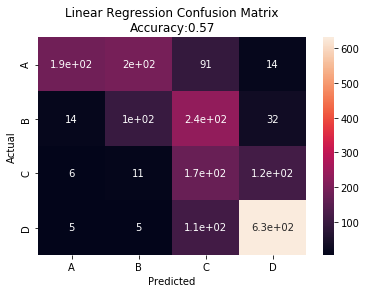

In [131]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn

def get_rating(x):    
    x=int(x)
    if x>85:
        return 'A'
    elif (x>70) & (x<=85):
        return 'B'
    elif (x>55) & (x<=70):
        return 'C'
    elif (x<=55):
        return 'D' 
    
y_pred_rf=linreg.predict(X_test[fet_lst_fin])
res_df_rf=pd.DataFrame({'y_test':y_test,'y_pred':y_pred_rf})
res_df_rf['y_pred']=res_df_rf['y_pred'].astype(np.float32)
res_df_rf['y_test']=res_df_rf['y_test'].astype(np.float32)
res_df_rf['rating_pred']=res_df_rf['y_pred'].apply(lambda x:get_rating(x))
res_df_rf['rating_org']=res_df_rf['y_test'].apply(lambda x:get_rating(x))


confusion_matrix = pd.crosstab(res_df_rf['rating_org'], res_df_rf['rating_pred'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.gca().set_title('Linear Regression Confusion Matrix' + '\nAccuracy:' + str(np.round(sklearn.metrics.accuracy_score(res_df_rf['rating_org'],res_df_rf['rating_pred']),2)))
plt.show()

Text(0, 0.5, 'Number of Points')

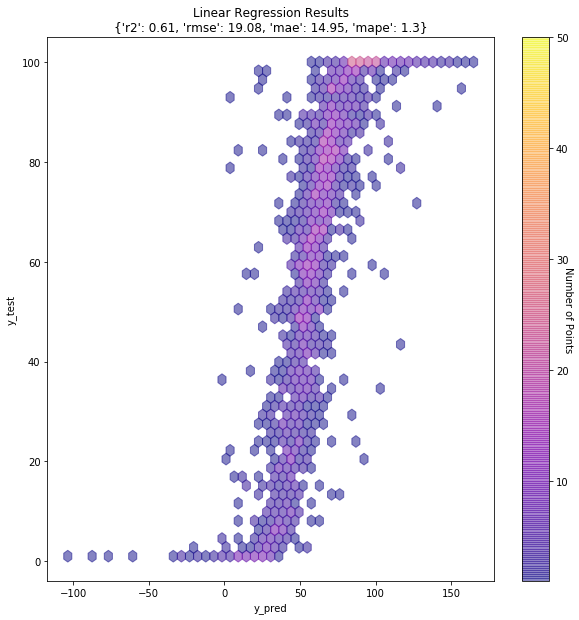

In [111]:
import json

y_pred=linreg.predict(X_test[fet_lst_fin])

res_df=pd.DataFrame({'y_test':y_test,'y_pred':y_pred})
res_df['y_pred']=res_df['y_pred'].astype(np.float32)
res_df['y_test']=res_df['y_test'].astype(np.float32)
fig, ax1 = plt.subplots(nrows=1, ncols=1,sharex=False)
fig.set_size_inches(10, 10)
hb=plt.hexbin(x=res_df['y_pred'],y=res_df['y_test'],alpha=0.5,cmap='plasma',mincnt=1,vmax=50,gridsize=50)
plt.gca().set_ylabel('y_test')
plt.gca().set_xlabel('y_pred')
plt.gca().set_title('Linear Regression Results\n' + str(get_metric(X_test[fet_lst_fin],y_test,linreg)))
cbar=fig.colorbar(hb)
cbar.ax.set_ylabel('Number of Points', rotation=270)

<h2>Random Forest Regression Implementation</h2>

In [112]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = 42)
from pprint import pprint

from sklearn.model_selection import RandomizedSearchCV

# Look at parameters used by our current forest
print('Parameters currently in use:\n')


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 100, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,5,10]
# Method of selecting samples for training each tree
bootstrap = [True, False]



random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 3, verbose=2, random_state=42, n_jobs = 5,n_iter=100)
# Fit the random search model
rf_random.fit(X_train, y_train)


Parameters currently in use:

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   48.5s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  6.1min
[Parallel(n_jobs=5)]: Done 300 out of 300 | elapsed: 12.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [113]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test,y_pred))

19.08159871161012

In [114]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test,y_pred)

14.945709586452486

In [115]:
def mape(y_test,y_pred):
    return np.mean(np.absolute((y_test.astype(np.float32)-y_pred.astype(np.float32))/(y_test.astype(np.float32))))

In [116]:
from sklearn.metrics import mean_absolute_error
mape(y_test,y_pred)

1.2993878

In [117]:
len(y_test)

1929

In [118]:
len(y_pred)

1929

Text(0, 0.5, 'Number of Points')

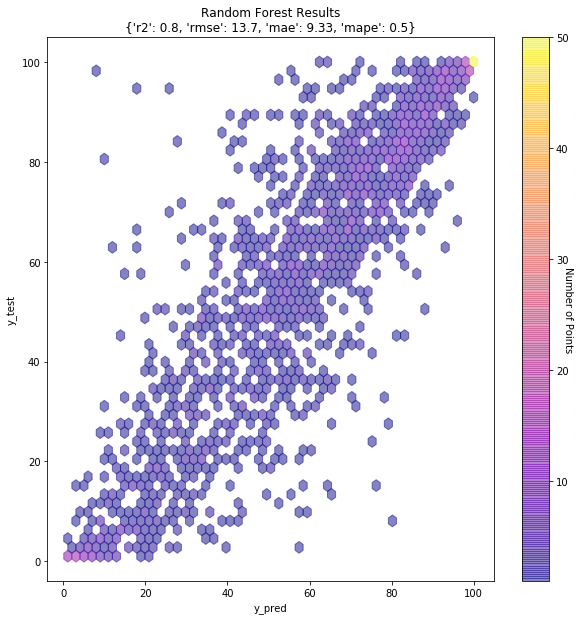

In [119]:
import json

y_pred=rf_random.best_estimator_.predict(X_test)

res_df=pd.DataFrame({'y_test':y_test,'y_pred':y_pred})
res_df['y_pred']=res_df['y_pred'].astype(np.float32)
res_df['y_test']=res_df['y_test'].astype(np.float32)
fig, ax1 = plt.subplots(nrows=1, ncols=1,sharex=False)
fig.set_size_inches(10, 10)
hb=plt.hexbin(x=res_df['y_pred'],y=res_df['y_test'],alpha=0.5,cmap='plasma',mincnt=1,vmax=50,gridsize=50)
plt.gca().set_ylabel('y_test')
plt.gca().set_xlabel('y_pred')
plt.gca().set_title('Random Forest Results\n' + str(get_metric(X_test,y_test,rf_random.best_estimator_)))
cbar=fig.colorbar(hb)
cbar.ax.set_ylabel('Number of Points', rotation=270)

Text(0.5, 1.0, 'Random Forest Results')

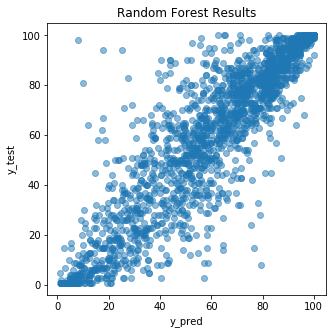

In [120]:
res_df=pd.DataFrame({'y_test':y_test,'y_pred':y_pred})
res_df['y_pred']=res_df['y_pred'].astype(np.float32)
res_df['y_test']=res_df['y_test'].astype(np.float32)
fig, ax1 = plt.subplots(nrows=1, ncols=1,sharex=False)
fig.set_size_inches(5, 5)
plt.scatter(x=res_df['y_pred'],y=res_df['y_test'],alpha=0.5)
plt.gca().set_ylabel('y_test')
plt.gca().set_xlabel('y_pred')
plt.gca().set_title('Random Forest Results')

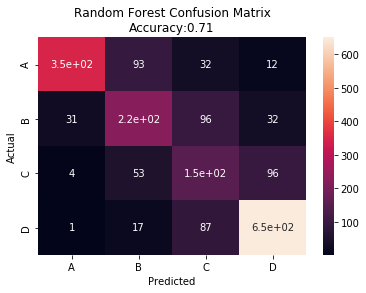

In [121]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn

def get_rating(x):    
    x=int(x)
    if x>85:
        return 'A'
    elif (x>70) & (x<=85):
        return 'B'
    elif (x>55) & (x<=70):
        return 'C'
    elif (x<=55):
        return 'D' 
    
y_pred_rf=rf_random.best_estimator_.predict(X_test)
res_df_rf=pd.DataFrame({'y_test':y_test,'y_pred':y_pred_rf})
res_df_rf['y_pred']=res_df_rf['y_pred'].astype(np.float32)
res_df_rf['y_test']=res_df_rf['y_test'].astype(np.float32)
res_df_rf['rating_pred']=res_df_rf['y_pred'].apply(lambda x:get_rating(x))
res_df_rf['rating_org']=res_df_rf['y_test'].apply(lambda x:get_rating(x))


confusion_matrix = pd.crosstab(res_df_rf['rating_org'], res_df_rf['rating_pred'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.gca().set_title('Random Forest Confusion Matrix' + '\nAccuracy:' + str(np.round(sklearn.metrics.accuracy_score(res_df_rf['rating_org'],res_df_rf['rating_pred']),2)))
plt.show()

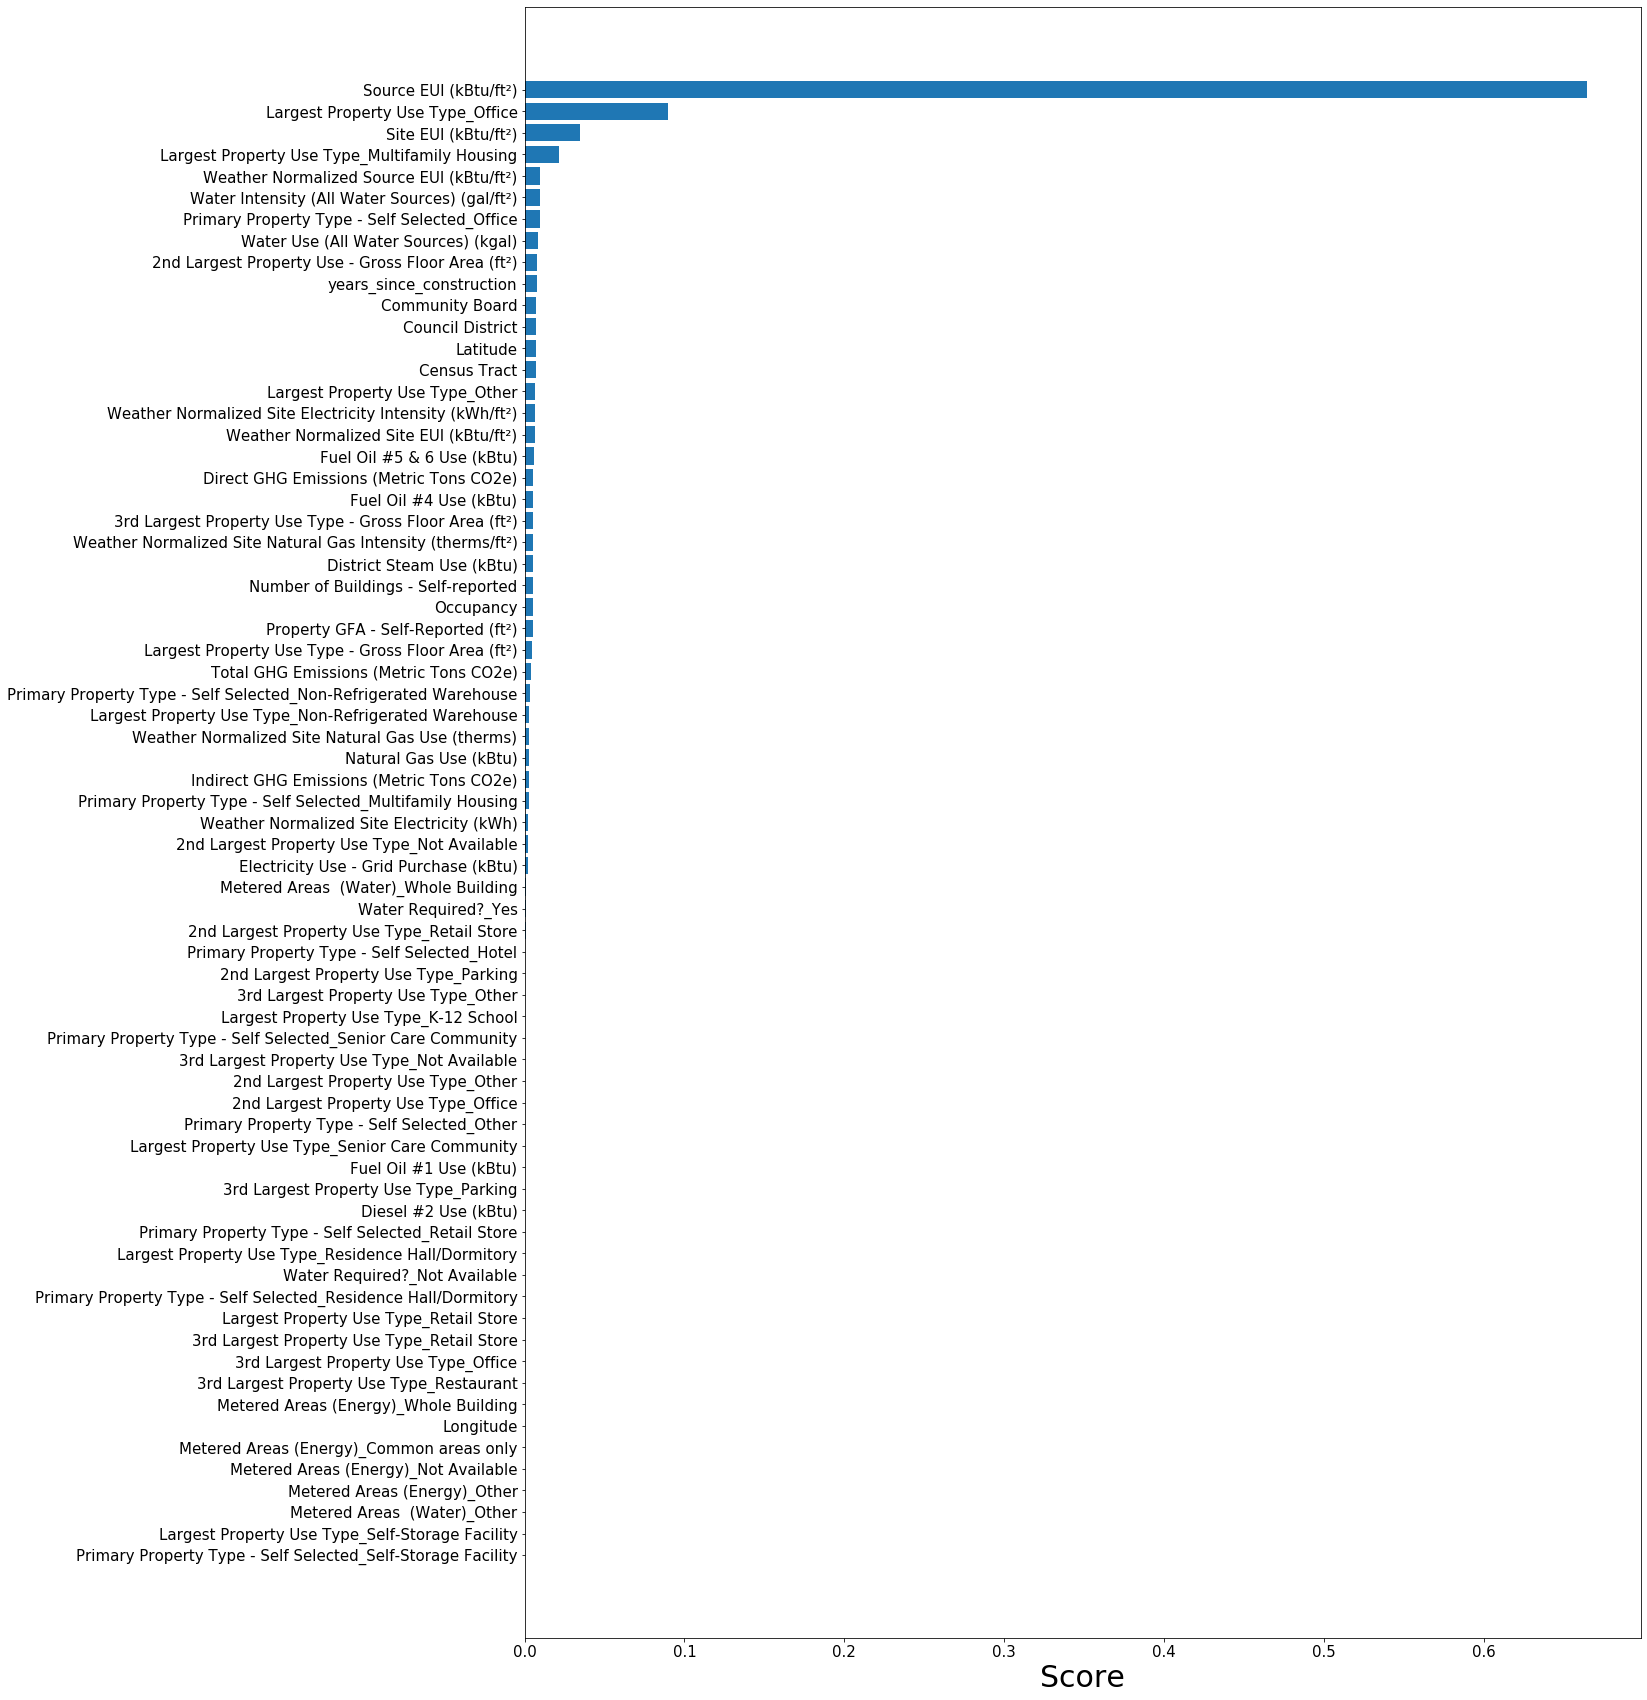

In [122]:
from  sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest



# configure to select all features
fs = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
fs.fit(X_train, y_train.astype(np.float32))
# transform train input data
X_train_fs = fs.transform(X_train)
# transform test input data
X_test_fs = fs.transform(X_test)
X_train_fs, X_test_fs, fs




fig, ax1 = plt.subplots(nrows=1, ncols=1,sharex=False)
fig.set_size_inches(10*2, 15*2)
ax1.set_facecolor('white')
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_color('black')
    
    
ax1.set_ylabel('')
ax1.set_xlabel('Score',size=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
    
score_df=pd.DataFrame({'feature':[X.columns.tolist()[i] for i in range(len(rf_random.best_estimator_.feature_importances_))], 'score':rf_random.best_estimator_.feature_importances_})
score_df.sort_values(by='score',inplace=True,ascending=True)
score_df=score_df.loc[(score_df.score!=np.nan) & ~score_df.score.isna(),:]
plt.barh(score_df['feature'], score_df['score'])
plt.show()

<h2>XGBoost Regression Implementation</h2>

In [123]:
# Install xgboost if not already installed by uncommenting below line
!pip install xgboost

In [124]:
import xgboost as xgb

xg = xgb.XGBRegressor(random_state = 42)
from pprint import pprint

from sklearn.model_selection import RandomizedSearchCV

# Look at parameters used by our current forest
print('Parameters currently in use:\n')


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 100, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,5,10]
# Method of selecting samples for training each tree
bootstrap = [True, False]



random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

xg_random = RandomizedSearchCV(estimator = xg, param_distributions = random_grid, cv = 3, verbose=2, random_state=42, n_jobs = 5,n_iter=100)
# Fit the random search model
xg_random.fit(X_train.astype('float32'), y_train.astype('int32'))

Parameters currently in use:

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:  7.6min
[Parallel(n_jobs=5)]: Done 300 out of 300 | elapsed: 15.7min finished


[22:59:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { bootstrap, max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                   iid='deprecated', n_iter=100, n_jobs=5,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 14, 24

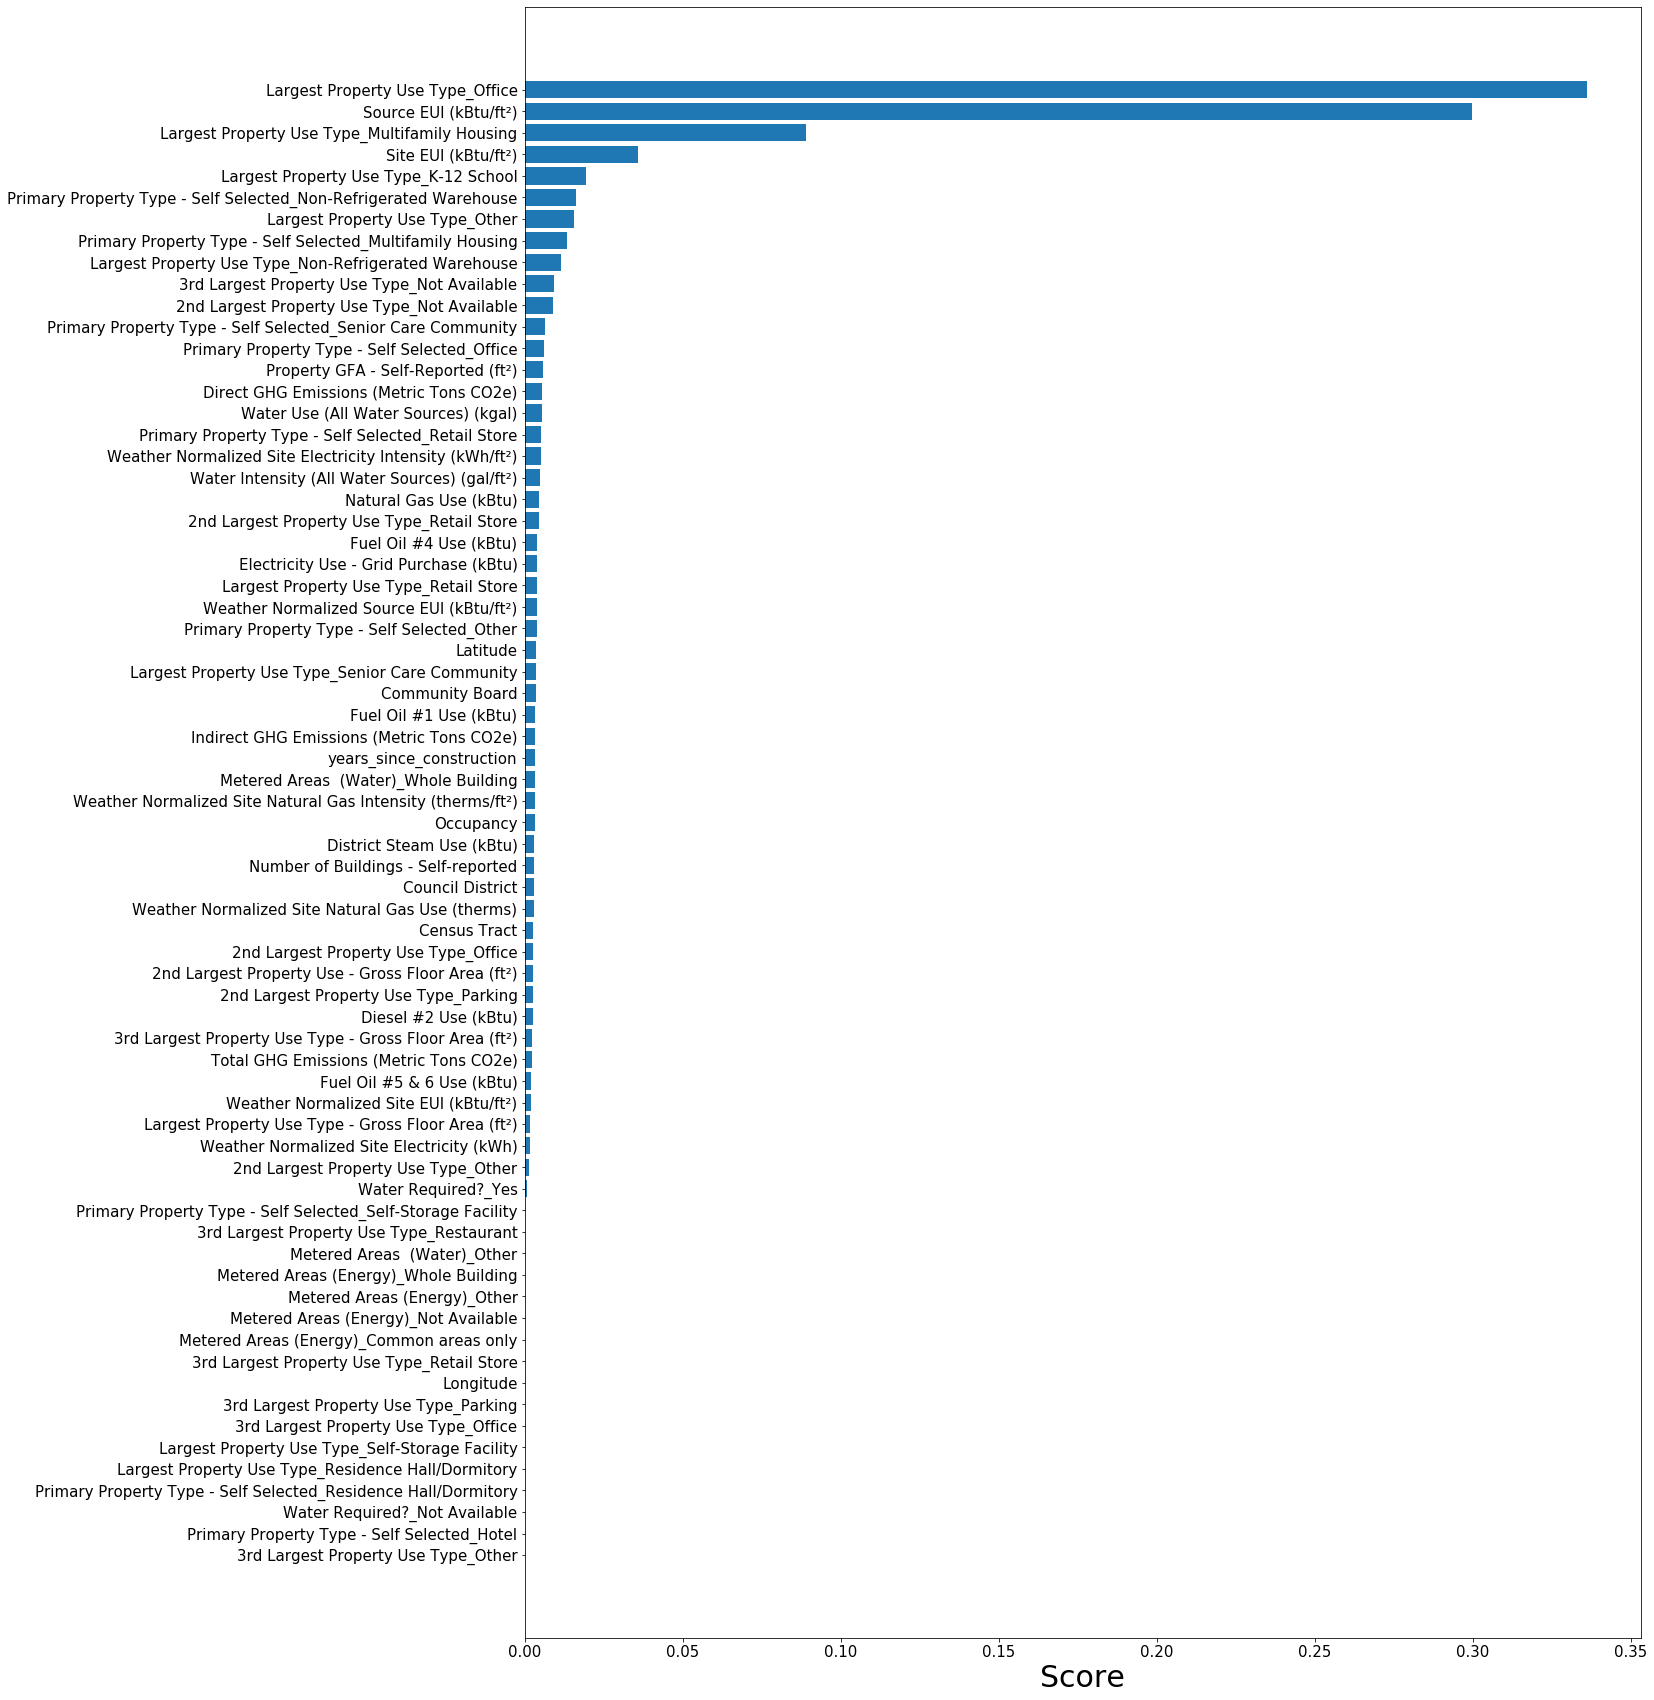

In [125]:
from  sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest



# configure to select all features
fs = SelectKBest(score_func=f_regression, k='all')
# learn relationship from training data
fs.fit(X_train, y_train.astype('int32'))
# transform train input data
X_train_fs = fs.transform(X_train)
# transform test input data
X_test_fs = fs.transform(X_test)
X_train_fs, X_test_fs, fs




fig, ax1 = plt.subplots(nrows=1, ncols=1,sharex=False)
fig.set_size_inches(10*2, 15*2)
ax1.set_facecolor('white')
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_color('black')
    
    
ax1.set_ylabel('')
ax1.set_xlabel('Score',size=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
    
score_df=pd.DataFrame({'feature':[X.columns.tolist()[i] for i in range(len(xg_random.best_estimator_.feature_importances_))], 'score':xg_random.best_estimator_.feature_importances_})
score_df.sort_values(by='score',inplace=True,ascending=True)
score_df=score_df.loc[(score_df.score!=np.nan) & ~score_df.score.isna(),:]
plt.barh(score_df['feature'], score_df['score'])
plt.show()

In [126]:
get_metric(X_test,y_test,xg_random.best_estimator_)

{'r2': 0.8, 'rmse': 13.59, 'mae': 9.42, 'mape': 0.53}

Text(0.5, 1.0, "XGBoost Results\n{'r2': 0.8, 'rmse': 13.59, 'mae': 9.42, 'mape': 0.53}")

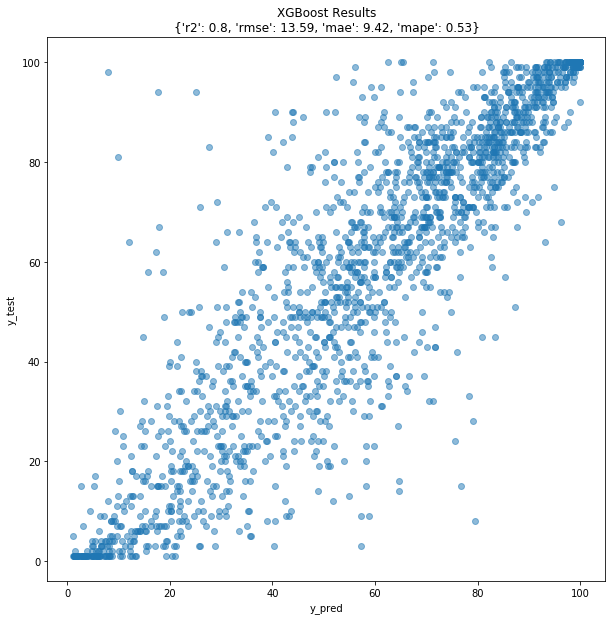

In [127]:
import json

y_pred_xg=xg_random.best_estimator_.predict(X_test)

res_df_xg=pd.DataFrame({'y_test':y_test,'y_pred':y_pred_xg})
res_df_xg['y_pred']=res_df['y_pred'].astype(np.float32)
res_df_xg['y_test']=res_df_xg['y_test'].astype(np.float32)
fig, ax1 = plt.subplots(nrows=1, ncols=1,sharex=False)
fig.set_size_inches(10, 10)
plt.scatter(x=res_df['y_pred'],y=res_df['y_test'],alpha=0.5)
plt.gca().set_ylabel('y_test')
plt.gca().set_xlabel('y_pred')
plt.gca().set_title('XGBoost Results\n' + str(get_metric(X_test,y_test,xg_random.best_estimator_)))


Text(0, 0.5, 'Number of Points')

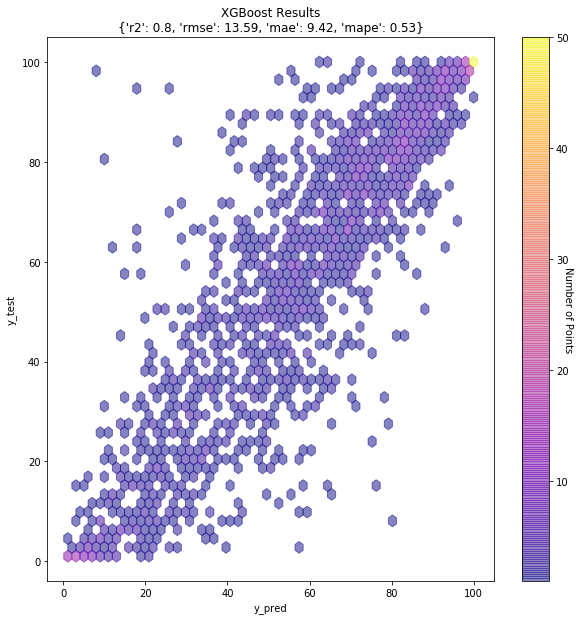

In [128]:
y_pred_xg=xg_random.best_estimator_.predict(X_test)
res_df_xg=pd.DataFrame({'y_test':y_test,'y_pred':y_pred_xg})
res_df_xg['y_pred']=res_df['y_pred'].astype(np.float32)
res_df_xg['y_test']=res_df_xg['y_test'].astype(np.float32)
fig, ax1 = plt.subplots(nrows=1, ncols=1,sharex=False)
fig.set_size_inches(10, 10)
hb=plt.hexbin(x=res_df_xg['y_pred'],y=res_df_xg['y_test'],alpha=0.5,cmap='plasma',mincnt=1,vmax=50,gridsize=50)
plt.gca().set_ylabel('y_test')
plt.gca().set_xlabel('y_pred')
plt.gca().set_title('XGBoost Results\n' + str(get_metric(X_test,y_test,xg_random.best_estimator_)))
cbar=fig.colorbar(hb)
cbar.ax.set_ylabel('Number of Points', rotation=270)

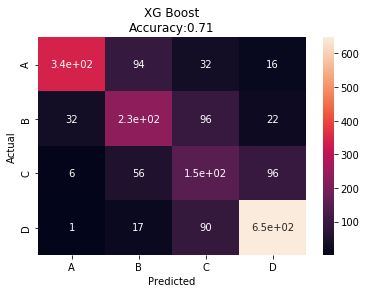

In [130]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn

def get_rating(x):    
    x=int(x)
    if x>85:
        return 'A'
    elif (x>70) & (x<=85):
        return 'B'
    elif (x>55) & (x<=70):
        return 'C'
    elif (x<=55):
        return 'D' 
    
y_pred_xg=xg_random.best_estimator_.predict(X_test)
res_df_xg=pd.DataFrame({'y_test':y_test,'y_pred':y_pred_xg})
res_df_xg['y_pred']=res_df_xg['y_pred'].astype(np.float32)
res_df_xg['y_test']=res_df_xg['y_test'].astype(np.float32)
res_df_xg['rating_pred']=res_df_xg['y_pred'].apply(lambda x:get_rating(x))
res_df_xg['rating_org']=res_df_xg['y_test'].apply(lambda x:get_rating(x))


confusion_matrix = pd.crosstab(res_df_xg['rating_org'], res_df_xg['rating_pred'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.gca().set_title('XG Boost' + '\nAccuracy:' + str(np.round(sklearn.metrics.accuracy_score(res_df_xg['rating_org'],res_df_xg['rating_pred']),2)))
plt.show()